Iran Twitter / X Data Analysis Project

In [ ]:
# ====================================================
# Iran Twitter / X Data Analysis Project
# ====================================================
# Course: Data Science Final Project (SCE)

In [2]:
# Install required packages
%pip install -q requests pandas urllib3 emoji transformers sentence-transformers scikit-learn matplotlib seaborn plotly numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# **italicized text*POI Scraper (Wikipedia Categories → CSV)**

In [4]:
# ============================================
# File: step1_collect_wikipedia_categories.py (UPDATED)
#
# Description:
#   Recursively collects people/pages from Wikipedia categories (including subcategories),
#   and saves a CSV per category with columns: Name, Wikipedia_Link.
#   Output structure (per course spec):
#       <IRAN_DIR>/
#         POIs/
#           <slug>/
#             <slug>_wikipedia.csv
#   Also produces a summary table and a ZIP with all CSVs.
# ============================================

import requests, time, os, zipfile
import pandas as pd
from urllib.parse import quote
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# ---------------- IRAN_DIR resolution ----------------
# Set the Iran directory path (adjust if needed)
IRAN_DIR = r"C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran"

if not os.path.isdir(IRAN_DIR):
    raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran' בנתיב: {IRAN_DIR}")

# Base POIs directory (as per course structure)
POIS_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIS_DIR, exist_ok=True)

# ---------------- API config ----------------
BASE_API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "SCE-DataScience-FinalProject/1.0 (contact: student@example.com)"}

session = requests.Session()
retries = Retry(total=5, backoff_factor=0.8, status_forcelist=[403,429,500,502,503,504])
session.mount("https://", HTTPAdapter(max_retries=retries))

def api_get(params):
    """Thin wrapper around MediaWiki API GET with a fallback UA on 403."""
    r = session.get(BASE_API, params=params, headers=HEADERS, timeout=30)
    if r.status_code == 403:
        time.sleep(1)
        r = session.get(BASE_API, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=30)
    r.raise_for_status()
    return r.json()

def get_category_members(category_title, cmtype="page"):
    """
    Fetches up to all members of a category, paging through 'continue'.
    cmtype can be "page" (actual pages) or "subcat" (subcategories).
    """
    members, params = [], {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": category_title,
        "cmlimit": "500",
        "cmtype": cmtype,
        "format": "json"
    }
    while True:
        data = api_get(params)
        members.extend(data.get("query", {}).get("categorymembers", []))
        if "continue" in data:
            params["cmcontinue"] = data["continue"]["cmcontinue"]
        else:
            break
    return members

def collect_people_from_category(root_category):
    """
    Breadth-first traversal from a root category:
      - collects 'page' members as rows {Name, Wikipedia_Link}
      - enqueues 'subcat' members for further traversal
    Returns a deduplicated DataFrame by Name.
    """
    seen, pages, queue = set(), [], [root_category]
    while queue:
        cat = queue.pop(0)
        if cat in seen:
            continue
        seen.add(cat)
        print(f"📂 סורק: {cat}")
        # pages
        for m in get_category_members(cat, "page"):
            title = m["title"]
            link  = "https://en.wikipedia.org/wiki/" + quote(title.replace(" ", "_"))
            pages.append({"Name": title, "Wikipedia_Link": link})
        # subcategories
        for sc in get_category_members(cat, "subcat"):
            queue.append(sc["title"])
        time.sleep(0.15)  # be polite
    return pd.DataFrame(pages).drop_duplicates(subset=["Name"]).reset_index(drop=True)

def safe_slug(cat):
    """
    Converts a category title to a folder/filename-safe slug.
    Example:
      "Category:Iranian physicians" -> "iranian_physicians"
    """
    name = cat.replace("Category:", "").strip()
    name = name.replace(" ", "_")
    for bad in ['"', "'", "'", """, """, "(", ")", "/", "\\", ":", "*", "?", "<", ">", "|", ",", ";", "—", "–"]:
        name = name.replace(bad, "")
    # compress consecutive underscores
    while "__" in name:
        name = name.replace("__", "_")
    return name.lower()

# ---------------- Categories to collect (expanded incl. healthcare) ----------------
categories = [
    # Existing:
    "Category:Government_ministers_of_Iran",
    "Category:Presidents_of_Iran",
    "Category:Vice_presidents_of_Iran",
    "Category:Iranian_ayatollahs",
    "Category:Iranian_actors",
    "Category:Iranian_singers",
    "Category:Iranian_scientists",
    "Category:Iranian_economists",
    "Category:Iranian_writers",
    "Category:Iranian_football_managers",

    # NEW — Healthcare related:
    "Category:Hospitals_in_Iran",
    "Category:Private_hospitals_in_Iran",
    "Category:Teaching_hospitals_in_Iran",
    "Category:Iranian_physicians",
    "Category:Iranian_cardiologists",
    "Category:Iranian_women_physicians",
    "Category:21st-century_Iranian_physicians",
    "Category:19th-century_Iranian_physicians",
    "Category:Medical_and_health_organisations_based_in_Iran",
    "Category:Healthcare_in_Iran",
    "Category:Medicine_in_Iran",

    # NEW — Journalists and Media:
    "Category:Iranian_journalists",
    "Category:Iranian_women_journalists",
    "Category:Iranian_reporters",
    "Category:Iranian_correspondents",
    "Category:Iranian_editors",
    "Category:Iranian_news_readers",

    # NEW — Activists and Political:
    "Category:Iranian_activists",
    "Category:Iranian_political_activists",
    "Category:Iranian_human_rights_activists",
    "Category:Iranian_women_activists",
    "Category:Iranian_feminists",
    "Category:Iranian_dissidents",
    "Category:Iranian_bloggers",

    # NEW — Sports:
    "Category:Iranian_footballers",
    "Category:Iranian_athletes",
    "Category:Iranian_wrestlers",
    "Category:Iranian_taekwondo_practitioners",
    "Category:Iranian_volleyball_players",
    "Category:Iranian_weightlifters",

    # NEW — Entertainment:
    "Category:Iranian_television_actors",
    "Category:Iranian_film_actors",
    "Category:Iranian_pop_singers",
    "Category:Iranian_rappers",
    "Category:Iranian_comedians",
]

# ---------------- Main loop: collect, save per-spec, summarize ----------------
csv_files = []
summary_rows = []

for cat in categories:
    try:
        slug = safe_slug(cat)
        cat_dir = os.path.join(POIS_DIR, slug)
        os.makedirs(cat_dir, exist_ok=True)

        csv_name = f"{slug}_wikipedia.csv"
        csv_path = os.path.join(cat_dir, csv_name)

        # Skip if file already exists and is not empty
        if os.path.exists(csv_path) and os.path.getsize(csv_path) > 0:
            print(f"⏩ Skipping {slug}: file already exists.")
            summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": "SKIPPED", "CSV": csv_path})
            continue

        df = collect_people_from_category(cat)
        n = len(df)

        if n == 0:
            print(f"⚠️ אין נתונים עבור {cat}")
            summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": 0, "CSV": None})
            continue

        df.to_csv(csv_path, index=False, encoding="utf-8-sig")
        csv_files.append(csv_path)

        print(f"✅ נשמר: {csv_path} | רשומות: {n}")
        summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": n, "CSV": csv_path})

    except Exception as e:
        print(f"❌ שגיאה בקטגוריה {cat}: {e}")
        summary_rows.append({"Category": cat, "Slug": safe_slug(cat), "SavedRows": 0, "CSV": None})

# --- Summary table ---
summary_df = pd.DataFrame(summary_rows)

# Add numeric column for sorting (convert SKIPPED to -1 for sorting purposes)
summary_df['SavedRows_Numeric'] = summary_df['SavedRows'].apply(
    lambda x: -1 if x == "SKIPPED" else (int(x) if isinstance(x, (int, float)) else 0)
)

# Sort by the numeric column and drop it
summary_df = summary_df.sort_values("SavedRows_Numeric", ascending=False).reset_index(drop=True)
summary_df = summary_df.drop(columns=['SavedRows_Numeric'])

# Calculate total (only numeric values)
total_saved = sum(x for x in summary_df["SavedRows"] if isinstance(x, (int, float)))

print("\n================= Summary =================")
for _, r in summary_df.iterrows():
    base = os.path.basename(r['CSV']) if (pd.notna(r['CSV']) and r['CSV']) else "-"
    saved_str = str(r['SavedRows'])
    print(f"• {r['Category']} -> {r['Slug']}: {saved_str} רשומות  |  קובץ: {base}")
print(f"\n📊 Total across files: {total_saved} rows")
print("===========================================\n")

# Display summary table
display(summary_df)

# ---------------- ZIP all CSVs ----------------
if csv_files:
    zip_path = os.path.join(IRAN_DIR, "Iran_POIs_Wikipedia_Categories.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in csv_files:
            # Save relative path in zip
            arcname = os.path.relpath(file, start=IRAN_DIR)
            zipf.write(file, arcname)
    print(f"💾 Created ZIP with all categories: {zip_path}")
else:
    print("ℹ️ No CSV files were created → no ZIP.")

⏩ Skipping government_ministers_of_iran: file already exists.
⏩ Skipping presidents_of_iran: file already exists.
⏩ Skipping vice_presidents_of_iran: file already exists.
⏩ Skipping iranian_ayatollahs: file already exists.
⏩ Skipping iranian_actors: file already exists.
⏩ Skipping iranian_singers: file already exists.
⏩ Skipping iranian_scientists: file already exists.
⏩ Skipping iranian_economists: file already exists.
⏩ Skipping iranian_writers: file already exists.
⏩ Skipping iranian_football_managers: file already exists.
⏩ Skipping hospitals_in_iran: file already exists.
⏩ Skipping private_hospitals_in_iran: file already exists.
⏩ Skipping teaching_hospitals_in_iran: file already exists.
⏩ Skipping iranian_physicians: file already exists.
⏩ Skipping iranian_cardiologists: file already exists.
⏩ Skipping iranian_women_physicians: file already exists.
⏩ Skipping 21st-century_iranian_physicians: file already exists.
⏩ Skipping 19th-century_iranian_physicians: file already exists.
⏩ S

,Category,Slug,SavedRows,CSV
0,Category:Iranian_news_readers,iranian_news_readers,0,None
1,Category:Iranian_correspondents,iranian_correspondents,0,None
2,Category:Iranian_reporters,iranian_reporters,0,None
3,Category:Iranian_political_activists,iranian_political_activists,0,None
4,Category:Government_ministers_of_Iran,government_ministers_of_iran,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
5,Category:Iranian_singers,iranian_singers,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
6,Category:Iranian_scientists,iranian_scientists,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
7,Category:Iranian_economists,iranian_economists,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
8,Category:Iranian_writers,iranian_writers,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
9,Category:Presidents_of_Iran,presidents_of_iran,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...


ℹ️ No CSV files were created → no ZIP.


# **Step 3: Wikidata Enrichment for ALL POI Folders**

In [5]:
# ============================================
# Step 3: Wikidata Enrichment for ALL POI Folders (UPDATED)
# ============================================
# For each subfolder under POIs:
#  1) Locate *_wikipedia.csv (or the first .csv)
#  2) Detect the Wikipedia link column (fallback to Name)
#  3) Resolve wikidata_qid (+ wikidata_url)
#  4) Fetch details via SPARQL in batches
#  5) Save:
#     a) *_with_wikidata_ids_and_links.csv
#     b) *_with_wikidata_ids_and_links_wikidata_detailed.csv
# ============================================

import os, re, time, glob, json, math, random
import pandas as pd
import requests
from pathlib import Path

# ---------------- Dynamic path detection ----------------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

ROOT_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(ROOT_DIR, exist_ok=True)
print(f"📁 ROOT_DIR: {ROOT_DIR}")

# ---------------- HTTP / Endpoints ----------------
UA = {"User-Agent": "SCE-DS-FinalProject/1.0 (contact: student@example.com)"}
MEDIAWIKI_API = "https://en.wikipedia.org/w/api.php"
SPARQL = "https://query.wikidata.org/sparql"

# ---------------- Helpers: retries ----------------
def http_get(url, params=None, headers=None, timeout=30, max_tries=4, sleep_base=0.8):
    """
    Simple GET with retries/backoff. Jitters a bit to be polite.
    """
    headers = headers or UA
    for attempt in range(1, max_tries + 1):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            if r.status_code == 403 and headers is UA:
                # fallback UA
                r = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=timeout)
            r.raise_for_status()
            return r
        except Exception as e:
            if attempt == max_tries:
                # last attempt: raise
                raise
            sleep_s = sleep_base * attempt + random.uniform(0, 0.3)
            time.sleep(sleep_s)
    # Shouldn't reach here
    raise RuntimeError("GET retries exhausted")

# ---------------- Column detection ----------------
def find_wikipedia_column(df: pd.DataFrame) -> str:
    # First pass: headers with hints
    for name in df.columns:
        n = str(name).strip().lower()
        if any(k in n for k in ["wikipedia", "wiki", "link", "url"]):
            return name
    # Second pass: sample content
    for name in df.columns:
        sample = " ".join(map(str, df[name].dropna().astype(str).head(20).tolist())).lower()
        if "wikipedia.org" in sample or sample.startswith("http"):
            return name
    # Fallback
    if "Wikipedia_Link" in df.columns:
        return "Wikipedia_Link"
    # As a last resort: if Name exists, we'll construct enwiki URLs from it
    if "Name" in df.columns:
        return None  # signal to construct from Name
    raise ValueError("לא מצאתי עמודת קישור לוויקיפדיה, ואין גם עמודת 'Name' לבניית קישורים.")

def name_to_enwiki_url(name: str) -> str:
    from urllib.parse import quote
    if not isinstance(name, str) or not name.strip():
        return None
    title = name.strip().replace(" ", "_")
    return f"https://en.wikipedia.org/wiki/{quote(title)}"

def wikipedia_url_to_title(url: str) -> str | None:
    if not isinstance(url, str) or not url:
        return None
    try:
        url = url.split("?")[0].split("#")[0]
        title = url.rstrip("/").split("/")[-1]
        return title if title else None
    except Exception:
        return None

# ---------------- QID resolution (with cache) ----------------
qid_cache = {}

def get_qid_from_wikipedia_url(url: str) -> str | None:
    """
    Resolve QID for a single Wikipedia page using the pageprops endpoint.
    """
    title = wikipedia_url_to_title(url)
    if not title:
        return None
    if title in qid_cache:
        return qid_cache[title]
    params = {
        "action": "query",
        "format": "json",
        "prop": "pageprops",
        "redirects": 1,
        "titles": title,
    }
    try:
        r = http_get(MEDIAWIKI_API, params=params, headers=UA, timeout=25)
        data = r.json()
        page = next(iter(data["query"]["pages"].values()))
        qid = page.get("pageprops", {}).get("wikibase_item")
        if qid:
            qid_cache[title] = qid
        return qid
    except Exception:
        return None

# ---------------- SPARQL batch fetch ----------------
def batch_fetch_wikidata_details(qids: list[str], batch_size: int = 50) -> dict:
    """
    Fetch properties for many QIDs via SPARQL using VALUES batching.
    Returns dict: { QID: {fields...}, ... }
    """
    results = {}
    # Normalize & unique
    qids = [q for q in qids if isinstance(q, str) and q.strip()]
    uniq = sorted(set(qids))
    if not uniq:
        return results

    def run_batch(subset):
        values = " ".join(f"wd:{q}" for q in subset)
        query = f"""
        SELECT ?item ?genderLabel ?occupationLabel ?countryLabel ?placeOfBirthLabel ?dateOfBirth WHERE {{
          VALUES ?item {{ {values} }}
          OPTIONAL {{ ?item wdt:P21 ?gender. }}
          OPTIONAL {{ ?item wdt:P106 ?occupation. }}
          OPTIONAL {{ ?item wdt:P27 ?country. }}
          OPTIONAL {{ ?item wdt:P19 ?placeOfBirth. }}
          OPTIONAL {{ ?item wdt:P569 ?dateOfBirth. }}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en,fa,en-gb". }}
        }}
        """
        r = http_get(SPARQL, params={"query": query, "format": "json"}, headers=UA, timeout=45)
        rows = r.json().get("results", {}).get("bindings", [])
        # collect multiple rows per item
        tmp = {}
        for b in rows:
            uri = b.get("item", {}).get("value", "")
            q = uri.rsplit("/", 1)[-1] if uri else None
            if not q:
                continue
            cur = tmp.setdefault(q, {"wikidata_gender": set(),
                                     "wikidata_occupation": set(),
                                     "wikidata_country_of_citizenship": set(),
                                     "wikidata_place_of_birth": None,
                                     "wikidata_date_of_birth": None})
            if "genderLabel" in b:
                cur["wikidata_gender"].add(b["genderLabel"]["value"])
            if "occupationLabel" in b:
                cur["wikidata_occupation"].add(b["occupationLabel"]["value"])
            if "countryLabel" in b:
                cur["wikidata_country_of_citizenship"].add(b["countryLabel"]["value"])
            if "placeOfBirthLabel" in b and not cur["wikidata_place_of_birth"]:
                cur["wikidata_place_of_birth"] = b["placeOfBirthLabel"]["value"]
            if "dateOfBirth" in b and not cur["wikidata_date_of_birth"]:
                cur["wikidata_date_of_birth"] = b["dateOfBirth"]["value"]
        # flatten sets
        for q, d in tmp.items():
            results[q] = {
                "wikidata_gender": "; ".join(sorted(d["wikidata_gender"])) or None,
                "wikidata_occupation": "; ".join(sorted(d["wikidata_occupation"])) or None,
                "wikidata_country_of_citizenship": "; ".join(sorted(d["wikidata_country_of_citizenship"])) or None,
                "wikidata_place_of_birth": d["wikidata_place_of_birth"],
                "wikidata_date_of_birth": d["wikidata_date_of_birth"],
            }

    for i in range(0, len(uniq), batch_size):
        subset = uniq[i:i+batch_size]
        # polite pacing
        try:
            run_batch(subset)
        except Exception as e:
            print(f"⚠️ SPARQL batch failed ({subset[0]}..): {e}. מנסה שוב בקבוצות קטנות יותר...")
            # fallback: try half batch to circumvent transient errors
            mid = len(subset)//2 or 1
            for chunk in (subset[:mid], subset[mid:]):
                try:
                    run_batch(chunk)
                except Exception as ee:
                    print(f"❌ SPARQL sub-batch failed ({chunk[0]}..): {ee}")
        time.sleep(0.5)

    return results

# ---------------- Main processing ----------------
folders = [f for f in sorted(os.listdir(ROOT_DIR)) if os.path.isdir(os.path.join(ROOT_DIR, f))]
print(f"🗂️ נמצאו {len(folders)} תיקיות POI לעיבוד.")

for folder in folders:
    FOLDER_PATH = os.path.join(ROOT_DIR, folder)
    print(f"\n📂 מעבד תיקייה: {folder}")

    # Locate input CSV (prefer *_wikipedia.csv)
    candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*_wikipedia.csv")))
    if not candidates:
        candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*.csv")))
    if not candidates:
        print("⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.")
        continue

    INPUT_CSV = candidates[0]
    base_name = re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV))
    
    # ⚡ SMART SKIP: Check if Wikidata enrichment already complete
    detailed_path = os.path.join(FOLDER_PATH, f"{base_name}_with_wikidata_ids_and_links_wikidata_detailed.csv")
    if os.path.exists(detailed_path):
        try:
            df_check = pd.read_csv(detailed_path, nrows=5)
            wd_cols = [c for c in df_check.columns if c.startswith('wikidata_')]
            if wd_cols and df_check[wd_cols].notna().any().any():
                print(f"✅ SKIP: Wikidata enrichment already complete")
                print(f"   File: {os.path.basename(detailed_path)}")
                print(f"   Found {len(wd_cols)} Wikidata columns with data")
                continue
        except Exception:
            pass

    candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*_wikipedia.csv")))
    if not candidates:
        candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*.csv")))
    if not candidates:
        print("⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.")
        continue

    INPUT_CSV = candidates[0]
    try:
        df = pd.read_csv(INPUT_CSV)
    except Exception as e:
        print(f"❌ לא הצלחתי לקרוא את הקובץ {os.path.basename(INPUT_CSV)}: {e} — מדלג.")
        continue

    # Detect / construct Wikipedia links
    try:
        wiki_col = find_wikipedia_column(df)
    except Exception as e:
        print(f"⚠️ {e} — מנסה לבנות קישורי ויקיפדיה מ־'Name'...")
        wiki_col = None

    if wiki_col is None:
        if "Name" in df.columns:
            df["Wikipedia_Link"] = df["Name"].apply(name_to_enwiki_url)
            wiki_col = "Wikipedia_Link"
        else:
            print("❌ אין עמודת קישור/Name — מדלג על התיקייה.")
            continue

    print("🧩 עמודת ויקיפדיה:", wiki_col)

    # ---- A) Resolve QIDs (with simple in-memory cache) ----
    qids = []
    for url in df[wiki_col].fillna(""):
        qids.append(get_qid_from_wikipedia_url(url))
        time.sleep(0.08)  # polite throttle

    df["wikidata_qid"] = qids
    df["wikidata_url"] = df["wikidata_qid"].apply(lambda q: f"https://www.wikidata.org/wiki/{q}" if isinstance(q, str) and q else None)

    # Save mid file
    mid_path = os.path.join(
        FOLDER_PATH,
        re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV)) + "_with_wikidata_ids_and_links.csv"
    )
    try:
        df.to_csv(mid_path, index=False, encoding="utf-8-sig")
        print(f"💾 נשמר ביניים: {os.path.basename(mid_path)}  (שורות: {len(df)})")
    except Exception as e:
        print(f"❌ שגיאה בשמירת קובץ ביניים: {e}")

    # ---- B) Fetch details via SPARQL in batches ----
    uniq_qids = [q for q in pd.Series(df["wikidata_qid"]).dropna().astype(str).unique().tolist() if q]
    details_map = batch_fetch_wikidata_details(uniq_qids, batch_size=50)

    details_rows = []
    for q in df["wikidata_qid"]:
        if isinstance(q, str) and q in details_map:
            details_rows.append(details_map[q])
        else:
            details_rows.append({
                "wikidata_gender": None,
                "wikidata_occupation": None,
                "wikidata_country_of_citizenship": None,
                "wikidata_place_of_birth": None,
                "wikidata_date_of_birth": None,
            })

    details_df = pd.DataFrame(details_rows)
    enriched = pd.concat([df, details_df], axis=1)

    out_path = os.path.join(
        FOLDER_PATH,
        re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV)) + "_with_wikidata_ids_and_links_wikidata_detailed.csv"
    )
    try:
        enriched.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"✅ נשמר פלט סופי: {os.path.basename(out_path)}  (שורות: {len(enriched)})")
    except Exception as e:
        print(f"❌ שגיאה בשמירת הפלט הסופי: {e}")

print("\n🎉 הושלם עיבוד לכל התיקיות!")


📁 ROOT_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
🗂️ נמצאו 49 תיקיות POI לעיבוד.

📂 מעבד תיקייה: 19th-century_iranian_physicians
✅ SKIP: Wikidata enrichment already complete
   File: 19th-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Found 7 Wikidata columns with data

📂 מעבד תיקייה: 21st-century_iranian_physicians
✅ SKIP: Wikidata enrichment already complete
   File: 21st-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Found 7 Wikidata columns with data

📂 מעבד תיקייה: Candidates
⚠️ לא מצאתי עמודת קישור לוויקיפדיה, ואין גם עמודת 'Name' לבניית קישורים. — מנסה לבנות קישורי ויקיפדיה מ־'Name'...
❌ אין עמודת קישור/Name — מדלג על התיקייה.

📂 מעבד תיקייה: figures
⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.

📂 מעבד תיקייה: government_ministers_of_iran
✅ SKIP: Wikidata enrichment already complete
   File: government_ministers_of_iran_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Foun

# Step 4: Find Twitter handles for ALL POI folders

In [ ]:
# ============================================
# Step 4: Find Twitter handles for ALL POI folders
# Adds only: Twitter_username + Twitter_url (no twitter_source)
# ============================================

import os, re, time, json, glob, requests, pandas as pd, random
from pathlib import Path
from urllib.parse import urlparse, unquote
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

# ירוץ על כל התיקיות תחת POIs
REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
print("📁 ROOT:", ROOT)

# ---------- HTTP session with retries ----------
UA = {"User-Agent": "SCE-DS-FinalProject/1.0 (contact: student@example.com)"}
session = requests.Session()
session.headers.update(UA)

# urllib3 v2: allowed_methods (not method_whitelist). עדיף frozenset
retry_cfg = Retry(
    total=5,
    backoff_factor=0.6,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=frozenset({"GET"}),
)
session.mount("https://", HTTPAdapter(max_retries=retry_cfg))
session.mount("http://", HTTPAdapter(max_retries=retry_cfg))

SPARQL = "https://query.wikidata.org/sparql"
MEDIAWIKI_API = "https://en.wikipedia.org/w/api.php"

# ---------- helpers ----------
def pick_csv(folder):
    for pat in ["*_with_wikidata_ids_and_links_wikidata_detailed*.csv",
                "*_with_wikidata_ids_and_links*.csv",
                "*_wikipedia.csv",
                "*.csv"]:
        cand = sorted(glob.glob(os.path.join(folder, pat)))
        # סנן קבצים שכבר מכילים _with_twitter (אלה הם פלטים, לא קלטים)
        cand = [c for c in cand if not c.endswith("_with_twitter.csv")]
        if cand: return cand[0]
    return None

def clean_handle(h):
    if not isinstance(h, str):
        return None
    h = h.strip().lstrip("@")
    h = re.sub(r"[/?#].*$", "", h)
    m = re.match(r"^[A-Za-z0-9_]{1,15}$", h)
    return m.group(0) if m else None

def extract_handle_from_url(url):
    """
    מחלץ ידית מכתובת twitter/x אם קיימת. לינקים מסוג /i/user/12345 לא מכילים ידית => נחזיר None.
    """
    try:
        u = url.split("?")[0].split("#")[0]
        host = urlparse(u).netloc.lower()
        if any(d in host for d in ["twitter.com","x.com","mobile.twitter.com","www.twitter.com","www.x.com"]):
            parts = urlparse(u).path.strip("/").split("/")
            if parts and parts[0].lower() not in {"i","intent","share","home"}:
                return clean_handle(parts[0])
    except:
        pass
    return None

def build_twitter_url(handle):
    if not isinstance(handle, str) or not handle.strip():
        return None
    return f"https://x.com/{handle.strip().lstrip('@')}"

def find_wikipedia_column(df):
    # ראשית: לפי שם עמודה
    for c in df.columns:
        n = str(c).lower()
        if any(k in n for k in ["wikipedia", "wiki", "link", "url"]):
            return c
    # שנית: לפי תוכן
    for c in df.columns:
        vals = " ".join(map(str, df[c].dropna().astype(str).head(15).tolist())).lower()
        if "wikipedia.org" in vals or "https://" in vals or "http://" in vals:
            return c
    return None

def http_get(url, params=None, headers=None, timeout=30, tries=3, backoff=0.7):
    headers = headers or UA
    for attempt in range(1, tries+1):
        try:
            r = session.get(url, params=params, headers=headers, timeout=timeout)
            r.raise_for_status()
            return r
        except Exception as e:
            if attempt == tries:
                raise
            time.sleep(backoff * attempt + random.uniform(0, 0.2))

def guess_twitter_from_wiki(title_or_url):
    """
    נסה לחלץ ידית מהדף בוויקיפדיה:
    - External links
    - טקסט המקור (wikitext) עם regex
    """
    try:
        if isinstance(title_or_url, str) and title_or_url.startswith(("http://", "https://")):
            title = unquote(title_or_url.split("?")[0].split("#")[0].rstrip("/").split("/")[-1])
            title = title.replace("_", " ")
        else:
            title = str(title_or_url).strip().replace("_", " ")
        if not title:
            return None

        r = http_get(MEDIAWIKI_API, params={
            "action": "parse",
            "format": "json",
            "page": title,
            "prop": "externallinks|wikitext",
            "redirects": 1
        }, timeout=30, tries=3)
        data = r.json()

        links = data.get("parse", {}).get("externallinks", []) or []
        for ln in links:
            h = extract_handle_from_url(ln)
            if h:
                return h

        wt = data.get("parse", {}).get("wikitext", {}).get("*", "")
        # תופס גם twitter וגם x.com
        for m in re.finditer(r"(?:https?://)?(?:www\.)?(?:twitter|x)\.com/([A-Za-z0-9_]{1,15})", wt, re.I):
            h = clean_handle(m.group(1))
            if h:
                return h
    except:
        pass
    return None

def batch_p2002(qids):
    """
    מחזיר מפה { QID: handle or None } עם retry.
    """
    qids = [q for q in qids if isinstance(q, str) and q]
    if not qids:
        return {}
    values = " ".join(f"(wd:{q})" for q in qids)
    q = f"""
    SELECT ?item ?twitter WHERE {{
      VALUES (?item) {{ {values} }}
      OPTIONAL {{ ?item wdt:P2002 ?twitter. }}
    }}
    """
    # retry דרך http_get
    r = http_get(SPARQL, params={"query": q, "format": "json"}, timeout=45, tries=3, backoff=0.9)
    rows = r.json().get("results", {}).get("bindings", [])
    out = {}
    for b in rows:
        qid = b["item"]["value"].rsplit("/",1)[-1]
        tw = b.get("twitter", {}).get("value")
        out[qid] = clean_handle(tw) if tw else None
    return out

# cache (QID -> handle)
cache_file = os.path.join(ROOT, "_twitter_cache.json")
twitter_cache = {}
if os.path.exists(cache_file):
    try:
        twitter_cache = json.load(open(cache_file, "r", encoding="utf-8"))
    except:
        twitter_cache = {}

# ---------- process all subfolders ----------
folders = [os.path.join(ROOT, d) for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]
folders.sort()

for FOLDER in folders:
    in_csv = pick_csv(FOLDER)
    if not in_csv:
        print(f"⚠️ אין CSV בתיקייה {os.path.basename(FOLDER)} — דילוג")
        continue

    # ⚡ SMART SKIP: Check if Twitter enrichment already complete
    # בדיקת כל הפורמטים האפשריים של קבצי Twitter
    base_name = os.path.splitext(os.path.basename(in_csv))[0]
    possible_outputs = [
        os.path.join(FOLDER, base_name + "_with_twitter.csv"),
        os.path.join(FOLDER, base_name.replace("_wikidata_detailed", "") + "_with_twitter.csv"),
        # אם הקובץ נקרא *_detailed.csv, נסה גם ללא detailed
        os.path.join(FOLDER, base_name.replace("_detailed", "") + "_with_twitter.csv")
    ]
    
    skip = False
    for out_path in possible_outputs:
        if os.path.exists(out_path):
            try:
                df_check = pd.read_csv(out_path, nrows=5)
                if 'Twitter_username' in df_check.columns:
                    twitter_count = df_check['Twitter_username'].notna().sum()
                    if twitter_count > 0:
                        print(f"\n📂 {os.path.basename(FOLDER)}")
                        print(f"✅ SKIP: Twitter enrichment already complete")
                        print(f"   File: {os.path.basename(out_path)} ({twitter_count}+ handles)")
                        skip = True
                        break
            except Exception:
                pass
    
    if skip:
        continue

    print(f"\n📂 {os.path.basename(FOLDER)}")
    try:
        df = pd.read_csv(in_csv)
    except Exception as e:
        print(f"❌ לא הצלחתי לקרוא את הקובץ: {e} — דילוג")
        continue

    wiki_col = find_wikipedia_column(df)
    if "wikidata_qid" not in df.columns:
        df["wikidata_qid"] = None

    if "Twitter_username" not in df.columns:
        df["Twitter_username"] = None

    # 1) Wikidata P2002 (with cache)
    qids = [q for q in df["wikidata_qid"].dropna().astype(str).unique() if q]
    p2002_map = {}
    # קודם מה-cache
    for q in qids:
        if q in twitter_cache:
            p2002_map[q] = twitter_cache[q]
    # מה שחסר — לשאילתא (בקבוצות)
    to_query = [q for q in qids if q not in p2002_map]
    for i in range(0, len(to_query), 60):
        part = to_query[i:i+60]
        try:
            m = batch_p2002(part)
            p2002_map.update(m)
            # לעדכן cache רק כשיש ידית (כדי לא “לקבע” None)
            twitter_cache.update({k: v for k, v in m.items() if v})
            time.sleep(0.25)
        except Exception as e:
            print("⚠️ SPARQL batch failed:", e)

    # כתיבה לפי QID
    for idx, row in df.iterrows():
        qid = row.get("wikidata_qid")
        if isinstance(qid, str) and qid in p2002_map and p2002_map[qid]:
            if not df.at[idx, "Twitter_username"]:
                df.at[idx, "Twitter_username"] = p2002_map[qid]

    # 2) Wikipedia fallback
    if wiki_col:
        missing = df["Twitter_username"].isna()
        for idx, row in df[missing].iterrows():
            url = row[wiki_col]
            if isinstance(url, str) and url.strip():
                h = guess_twitter_from_wiki(url)
                if h:
                    df.at[idx, "Twitter_username"] = h
                    # אם יש גם QID — עדכן cache (נחסוך בהפעלות עתידיות)
                    qid = row.get("wikidata_qid")
                    if isinstance(qid, str) and qid:
                        twitter_cache[qid] = h

    # ניקוי + URL
    df["Twitter_username"] = df["Twitter_username"].apply(lambda h: clean_handle(h) if isinstance(h, str) else None)
    df["Twitter_url"] = df["Twitter_username"].apply(build_twitter_url)

    # save (UTF-8-SIG to be Excel-friendly)
    out_path = os.path.join(FOLDER, os.path.splitext(os.path.basename(in_csv))[0] + "_with_twitter.csv")
    try:
        df.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"✅ Saved: {os.path.basename(out_path)} | found {df['Twitter_username'].notna().sum()} / {len(df)}")
    except Exception as e:
        print(f"❌ שמירה נכשלה: {e}")

# save cache
try:
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(twitter_cache, f, ensure_ascii=False, indent=2)
    print("\n💾 cache saved:", cache_file)
except Exception as e:
    print("⚠️ couldn't save cache:", e)

print("\n🎉 Done — Step 4 completed for all POI folders (username + url only).")


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs

📂 19th-century_iranian_physicians
✅ Saved: 19th-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv | found 0 / 11

📂 21st-century_iranian_physicians
✅ SKIP: Twitter enrichment already complete
   File: 21st-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv (1+ handles)

📂 Candidates
✅ SKIP: Twitter enrichment already complete
   File: Candidates_statistics_with_twitter.csv (5+ handles)
⚠️ אין CSV בתיקייה figures — דילוג

📂 government_ministers_of_iran
✅ SKIP: Twitter enrichment already complete
   File: government_ministers_of_iran_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv (1+ handles)

📂 healthcare_in_iran


In [1]:
# ============================================
# Build Manual_Search_POIs.csv from all *_with_twitter.csv
# ממלא אוטומטית את הקובץ המרכזי מכל התיקיות (מהעמודה Twitter_username)
# בהתאם להנחיות הקורס: שם הקובץ Manual_Search_POIs.csv ושמירה תחת POIs/
# ============================================

import os, re, glob, pandas as pd
from pathlib import Path

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
assert os.path.isdir(ROOT), f"❌ לא קיימת התיקייה: {ROOT}"
print("📁 ROOT:", ROOT)

# שם הקובץ לפי ההנחיות (שלב 5)
OUTPUT_NAME = "Manual_Search_POIs.csv"
OUTPUT_PATH = os.path.join(ROOT, OUTPUT_NAME)

# -------- Keyword map (folder_slug -> keyword) --------
# הערה: השמות כאן ב-lowercase כי התיקיות נוצרו עם slug קטן (safe_slug)
KEYWORD_MAP = {
    # Existing
    "government_ministers_of_iran": "Iran minister",
    "presidents_of_iran": "Iran president",
    "vice_presidents_of_iran": "Iran vice president",
    "iranian_ayatollahs": "Iran ayatollah",
    "iranian_actors": "Iran actor",
    "iranian_singers": "Iran singer",
    "iranian_scientists": "Iran scientist",
    "iranian_economists": "Iran economist",
    "iranian_writers": "Iran writer",
    "iranian_football_managers": "Iran football manager",

    # Healthcare related
    "hospitals_in_iran": "Iran hospital",
    "private_hospitals_in_iran": "Iran hospital",
    "teaching_hospitals_in_iran": "Iran teaching hospital",
    "iranian_physicians": "Iran physician",
    "iranian_cardiologists": "Iran cardiologist",
    "iranian_women_physicians": "Iran physician",
    "21st-century_iranian_physicians": "Iran physician",
    "19th-century_iranian_physicians": "Iran physician",
    "medical_and_health_organisations_based_in_iran": "Iran health org",
    "healthcare_in_iran": "Iran healthcare",
    "medicine_in_iran": "Iran medicine",
}

CENTURY_PREFIX = re.compile(r"^\d{1,2}(st|nd|rd|th)-century_")

def base_slug(folder_slug: str) -> str:
    """מסיר קידומת של מאה מהסלאג (e.g., 19th-century_...)"""
    return CENTURY_PREFIX.sub("", folder_slug)

def infer_keyword_from_folder(folder_slug: str) -> str:
    """מפיק מילת חיפוש הגיונית מהסלאג, עם מפה ידנית לקייסים חשובים."""
    slug = folder_slug.lower().strip()
    if slug in KEYWORD_MAP:
        return KEYWORD_MAP[slug]
    slug = base_slug(slug)
    if slug in KEYWORD_MAP:
        return KEYWORD_MAP[slug]
    # כלל ברירת מחדל: הורד "iranian_" וה־s הסופית, והחלף _ ברווח
    token = slug.replace("iranian_", "").replace("_", " ").strip()
    token = token[:-1] if token.endswith("s") else token
    return f"Iran {token}".strip()

def detect_name_col(df: pd.DataFrame) -> str:
    """מאתר עמודת שם סבירה."""
    for c in df.columns:
        n = str(c).strip().lower()
        if n in {"name", "poi name", "poi_name", "full_name", "full name"}:
            return c
    # fallback: העמודה הראשונה
    return df.columns[0]

def detect_twitter_col(df: pd.DataFrame) -> str | None:
    """מאתר עמודת Twitter_username (או דומה)."""
    for c in df.columns:
        n = str(c).strip().lower()
        if n in {"twitter_username", "twitter", "handle", "username"}:
            return c
    # חפש עמודה שיש בה הרבה ערכים שנראים כמו ידיות
    for c in df.columns:
        vals = df[c].dropna().astype(str).head(20).tolist()
        hits = sum(1 for v in vals if re.match(r"^@?[A-Za-z0-9_]{1,15}$", v))
        if hits >= max(3, len(vals)//3):
            return c
    return None

def build_twitter_url(handle: str) -> str | None:
    if not isinstance(handle, str) or not handle.strip():
        return None
    h = handle.strip()
    h = h[1:] if h.startswith("@") else h
    return f"https://x.com/{h}"

rows = []
folders = [d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]
folders.sort()

for folder in folders:
    folder_path = os.path.join(ROOT, folder)
    # חפש את קובץ היעד שנוצר בשלב 4
    cands = sorted(glob.glob(os.path.join(folder_path, "*_with_twitter.csv")))
    if not cands:
        continue
    path = cands[0]

    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="utf-8-sig")
    except Exception as e:
        print("⚠️ can't read:", path, e)
        continue

    twitter_col = detect_twitter_col(df)
    if not twitter_col:
        continue

    name_col = detect_name_col(df)
    kw = infer_keyword_from_folder(folder)

    sub = df[[name_col, twitter_col]].copy()
    sub.rename(columns={name_col: "poi_name", twitter_col: "Twitter_username"}, inplace=True)

    # ניקוי, סינון, והשלמת URL
    sub["Twitter_username"] = sub["Twitter_username"].astype(str).str.strip()
    sub = sub[sub["Twitter_username"].str.len() > 0]
    sub["Twitter_username"] = sub["Twitter_username"].str.lstrip("@")
    sub["Twitter_url"] = sub["Twitter_username"].apply(build_twitter_url)
    sub["keyword"] = kw
    sub["source_folder"] = folder  # מאיזה קטגוריה הגיע

    rows.append(sub[["keyword", "poi_name", "Twitter_username", "Twitter_url", "source_folder"]])

# איחוד ושמירה
if rows:
    out = pd.concat(rows, ignore_index=True)
    # סינון כפילויות על בסיס שלישייה (שם משתמש + מילת חיפוש + שם POI)
    out.drop_duplicates(subset=["Twitter_username", "keyword", "poi_name"], inplace=True, ignore_index=True)
    # וריאנט נוסף: אם אותו handle הופיע בכמה תיקיות — נשמור את ההופעה הראשונה בלבד
    out.sort_values(["Twitter_username", "keyword", "poi_name"], inplace=True, ignore_index=True)
    out.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
    print(f"✅ Saved: {OUTPUT_PATH} | rows: {len(out)}")
    try:
        from IPython.display import display
        display(out.head(20))
    except Exception:
        pass
else:
    print("ℹ️ לא נמצאו *_with_twitter.csv בתיקיות, או שאין ידיות למלא.")


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
✅ Saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs.csv | rows: 13470


,keyword,poi_name,Twitter_username,Twitter_url,source_folder
0,Iran activist,Execution of Majid Kazemi,1500tasvir,https://x.com/1500tasvir,iranian_activists
1,Iran candidate,まゆみん,2011,https://x.com/2011,Candidates
2,Iran writer,Mehrdad Afsari,2011,https://x.com/2011,iranian_writers
3,Iran candidate,2012 ABC,2012,https://x.com/2012,Candidates
4,Iran writer,Behdad Sami,2012,https://x.com/2012,iranian_writers
5,Iran actor,Michael Shahrestani,2015,https://x.com/2015,iranian_actors
6,Iran candidate,NaN,2015,https://x.com/2015,Candidates
7,Iran film actor,Michael Shahrestani,2015,https://x.com/2015,iranian_film_actors
8,Iran president,Joint Comprehensive Plan of Action,2015,https://x.com/2015,presidents_of_iran
9,Iran president,Reactions to the Joint Comprehensive Plan of A...,2015,https://x.com/2015,presidents_of_iran


## Step 9B: Enhanced Wikipedia Search via API
חיפוש משופר של עמודי ויקיפדיה - שימוש ב-Wikipedia API לחיפוש ישיר במקום להסתמך רק על הקבצים המקומיים

In [4]:
import pandas as pd
import requests
import time
from urllib.parse import quote

# טעינת המשתמשים החסרים (שלא נמצאו בקובץ Unique)
missing_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_From_Unique.csv")

if not os.path.exists(missing_file):
    print(f"⚠️ קובץ לא נמצא: {missing_file}")
    print("📝 קודם צריך להריץ את הקוד שיוצר את הקובץ הזה")
else:
    df_missing = pd.read_csv(missing_file, encoding='utf-8-sig')
    print(f"📊 Total missing users to search: {len(df_missing)}")
    
    # פונקציה לחיפוש ישירות ב-Wikipedia API
    def search_wikipedia_api(name, language='en'):
        """חיפוש ישיר ב-Wikipedia API"""
        try:
            search_url = f"https://{language}.wikipedia.org/w/api.php"
            params = {
                'action': 'query',
                'format': 'json',
                'list': 'search',
                'srsearch': name,
                'srlimit': 3,
                'utf8': 1
            }
            
            # הוספת User-Agent header - חובה עבור Wikipedia API
            headers = {
                'User-Agent': 'Iranian_POIs_Research/1.0 (Educational Research Project)'
            }
            
            response = requests.get(search_url, params=params, headers=headers, timeout=5)
            
            # בדיקה שהתגובה תקינה
            if response.status_code != 200:
                return None, None
            
            # ניסיון לפרסר את ה-JSON
            try:
                data = response.json()
            except:
                return None, None
            
            if 'query' in data and 'search' in data['query'] and len(data['query']['search']) > 0:
                # מחזיר את התוצאה הראשונה
                result = data['query']['search'][0]
                title = result['title']
                wiki_link = f"https://{language}.wikipedia.org/wiki/{quote(title.replace(' ', '_'))}"
                return wiki_link, title
            
            return None, None
        except requests.exceptions.Timeout:
            return None, None
        except requests.exceptions.RequestException:
            return None, None
        except Exception:
            return None, None
    
    # חיפוש עבור כל המשתמשים החסרים
    print(f"\n🔍 Searching Wikipedia API for all {len(df_missing)} users...")
    print("⏳ This may take a few minutes (0.2s delay per search)...\n")
    
    df_missing['Wikipedia_Link_API'] = None
    df_missing['Wikipedia_Title_API'] = None
    found_count = 0
    search_count = 0
    
    for idx, row in df_missing.iterrows():
        if pd.isna(row['poi_name']):
            continue
        
        poi_name = str(row['poi_name']).strip()
        search_count += 1
        
        # חיפוש ב-API
        wiki_link, wiki_title = search_wikipedia_api(poi_name)
        
        if wiki_link:
            df_missing.at[idx, 'Wikipedia_Link_API'] = wiki_link
            df_missing.at[idx, 'Wikipedia_Title_API'] = wiki_title
            found_count += 1
            print(f"  ✅ [{found_count}] {poi_name[:50]}")
        
        # עדכון התקדמות כל 10 חיפושים
        if search_count % 10 == 0:
            print(f"  📊 Progress: {search_count}/{len(df_missing)} searches, {found_count} found")
        
        # המתנה קצרה למניעת חסימה
        time.sleep(0.2)
    
    print(f"\n{'='*70}")
    print(f"🎯 RESULTS: Found {found_count}/{len(df_missing)} Wikipedia pages ({found_count/len(df_missing)*100:.1f}%)")
    print(f"{'='*70}")
    
    # שמירת התוצאות המלאות
    output_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_WikiAPI_Results.csv")
    df_missing.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n💾 Saved all results to: {output_file}")
    
    # סינון רק מי שנמצא לו ויקיפדיה
    df_found = df_missing[df_missing['Wikipedia_Link_API'].notna()].copy()
    
    if len(df_found) > 0:
        print(f"\n✅ Found {len(df_found)} users with Wikipedia pages!")
        
        # העתקת הקישור לעמודה הרגילה
        df_found['Wikipedia_Link'] = df_found['Wikipedia_Link_API']
        
        # שמירה לקובץ נפרד
        output_found = os.path.join(ROOT, "Manual_Search_POIs_Missing_WithWikiAPI.csv")
        df_found.to_csv(output_found, index=False, encoding='utf-8-sig')
        print(f"💾 Saved found users to: {output_found}")
        
        # הצגת דוגמאות
        print(f"\n📋 Top 20 found users:")
        for i, row in df_found.head(20).iterrows():
            twitter = row['Twitter_username'] if pd.notna(row['Twitter_username']) else 'N/A'
            title = row['Wikipedia_Title_API'] if pd.notna(row['Wikipedia_Title_API']) else row['poi_name']
            print(f"  {i+1}. {title[:60]} (@{twitter})")
        
        # שאלה האם להוסיף למשתמשים הייחודיים
        print(f"\n" + "="*70)
        print(f"💡 הצעה: להוסיף את {len(df_found)} המשתמשים האלה ל-Manual_Search_POIs_Unique.csv")
        print(f"   הריצו את התא הבא כדי לבצע את ההוספה")
        print("="*70)
    else:
        print("\n❌ No Wikipedia pages found via API search")
    
    # סטטיסטיקה לפי תיקיות
    if found_count > 0:
        print(f"\n📊 Breakdown by source folder:")
        print(df_found['source_folder'].value_counts())

📊 Total missing users to search: 81

🔍 Searching Wikipedia API for all 81 users...
⏳ This may take a few minutes (0.2s delay per search)...

  ✅ [1] まゆみん
  ✅ [2] 2012 ABC
  ✅ [3] Sam Beck
  ✅ [4] Catherine Manso
  ✅ [5] Iran News Wire
  ✅ [6] Javad Zarif
  ✅ [7] Janez Lenarčič
  ✅ [8] John Kerry
  ✅ [9] Kaveh Akbar _ AUTHOR
  ✅ [10] محمد نهاوندیان
  📊 Progress: 10/81 searches, 10 found
  ✅ [11] Nisha Biswal
  ✅ [12] Mohsen Namjoo | محسن نامجو
  ✅ [13] توماج صالحی
  ✅ [14] porochista khakpour she/her پوروچیستا خاکپور
  ✅ [15] Penn History
  ✅ [16] REZA
  ✅ [17] SAGES is in Tampa in 2026!
  📊 Progress: 20/81 searches, 17 found
  ✅ [18] Joseph S Blatter
  ✅ [19] Shaparak Khorsandi شاپرک خرسندی
  ✅ [20] توانا Tavaana
  ✅ [21] V&A
  ✅ [22] Ali Larijani | علی لاریجانی
  ✅ [23] Әлия  Назарбаева
  ✅ [24] Arash Sobhani آرش سبحانی
  ✅ [25] Arthur Bullard
  ✅ [26] asa
  ✅ [27] عصر مجلس
  📊 Progress: 30/81 searches, 27 found
  ✅ [28] حسین صمصامی
  ✅ [29] Elina Valtonen
  ✅ [30] enちゃん
  ✅ [31] Fate

### Step 9C: Add Found Users to Unique File
הוספת המשתמשים שנמצאו ל-Manual_Search_POIs_Unique.csv

In [5]:
import pandas as pd

# טעינת הקבצים
found_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_WithWikiAPI.csv")
unique_file = os.path.join(ROOT, "Manual_Search_POIs_Unique.csv")

if not os.path.exists(found_file):
    print(f"⚠️ קובץ לא נמצא: {found_file}")
    print("📝 קודם צריך להריץ את Step 9B")
elif not os.path.exists(unique_file):
    print(f"⚠️ קובץ לא נמצא: {unique_file}")
else:
    df_found = pd.read_csv(found_file, encoding='utf-8-sig')
    df_unique = pd.read_csv(unique_file, encoding='utf-8-sig')
    
    print(f"📊 Found users to add: {len(df_found)}")
    print(f"📊 Current unique users: {len(df_unique)}")
    
    # ניקוי עמודות מיותרות מהקובץ של המשתמשים שנמצאו
    cols_to_keep = ['keyword', 'poi_name', 'Twitter_username', 'Twitter_url', 'source_folder', 'Wikipedia_Link']
    df_found_clean = df_found[cols_to_keep].copy()
    
    # איחוד
    df_combined = pd.concat([df_unique, df_found_clean], ignore_index=True)
    
    # הסרת כפילויות לפי Twitter_username (case-insensitive)
    df_combined['twitter_lower'] = df_combined['Twitter_username'].str.lower()
    df_final = df_combined.drop_duplicates(subset=['twitter_lower'], keep='first')
    df_final = df_final.drop(columns=['twitter_lower'])
    
    # תיקון מספור
    df_final['Row_Number'] = range(1, len(df_final) + 1)
    
    # סידור העמודות
    cols_order = ['Row_Number'] + [col for col in df_final.columns if col != 'Row_Number']
    df_final = df_final[cols_order]
    
    print(f"\n✅ After merge: {len(df_final)} users")
    print(f"➕ Net new users added: {len(df_final) - len(df_unique)}")
    
    # שמירה
    df_final.to_csv(unique_file, index=False, encoding='utf-8-sig')
    print(f"\n💾 Updated: {unique_file}")
    
    # סטטיסטיקה
    with_wiki = df_final['Wikipedia_Link'].notna().sum()
    print(f"\n📊 Final statistics:")
    print(f"   Total users: {len(df_final)}")
    print(f"   With Wikipedia: {with_wiki} ({with_wiki/len(df_final)*100:.1f}%)")
    print(f"   Without Wikipedia: {len(df_final) - with_wiki}")
    
    print(f"\n✨ Done! Manual_Search_POIs_Unique.csv updated successfully")

📊 Found users to add: 55
📊 Current unique users: 326

✅ After merge: 378 users
➕ Net new users added: 52

💾 Updated: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv

📊 Final statistics:
   Total users: 378
   With Wikipedia: 378 (100.0%)
   Without Wikipedia: 0

✨ Done! Manual_Search_POIs_Unique.csv updated successfully


#**Cleaning up suspended users**

In [ ]:
# # ============================================
# # Update POIs_Search_Manual.csv:
# # - Find the correct Twitter handle column (robust name detection)
# # - Replace numeric-only handles with "Suspended"
# # - Rebuild Twitter_url accordingly
# # ============================================

# import os, re, pandas as pd

# BASES = [
#     "/content/drive/MyDrive/Iran",
#     "/content/drive/MyDrive/data_science_semester_A/Iran",
# ]
# REL_ROOT   = "POIs"
# OUTPUT_NAME = "POIs_Search_Manual.csv"

# # 1) Locate file
# BASE = next((b for b in BASES if os.path.exists(b)), None)
# assert BASE, "Drive base not found. Mount Google Drive first."
# ROOT = os.path.join(BASE, REL_ROOT)
# assert os.path.isdir(ROOT), f"Folder not found: {ROOT}"
# path = os.path.join(ROOT, OUTPUT_NAME)
# assert os.path.exists(path), f"File not found: {path}"
# print("📄 Using file:", path)

# # 2) Load
# df = pd.read_csv(path)

# # 3) Detect the twitter username column robustly (case-insensitive, common variants)
# cands = [c for c in df.columns if re.sub(r'\s+', '', c.strip().lower()) in {
#     "twitter_username","twitteruser","twitter_user","twitterhandle","handle","username"
# }]
# if not cands:
#     # fallback: try any column containing 'twitter' and 'name'
#     cands = [c for c in df.columns if "twitter" in c.lower() and "name" in c.lower()]
# assert cands, f"Could not find Twitter username column in {list(df.columns)}"
# tw_col = cands[0]
# print("✅ Detected username column:", tw_col)

# # 4) Replace numeric-only usernames with "Suspended"
# before = df[tw_col].astype(str)
# df[tw_col] = df[tw_col].apply(lambda v: "Suspended" if isinstance(v, str) and re.fullmatch(r"\d+", v.strip() or "") else v)
# changed_usernames = (before != df[tw_col].astype(str)).sum()

# # 5) Rebuild Twitter_url consistently (create if missing)
# url_col = "Twitter_url" if "Twitter_url" in df.columns else None
# if url_col is None:
#     df["Twitter_url"] = None
#     url_col = "Twitter_url"

# def url_from_handle(h):
#     if not isinstance(h, str): return None
#     h = h.strip().lstrip("@")
#     if h == "" or h.lower() == "suspended": return None
#     return f"https://x.com/{h}"

# before_urls = df[url_col].copy()
# df[url_col] = df[tw_col].apply(url_from_handle)
# fixed_urls = (before_urls != df[url_col]).sum()

# # 6) Save
# df.to_csv(path, index=False, encoding="utf-8-sig")
# print(f"✅ Done. Replaced {changed_usernames} usernames with 'Suspended', updated {fixed_urls} URLs.")

# # Peek
# try:
#     from IPython.display import display
#     display(df.head(15))
# except:
#     print(df.head(15))


In [ ]:
# # ============================================
# # Build Manual_Search_POIs.csv from all *_with_twitter.csv
# # ממלא אוטומטית את הקובץ המרכזי מכל התיקיות (Twitter_username)
# # ============================================

# from IPython.display import display
# import os, glob, re, pandas as pd
# from pathlib import Path

# # ---- Dynamic path detection ----
# IRAN_DIR = os.getcwd()
# if not os.path.basename(IRAN_DIR) == 'Iran':
#     for parent in Path(IRAN_DIR).parents:
#         if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
#             IRAN_DIR = str(parent)
#             break
#     else:
#         raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

# REL_ROOT    = "POIs"
# ROOT        = os.path.join(IRAN_DIR, REL_ROOT)
# os.makedirs(ROOT, exist_ok=True)
# OUTPUT_NAME = "Manual_Search_POIs.csv"   # שם לפי ההנחיות
# OUTPUT_PATH = os.path.join(ROOT, OUTPUT_NAME)
# print("📁 ROOT:", ROOT)

# # ---- KEYWORD MAP: רק הקטגוריות שביקשת (לפי slug בתיקיות - lowercase) ----
# KEYWORD_MAP = {
#     # Existing
#     "government_ministers_of_iran": "Iran minister",
#     "presidents_of_iran": "Iran president",
#     "vice_presidents_of_iran": "Iran vice president",
#     "iranian_ayatollahs": "Iran ayatollah",
#     "iranian_actors": "Iran actor",
#     "iranian_singers": "Iran singer",
#     "iranian_scientists": "Iran scientist",
#     "iranian_economists": "Iran economist",
#     "iranian_writers": "Iran writer",
#     "iranian_football_managers": "Iran football manager",

#     # Healthcare
#     "hospitals_in_iran": "Iran hospital",
#     "private_hospitals_in_iran": "Iran hospital",
#     "teaching_hospitals_in_iran": "Iran teaching hospital",
#     "iranian_physicians": "Iran physician",
#     "iranian_cardiologists": "Iran cardiologist",
#     "iranian_women_physicians": "Iran physician",
#     "21st-century_iranian_physicians": "Iran physician",
#     "19th-century_iranian_physicians": "Iran physician",
#     "medical_and_health_organisations_based_in_iran": "Iran health org",
#     "healthcare_in_iran": "Iran healthcare",
#     "medicine_in_iran": "Iran medicine",
# }

# CENTURY_PREFIX = re.compile(r"^\d{1,2}(st|nd|rd|th)-century_")

# def normalize_folder_slug(folder_name: str) -> str:
#     """מוריד רווחים/רישיות, מסיר קידומת מאה."""
#     slug = folder_name.strip().lower()
#     slug = CENTURY_PREFIX.sub(lambda m: m.group(0), slug)  # משאיר את קידומת המאה אם קיימת (כדי להתאים ל-map)
#     return slug

# def base_slug(folder_slug: str) -> str:
#     """מסיר קידומת מאה לשימוש ברירת מחדל."""
#     return CENTURY_PREFIX.sub("", folder_slug)

# def infer_keyword_from_folder(folder: str) -> str:
#     slug = normalize_folder_slug(folder)
#     # קודם מיפוי מדויק
#     if slug in KEYWORD_MAP:
#         return KEYWORD_MAP[slug]
#     # נסה בלי קידומת מאה
#     bslug = base_slug(slug)
#     if bslug in KEYWORD_MAP:
#         return KEYWORD_MAP[bslug]
#     # ברירת מחדל: הפוך ל־"Iran <token>"
#     token = bslug.replace("iranian_", "").replace("_", " ").strip()
#     token = token[:-1] if token.endswith("s") else token
#     return f"Iran {token}".strip()

# def detect_name_col(df: pd.DataFrame) -> str:
#     for c in df.columns:
#         n = str(c).strip().lower()
#         if n in {"name", "poi name", "poi_name", "full_name", "full name"}:
#             return c
#     return df.columns[0]

# # ---- Aggregate from all *_with_twitter.csv under ROOT/* ----
# rows = []
# folders = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])
# print(f"📂 נמצאו {len(folders)} תיקיות מתחת ל-{REL_ROOT}")

# for folder in folders:
#     folder_path = os.path.join(ROOT, folder)
#     cands = sorted(glob.glob(os.path.join(folder_path, "*_with_twitter.csv")))
#     if not cands:
#         continue

#     csv_path = cands[0]
#     try:
#         df = pd.read_csv(csv_path, encoding="utf-8")
#     except UnicodeDecodeError:
#         df = pd.read_csv(csv_path, encoding="utf-8-sig")
#     except Exception as e:
#         print("⚠️ can't read:", csv_path, e)
#         continue

#     if "Twitter_username" not in df.columns:
#         continue

#     name_col = detect_name_col(df)
#     kw = infer_keyword_from_folder(folder)

#     sub = df[[name_col, "Twitter_username"]].dropna(subset=["Twitter_username"]).copy()
#     sub.rename(columns={name_col: "poi_name"}, inplace=True)
#     sub["Twitter_username"] = sub["Twitter_username"].astype(str).str.strip().str.lstrip("@")
#     sub = sub[sub["Twitter_username"].str.len() > 0]
#     sub["Twitter_url"] = "https://x.com/" + sub["Twitter_username"]
#     sub["keyword"] = kw
#     sub["source_folder"] = folder

#     rows.append(sub[["keyword", "poi_name", "Twitter_username", "Twitter_url", "source_folder"]])

# # ---- Save merged CSV ----
# if rows:
#     out = pd.concat(rows, ignore_index=True)
#     out.drop_duplicates(subset=["Twitter_username", "keyword", "poi_name"], inplace=True, ignore_index=True)
#     out.sort_values(["keyword", "poi_name"], inplace=True, ignore_index=True)
#     out.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
#     print(f"✅ Saved: {OUTPUT_PATH} | rows: {len(out)}")
#     display(out.head(20))
# else:
#     print("ℹ️ לא נמצאו *_with_twitter.csv בתיקיות, או שאין ידיות למלא.")


הוא צעד עזר טוב לפני שלב 6.


In [2]:
# ============================================
# Add "Twitter_status" column to mark suspended/invalid/missing users
# Works on Manual_Search_POIs.csv
# ============================================

import os, re, pandas as pd
from pathlib import Path
from IPython.display import display

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

# ---- Config ----
REL_ROOT  = "POIs"
FILE_NAME = "Manual_Search_POIs.csv"   # <-- מעודכן לשם הקובץ החדש

ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
path = os.path.join(ROOT, FILE_NAME)
assert os.path.exists(path), f"❌ File not found: {path}"
print("📁 ROOT:", ROOT)

# ---- Load ----
try:
    df = pd.read_csv(path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(path, encoding="utf-8-sig")

# ---- Helpers ----
HANDLE_RE = re.compile(r"^[A-Za-z0-9_]{1,15}$")

def classify_status(username: str) -> str:
    if pd.isna(username):
        return "missing"
    s = str(username).strip().lstrip("@")
    if not s:
        return "missing"
    # מספר בלבד: לעיתים מצביע על חשבון מושעה/מומר למזהה
    if s.isdigit():
        return "suspended"
    # ידית לא חוקית (אורך >15 או תווים לא תקינים/רווחים)
    if (len(s) > 15) or (HANDLE_RE.fullmatch(s) is None):
        return "invalid"
    return "active"

# ---- Compute & Save ----
df["Twitter_status"] = df["Twitter_username"].apply(classify_status)

df.to_csv(path, index=False, encoding="utf-8-sig")
print(f"✅ Updated file: {path} ({len(df)} rows)")
try:
    display(df.head(20))
except Exception:
    pass


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
✅ Updated file: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs.csv (8325 rows)


,Row_Number,keyword,poi_name,Twitter_username,Twitter_url,source_folder,Twitter_status
0,1,Iran candidate,まゆみん,2011,https://x.com/2011,Candidates,suspended
1,2,Iran writer,Mehrdad Afsari,2011,https://x.com/2011,iranian_writers,suspended
2,3,Iran candidate,2012 ABC,2012,https://x.com/2012,Candidates,suspended
3,4,Iran writer,Behdad Sami,2012,https://x.com/2012,iranian_writers,suspended
4,5,Iran actor,Michael Shahrestani,2015,https://x.com/2015,iranian_actors,suspended
5,6,Iran candidate,NaN,2015,https://x.com/2015,Candidates,suspended
6,7,Iran president,Joint Comprehensive Plan of Action,2015,https://x.com/2015,presidents_of_iran,suspended
7,8,Iran president,Reactions to the Joint Comprehensive Plan of A...,2015,https://x.com/2015,presidents_of_iran,suspended
8,9,Iran writer,Michael Shahrestani,2015,https://x.com/2015,iranian_writers,suspended
9,10,Iran candidate,2016,2016,https://x.com/2016,Candidates,suspended


In [ ]:
# ============================================
# 🧮 Step 6 – Enhanced Statistics & Visuals (UPDATED)
# Builds robust stats table + coverage + charts (portable)
# ============================================

from IPython.display import display
import os, glob, re, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- Dynamic path detection ----------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT     = "POIs"
OUT_BASENAME = "POI_statistics.csv"             # basic
OUT_ENHANCED = "POI_statistics_enhanced.csv"    # enhanced with coverage
FIG_DIR      = "figures"

ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
print("📁 ROOT:", ROOT)

# ---------- Helpers ----------
def safe_read_csv(path, nrows=None):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, nrows=nrows, encoding=enc)
        except Exception:
            pass
    # ניסיון אחרון עם engine=python ו-skip
    try:
        return pd.read_csv(path, nrows=nrows, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception:
        return None

def is_wikipedia_csv(path):
    """Detect Wikipedia CSV by content (columns/values), not filename alone."""
    name = os.path.basename(path).lower()
    if any(k in name for k in ["wikidata", "with_twitter"]):
        return False
    df = safe_read_csv(path, nrows=10)
    if df is None or df.empty:
        return False
    cols = [str(c).strip().lower() for c in df.columns]
    if any(any(k in c for k in ["wikipedia", "wiki", "link", "url"]) for c in cols):
        return True
    for c in df.columns:
        try:
            sample = " ".join(map(str, df[c].dropna().astype(str).head(10).tolist())).lower()
            if "wikipedia.org" in sample or sample.startswith("http"):
                return True
        except Exception:
            pass
    return False

def detect_twitter_col(df):
    candidates = {"twitter_username","twitter user","twitter_user","twitter handle","handle","twitter"}
    for c in df.columns:
        if str(c).strip().lower() in candidates:
            return c
    for c in df.columns:
        norm = re.sub(r'[^a-z]', '', str(c).lower())
        if "twitter" in norm and ("username" in norm or "handle" in norm or "user" in norm or "name" in norm):
            return c
    return None

def detect_qid_col(df):
    for c in df.columns:
        if str(c).strip().lower() in {"wikidata_qid","qid","wikidata id","wikidataid"}:
            return c
    return None

# ---------- Build basic stats ----------
rows = []
folders = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])

for folder in folders:
    fpath = os.path.join(ROOT, folder)
    csvs = sorted(glob.glob(os.path.join(fpath, "*.csv")))
    if not csvs:
        continue

    wiki_file = None
    wikidata_file = None
    twitter_file = None

    # Twitter file by name
    for p in csvs:
        if re.search(r"with_twitter", os.path.basename(p), re.I):
            twitter_file = p
            break

    # Wikidata: prefer detailed
    for p in csvs:
        if re.search(r"wikidata.*detailed", os.path.basename(p), re.I):
            wikidata_file = p
            break
    if wikidata_file is None:
        for p in csvs:
            if re.search(r"with_wikidata_ids_and_links", os.path.basename(p), re.I):
                wikidata_file = p
                break

    # Wikipedia by content (fallback to "<folder>.csv")
    for p in csvs:
        if is_wikipedia_csv(p):
            wiki_file = p
            break
    if wiki_file is None:
        fallback = os.path.join(fpath, f"{folder}.csv")
        if os.path.exists(fallback):
            wiki_file = fallback

    wikipedia_count = 0
    wikidata_count  = 0
    twitter_count   = 0

    # Wikipedia count
    if wiki_file:
        dfw = safe_read_csv(wiki_file)
        if dfw is not None:
            wikipedia_count = len(dfw)

    # Wikidata count (count non-empty QIDs if column exists)
    if wikidata_file:
        dfd = safe_read_csv(wikidata_file)
        if dfd is not None:
            qcol = detect_qid_col(dfd)
            wikidata_count = dfd[qcol].notna().sum() if qcol else len(dfd)

    # Twitter count (valid handles only)
    if twitter_file:
        dft = safe_read_csv(twitter_file)
        if dft is not None:
            tw_col = detect_twitter_col(dft)
            if tw_col:
                s = dft[tw_col].astype(str).str.strip()
                valid = s[(s != "") &
                          (~s.str.fullmatch(r"\d+")) &
                          (~s.str.lower().isin({"nan","none","null","suspended"}))]
                twitter_count = valid.shape[0]

    rows.append({
        "Category": folder,
        "Wikipedia count": wikipedia_count,
        "Wikidata count": wikidata_count,
        "Twitter user count": twitter_count
    })

basic = pd.DataFrame(rows).sort_values("Category").reset_index(drop=True)
basic_path = os.path.join(ROOT, OUT_BASENAME)
basic.to_csv(basic_path, index=False, encoding="utf-8-sig")
print(f"✅ Saved basic table: {basic_path}")
display(basic)

# ---------- Enhanced: coverage, gaps, totals ----------
enh = basic.copy()
with pd.option_context('mode.use_inf_as_na', True):
    enh["Wikidata coverage (%)"] = (100 * enh["Wikidata count"] / enh["Wikipedia count"]).fillna(0).round(1)
    enh["Twitter coverage (%)"]  = (100 * enh["Twitter user count"] / enh["Wikipedia count"]).fillna(0).round(1)

enh["Wikidata gap"] = (enh["Wikipedia count"] - enh["Wikidata count"]).clip(lower=0)
enh["Twitter gap"]  = (enh["Wikipedia count"] - enh["Twitter user count"]).clip(lower=0)

tot = pd.DataFrame([{
    "Category": "TOTAL",
    "Wikipedia count": enh["Wikipedia count"].sum(),
    "Wikidata count": enh["Wikidata count"].sum(),
    "Twitter user count": enh["Twitter user count"].sum(),
}])
tot["Wikidata coverage (%)"] = (100 * tot["Wikidata count"] / tot["Wikipedia count"]).round(1) if tot["Wikipedia count"].iloc[0] else 0.0
tot["Twitter coverage (%)"]  = (100 * tot["Twitter user count"] / tot["Wikipedia count"]).round(1) if tot["Wikipedia count"].iloc[0] else 0.0
tot["Wikidata gap"] = tot["Wikipedia count"] - tot["Wikidata count"]
tot["Twitter gap"]  = tot["Wikipedia count"] - tot["Twitter user count"]

enhanced = pd.concat([enh, tot], ignore_index=True)
enhanced_path = os.path.join(ROOT, OUT_ENHANCED)
enhanced.to_csv(enhanced_path, index=False, encoding="utf-8-sig")
print(f"✅ Saved enhanced table: {enhanced_path}")
display(enhanced)

# ---------- Charts ----------
fig_dir = os.path.join(ROOT, FIG_DIR)
os.makedirs(fig_dir, exist_ok=True)

# מסננים את TOTAL עבור גרפים פר-קטגוריה
per_cat = enhanced[enhanced["Category"] != "TOTAL"].reset_index(drop=True)

# 1) Counts by category (lines) — ללא TOTAL
plt.figure(figsize=(12,5))
for col in ["Wikipedia count", "Wikidata count", "Twitter user count"]:
    plt.plot(per_cat["Category"], per_cat[col], marker='o', label=col)
plt.xticks(rotation=45, ha='right')
plt.title("POIs – Counts by Source")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
fig1_path = os.path.join(fig_dir, "counts_by_category.png")
plt.savefig(fig1_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig1_path}")

# 2) Coverage by category (%) — ללא TOTAL
plt.figure(figsize=(12,5))
plt.bar(per_cat["Category"], per_cat["Wikidata coverage (%)"], alpha=0.8, label="Wikidata coverage (%)")
plt.bar(per_cat["Category"], per_cat["Twitter coverage (%)"], alpha=0.6, label="Twitter coverage (%)")
plt.xticks(rotation=45, ha='right')
plt.title("POIs – Coverage by Category (%)")
plt.xlabel("Category")
plt.ylabel("Coverage (%)")
plt.legend()
plt.tight_layout()
fig2_path = os.path.join(fig_dir, "coverage_by_category.png")
plt.savefig(fig2_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig2_path}")

# 3) Stacked bars: gaps to Wikipedia — ללא TOTAL
plt.figure(figsize=(12,5))
bar_x = range(len(per_cat))
plt.bar(bar_x, per_cat["Wikidata count"], label="Wikidata count")
plt.bar(bar_x, per_cat["Wikidata gap"], bottom=per_cat["Wikidata count"], label="Wikidata gap")
plt.xticks(bar_x, per_cat["Category"], rotation=45, ha='right')
plt.title("Wikidata Count + Gap to Wikipedia")
plt.xlabel("Category")
plt.ylabel("Entities")
plt.legend()
plt.tight_layout()
fig3_path = os.path.join(fig_dir, "wikidata_gap_stacked.png")
plt.savefig(fig3_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig3_path}")

print("\n✅ Done. Files written to:")
print(f"- {basic_path}")
print(f"- {enhanced_path}")
print(f"- {fig1_path}")
print(f"- {fig2_path}")
print(f"- {fig3_path}")


In [ ]:
!pip uninstall -y snscrape
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git@master


# *Build POI_twitter_users_data.csv from POIs_Search_Manual*.csv

In [11]:
# ============================================================
# STEP 7 (UPDATED) — Build POI_twitter_users_data.csv
# Source: Manual_Search_POIs.csv  (not POIs_Search_Manual*)
# Portable: dynamic Drive path detection, robust CSV reading
# ============================================================

# 0.1) Dynamic path detection + POIs root
import os, re, glob
from pathlib import Path

IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL = "POIs"
POIs_DIR = os.path.join(IRAN_DIR, REL)
os.makedirs(POIs_DIR, exist_ok=True)
print("📁 POIs_DIR:", POIs_DIR)

# 1) Quiet logs + progress bar
import logging, warnings
logging.getLogger("snscrape").setLevel(logging.ERROR)
logging.getLogger("snscrape.modules.twitter").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm.auto import tqdm
from IPython.display import display

# 2) SSL & deps
import sys, subprocess, importlib, site, pathlib, time, random
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "certifi", "requests", "urllib3", "idna", "tqdm"], check=True)
import certifi
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# 3) Install/patch snscrape for Py3.12 (if needed)
def ensure_snscrape():
    try:
        import snscrape.modules.twitter as sntwitter
        return sntwitter
    except Exception:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "git+https://github.com/JustAnotherArchivist/snscrape.git@master"], check=True)
        # patch legacy importer if needed
        import pkgutil
        for sp in set(site.getsitepackages() + [site.getusersitepackages()]):
            p = pathlib.Path(sp) / "snscrape" / "modules" / "__init__.py"
            if p.exists():
                txt = p.read_text(encoding="utf-8")
                if "find_module(" in txt or "load_module(" in txt:
                    import re as _re
                    patched = _re.sub(
                        r'(\s*)module\s*=\s*importer\.find_module\(moduleName\)\.load_module\(moduleName\)',
                        r'\1import importlib\n\1module = importlib.import_module(moduleName)',
                        txt
                    )
                    if "prefixLen" not in patched:
                        patched = _re.sub(
                            r'for importer, moduleName, ispkg in pkgutil\.iter_modules\(__path__, prefix\):',
                            'prefixLen = len(prefix)\n    for importer, moduleName, ispkg in pkgutil.iter_modules(__path__, prefix):',
                            patched
                        )
                    p.write_text(patched, encoding="utf-8")
        importlib.invalidate_caches()
        import snscrape.modules.twitter as sntwitter
        return sntwitter

sntwitter = ensure_snscrape()

# 4) Locate Manual_Search_POIs.csv under POIs_DIR
import pandas as pd

def safe_read_csv(path):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    try:
        return pd.read_csv(path, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception as e:
        raise

def find_manual_csv(root_dir: str) -> str:
    # חפש בדיוק Manual_Search_POIs.csv קודם
    exact = os.path.join(root_dir, "Manual_Search_POIs.csv")
    if os.path.exists(exact):
        return exact
    # fallback: כל קובץ בשם Manual_Search_POIs*.csv
    candidates = []
    for dp, _, files in os.walk(root_dir):
        for fn in files:
            if re.match(r"Manual_Search_POIs.*\.csv$", fn, flags=re.I):
                full = os.path.join(dp, fn)
                try:
                    mtime = os.path.getmtime(full)
                except Exception:
                    mtime = 0
                candidates.append((mtime, full))
    if not candidates:
        raise FileNotFoundError(f"לא נמצא קובץ בשם 'Manual_Search_POIs*.csv' תחת: {root_dir}")
    candidates.sort(reverse=True)
    return candidates[0][1]

MANUAL_CSV = find_manual_csv(POIs_DIR)
print("📄 Manual CSV:", MANUAL_CSV)

# 5) Output side-by-side to POIs root
OUT_CSV = os.path.join(POIs_DIR, "POI_twitter_users_data.csv")
print("📁 Output CSV :", OUT_CSV)

# 6) Load manual CSV & detect twitter/name/status columns
df = safe_read_csv(MANUAL_CSV)

def looks_like_twitter_col(name: str) -> bool:
    n = name.lower().strip()
    keys = ["twitter", "x", "handle", "username", "tw", "טוויטר"]
    return any(k == n or k in n for k in keys)

twitter_col = next((c for c in df.columns if looks_like_twitter_col(str(c))), None)
if twitter_col is None:
    for c in df.columns:
        sample = " ".join(map(str, df[c].dropna().astype(str).head(40).tolist())).lower()
        if "twitter.com" in sample or "x.com/" in sample or "@" in sample:
            twitter_col = c
            break
assert twitter_col, "לא מצאתי עמודת טוויטר."

status_col = next((c for c in df.columns if str(c).lower().strip() in ["twitter_status", "status", "tw_status"]), None)
name_col   = next((c for c in df.columns if str(c).lower().strip() in ["poi_name", "name", "full name", "fullname"]), None)

# 7) Extract usernames (max 15 chars per X rules)
import re as _re
HANDLE_RE = _re.compile(r"^[A-Za-z0-9_]{1,15}$")

def extract_username(val) -> str | None:
    if pd.isna(val): return None
    s = str(val).strip()
    if not s: return None
    s = s.replace("https://", "").replace("http://", "").replace("www.", "")
    m = _re.search(r"(?:twitter\.com|x\.com)/([A-Za-z0-9_]{1,15})", s, flags=_re.I)
    if m: return m.group(1)
    m = _re.search(r"@([A-Za-z0-9_]{1,15})", s)
    if m: return m.group(1)
    if HANDLE_RE.fullmatch(s): return s
    return None

rows = []
for _, row in df.iterrows():
    u = extract_username(row.get(twitter_col))
    if not u:
        continue
    rows.append({
        "username": u,
        "poi_name": row.get(name_col),
        "twitter_status": (str(row.get(status_col)).lower().strip() if status_col else None)
    })

assert rows, "לא נמצאו שמות משתמש תקינים."

# 8) Helpers: scraping / stub rows
from datetime import datetime, timezone

def g(obj, name, default=None):
    try: return getattr(obj, name, default)
    except Exception: return default

def safe_attr(obj, path, default=None):
    cur = obj
    try:
        for part in path.split("."):
            cur = getattr(cur, part, None)
            if cur is None: return default
        return cur
    except Exception:
        return default

def build_stub(u, poi, status, note):
    return {
        "full name": None,
        "description / bio": None,
        "followers_count": None,
        "following_count": None,
        "statuses_count": None,
        "created_at": None,
        "profile_image_url": None,
        "banner_url": None,
        "username": u,
        "external_url": None,
        "location": None,
        "verified": None,
        "protected": None,
        "language": None,
        "scraped_at": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "poi_name": poi,
        "twitter_status": status,
        "source": "csv_status_only",
        "error": note,
    }

def fetch_user_metadata(u: str):
    user_obj, last_err = None, None
    for ctor in [
        lambda x: sntwitter.TwitterUserScraper(x),           # positional
        lambda x: sntwitter.TwitterUserScraper(user=x),      # keyword (some builds)
        lambda x: sntwitter.XUserScraper(x) if hasattr(sntwitter, "XUserScraper") else (_ for _ in ()).throw(AttributeError("XUserScraper missing")),
    ]:
        try:
            user_obj = ctor(u).entity
            break
        except Exception as e:
            last_err = e
    if user_obj is None:
        raise RuntimeError(repr(last_err))

    return {
        "full name": g(user_obj, "displayname"),
        "description / bio": g(user_obj, "renderedDescription"),
        "followers_count": g(user_obj, "followersCount"),
        "following_count": g(user_obj, "friendsCount"),
        "statuses_count": g(user_obj, "statusesCount"),
        "created_at": g(user_obj, "created"),
        "profile_image_url": g(user_obj, "profileImageUrl"),
        "banner_url": g(user_obj, "bannerImageUrl"),
        "username": g(user_obj, "username"),
        "external_url": safe_attr(user_obj, "link.url"),
        "location": g(user_obj, "location"),
        "verified": g(user_obj, "verified"),
        "protected": g(user_obj, "protected"),
        "language": g(user_obj, "lang"),
        "scraped_at": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "poi_name": None,  # נמלא בהמשך
        "twitter_status": None,  # נמלא בהמשך
        "source": "snscrape",
        "error": None,
    }

# 9) Run with progress, retries, periodic saves
MAX_USERS  = None     # לדוגמה 100 לבדיקה; None = הכל
RETRIES    = 3
BASE_SLEEP = 1.0
SAVE_EVERY = 25       # שמירת ביניים כל N משתמשים

to_process = rows[:MAX_USERS] if MAX_USERS else rows
records = []
ok = suspended_cnt = failed = 0

cols_order = [
    "full name", "description / bio", "followers_count", "following_count",
    "statuses_count", "created_at", "profile_image_url", "banner_url",
    "username", "external_url", "location", "verified", "protected",
    "language", "scraped_at", "poi_name", "twitter_status", "source", "error"
]

pbar = tqdm(to_process, desc="Scraping users", unit="user")
for idx, r in enumerate(pbar, start=1):
    u = r["username"]; poi = r["poi_name"]; st = r["twitter_status"]

    # Respect suspended/invalid/missing from Step 5/6
    if st and any(k in st for k in ("suspend", "invalid", "missing")):
        records.append(build_stub(u, poi, st, note=f"status_from_manual_csv:{st}"))
        suspended_cnt += 1 if "suspend" in (st or "") else suspended_cnt
        pbar.set_postfix(ok=ok, suspended=suspended_cnt, failed=failed)
        continue

    for a in range(RETRIES):
        try:
            rec = fetch_user_metadata(u)
            rec["poi_name"] = poi
            rec["twitter_status"] = st
            records.append(rec)
            ok += 1
            break
        except Exception as e:
            if a == RETRIES - 1:
                records.append(build_stub(u, poi, st, note=f"scrape_failed: {e}"))
                failed += 1
            time.sleep(BASE_SLEEP + 0.6 * a + random.random() * 0.4)

    pbar.set_postfix(ok=ok, suspended=suspended_cnt, failed=failed)

    # periodic save
    if idx % SAVE_EVERY == 0:
        tmp_df = pd.DataFrame.from_records(records)
        tmp_df = tmp_df[[c for c in cols_order if c in tmp_df.columns]]
        if os.path.exists(OUT_CSV):
            old = safe_read_csv(OUT_CSV)
            merged = (pd.concat([old, tmp_df], ignore_index=True)
                      .drop_duplicates(subset=["username"], keep="last"))
        else:
            merged = tmp_df
        merged.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# 10) Final save/merge
out_df = pd.DataFrame.from_records(records)
out_df = out_df[[c for c in cols_order if c in out_df.columns]]

if os.path.exists(OUT_CSV):
    old = safe_read_csv(OUT_CSV)
    final = (pd.concat([old, out_df], ignore_index=True)
             .drop_duplicates(subset=["username"], keep="last"))
else:
    final = out_df

final.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n✅ DONE. Saved -> {OUT_CSV}")
print(f"   Totals: scraped={ok}, suspended/invalid/missing(stub)={suspended_cnt}, failed(stub)={failed}, total_written={len(final)}")

# Preview
try:
    display(final.tail(5))
except Exception:
    pass


📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

Error retrieving https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highlights_tweets_tab_ui_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%7D: blocked (404)
4 requests to https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highl

📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

Error retrieving https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highlights_tweets_tab_ui_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%7D: blocked (404)
4 requests to https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highl

KeyboardInterrupt: 

# fill LANGUAGE with full names

In [ ]:
# ========= Post-process: fill LANGUAGE with full names (no abbreviations) =========
# ממלא שפת משתמשים משדה ה-bio היכן שחסר, וממיר קודים (en/fa/…) לשמות מלאים

# התקנות רק אם צריך
try:
    from langdetect import detect, DetectorFactory
except Exception:
    !pip -q install langdetect
    from langdetect import detect, DetectorFactory

try:
    import pycountry
except Exception:
    !pip -q install pycountry
    import pycountry

import os, re, glob
import pandas as pd
from pathlib import Path
from IPython.display import display

DetectorFactory.seed = 0  # יציבות בזיהוי

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

POIs_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIs_DIR, exist_ok=True)

# הקובץ המרכזי שנוצר בשלב 7
CSV = Path(os.path.join(POIs_DIR, "POI_twitter_users_data.csv"))
if not CSV.exists():
    raise FileNotFoundError(f"❌ לא נמצא הקובץ: {CSV}")
print(f"📁 Working with: {CSV}")

# קריאה עמידה
try:
    df = pd.read_csv(CSV, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(CSV, encoding="utf-8-sig")

# ודא שקיימת עמודת language כמחרוזת
if "language" not in df.columns:
    df["language"] = ""
df["language"] = df["language"].astype("string")

# ---- זיהוי שפה מה-bio רק היכן שחסר/ריק ----
BIO_COL = "description / bio" if "description / bio" in df.columns else None

def detect_lang_from_bio(text):
    if pd.isna(text):
        return None
    s = str(text).strip()
    if len(s) < 6:  # קצר מדי, לא נזהה כדי להפחית false positives
        return None
    try:
        return detect(s)  # מחזיר קוד כמו 'en','fa','ar',...
    except Exception:
        return None

if BIO_COL:
    mask_missing = df["language"].isna() | (df["language"].str.strip().fillna("") == "")
    df.loc[mask_missing, "language"] = df.loc[mask_missing, BIO_COL].apply(detect_lang_from_bio)

# ---- המרה לשמות מלאים (לא מקצר שמות מלאים קיימים) ----
# תומך alpha-2/alpha-3 + נפוצים
MANUAL_MAP = {
    "en": "English",
    "fa": "Persian (Farsi)",
    "ar": "Arabic",
    "fr": "French",
    "es": "Spanish",
    "de": "German",
    "it": "Italian",
    "ru": "Russian",
    "tr": "Turkish",
    "ur": "Urdu",
    "pt": "Portuguese",
    "ja": "Japanese",
    "bg": "Bulgarian",
    "ro": "Romanian",
    "et": "Estonian",
    "sq": "Albanian",
    "so": "Somali",
    "id": "Indonesian",
    "da": "Danish",
    "sl": "Slovenian",
    "ca": "Catalan",
    "af": "Afrikaans",
    # alpha-3 נפוצים
    "fas": "Persian (Farsi)",
    "ara": "Arabic",
    "eng": "English",
    "spa": "Spanish",
    "deu": "German",
    "ger": "German",   # old biblio code
    "fra": "French",
    "fre": "French",   # old biblio code
    "rus": "Russian",
    "tur": "Turkish",
    "urd": "Urdu",
}

def is_code_like(v: str) -> bool:
    if not isinstance(v, str):
        return False
    s = v.strip()
    # קוד נראה כמו 2–3 אותיות לטיניות; לא כוללים שמות מלאים/מילים עם רווח
    return bool(re.fullmatch(r"[A-Za-z]{2,3}", s))

def to_full_language_name(val):
    if val is None:
        return ""
    s = str(val).strip()
    if s == "" or s.lower() == "none":
        return ""
    # אם זה לא נראה כמו קוד (כבר שם מלא?) — נשאיר כמו שהוא
    if not is_code_like(s):
        return s
    c = s.lower()
    # מפה ידנית קודם
    if c in MANUAL_MAP:
        return MANUAL_MAP[c]
    # pycountry: alpha-2
    try:
        lang = pycountry.languages.get(alpha_2=c)
        if lang and getattr(lang, "name", None):
            return lang.name
    except Exception:
        pass
    # pycountry: alpha-3
    try:
        lang = pycountry.languages.get(alpha_3=c)
        if lang and getattr(lang, "name", None):
            return lang.name
    except Exception:
        pass
    # נפילה חזרה — נשאיר כמו שהוא (לא נכתוב קוד ריק)
    return s

# המר רק ערכים שממש קוד/קוד מזוהה
df["language"] = df["language"].apply(to_full_language_name).fillna("").astype("string")

# 🔒 גיבוי לפני כתיבה
backup = CSV.with_suffix(".backup.csv")
df.to_csv(backup, index=False, encoding="utf-8-sig")
print(f"🛟 Backup written: {backup}")

# כתיבה חזרה
df.to_csv(CSV, index=False, encoding="utf-8-sig")
filled = (df["language"].str.len() > 0).sum()
print(f"✅ language הומר לשמות מלאים ונשמר. שורות עם שפה לא-ריקה: {filled} מתוך {len(df)}")

try:
    display(df.head(10)[["username","poi_name","language"]])
except Exception:
    pass


In [ ]:
# ============================================
# STEP 8 — POI Twitter statistics & summaries (portable, updated)
# ============================================

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, re, glob, math
import pandas as pd
from datetime import datetime
from pathlib import Path
from IPython.display import display

# ---------- Dynamic path detection ----------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL = "POIs"
POIs_DIR = os.path.join(IRAN_DIR, REL)
os.makedirs(POIs_DIR, exist_ok=True)
print("📁 POIs_DIR:", POIs_DIR)

# ---------- עזרה: מציאת קבצים + קריאה עמידה ----------
def newest(pattern: str):
    files = glob.glob(os.path.join(POIs_DIR, pattern))
    if not files:
        return None
    files.sort(key=lambda f: os.path.getmtime(f), reverse=True)
    return files[0]

def safe_read_csv(path, nrows=None):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, nrows=nrows, encoding=enc)
        except Exception:
            pass
    try:
        return pd.read_csv(path, nrows=nrows, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception:
        return None

DATA_CSV   = newest("POI_twitter_users_data*.csv")
# שם חדש בהתאם לשינויים הקודמים
MANUAL_CSV = newest("Manual_Search_POIs*.csv")  # אופציונלי, להפקת קטגוריה

assert DATA_CSV is not None, "לא נמצא קובץ POI_twitter_users_data*.csv – יש להריץ את שלב 7 קודם."

print("📄 DATA :", DATA_CSV)
print("📄 MANUAL (optional):", MANUAL_CSV)

# ---------- טעינת הנתונים ----------
df = safe_read_csv(DATA_CSV)
if df is None:
    raise RuntimeError(f"לא הצלחתי לקרוא את הקובץ: {DATA_CSV}")

# נוודא עמודות יסוד – נוצרו בשלב 7
for col in ["username", "followers_count", "following_count", "statuses_count", "description / bio"]:
    if col not in df.columns:
        df[col] = None

# ---------- הוספת קטגוריה (אם יש Manual) ----------
HANDLE_RE = re.compile(r"^[A-Za-z0-9_]{1,15}$")

def extract_username(val):
    if pd.isna(val):
        return None
    s = str(val).strip()
    s = s.replace("https://","").replace("http://","").replace("www.","")
    m = re.search(r"(?:twitter\.com|x\.com)/([A-Za-z0-9_]{1,15})", s, re.I)
    if m: return m.group(1)
    m = re.search(r"@([A-Za-z0-9_]{1,15})", s)
    if m: return m.group(1)
    if HANDLE_RE.fullmatch(s): return s
    return None

category_col = None
if MANUAL_CSV:
    manual = safe_read_csv(MANUAL_CSV)
    if manual is not None and not manual.empty:
        # עמודת יוזר אפשרית: Twitter_username / username / ...
        cand_user_cols = [c for c in manual.columns if str(c).lower().strip() in
                          {"twitter_username","username","tw_username","twitter user","user"}]
        if not cand_user_cols:
            # ניסיון חילוץ מהעמודה עם קישור
            url_like = []
            for c in manual.columns:
                try:
                    sample = " ".join(map(str, manual[c].dropna().astype(str).head(100).tolist())).lower()
                except Exception:
                    sample = ""
                if "twitter" in str(c).lower() or "x.com/" in sample or "twitter.com/" in sample:
                    url_like.append(c)
            cand_user_cols = url_like[:1]

        if cand_user_cols:
            mu = manual.copy()
            mu["__user_join_key__"] = mu[cand_user_cols[0]].apply(extract_username).str.lower()

            # קטגוריה: קודם source_folder אם קיים, אחרת keyword, אחרת unknown
            if "source_folder" in mu.columns:
                mu["category"] = mu["source_folder"].astype(str).str.strip().str.lower()
            else:
                cand_cat = None
                for c in ["keyword", "category", "Категория", "קטגוריה"]:
                    if c in mu.columns:
                        cand_cat = c
                        break
                if cand_cat:
                    mu["category"] = (mu[cand_cat].astype(str).str.strip()
                                      .str.replace(r"\s+", "_", regex=True).str.lower())
                else:
                    mu["category"] = "unknown"

            df["__user_join_key__"] = df["username"].astype(str).str.lower()
            df = df.merge(mu[["__user_join_key__", "category"]], on="__user_join_key__", how="left")
            df.drop(columns=["__user_join_key__"], inplace=True, errors="ignore")
            category_col = "category"

if category_col is None:
    df["category"] = "unknown"
    category_col = "category"

# ---------- ניקוי טיפוסי עמודות מספריות ----------
for c in ["followers_count", "following_count", "statuses_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- חישובי מאקרו ----------
num_pois_total = df["username"].nunique()

avg_followers = df["followers_count"].mean(skipna=True)
avg_following = df["following_count"].mean(skipna=True)
avg_posts     = df["statuses_count"].mean(skipna=True)

print("\n🌟 סיכום כללי:")
print(f"- מספר ה-POIs הכולל: {num_pois_total}")
print(f"- ממוצע followers : {avg_followers:,.0f}" if not math.isnan(avg_followers) else "- אין נתונים לעוקבים")
print(f"- ממוצע following : {avg_following:,.0f}" if not math.isnan(avg_following) else "- אין נתונים לנעקבים")
print(f"- ממוצע posts     : {avg_posts:,.0f}"     if not math.isnan(avg_posts)     else "- אין נתונים לפוסטים")

# ---------- טבלה 1: מאפיינים כמותיים לפי קטגוריה ----------
grp = (df.groupby("category", dropna=False)
         .agg(
             Num_POIs=("username","nunique"),
             Avg_Followers=("followers_count","mean"),
             Avg_Following=("following_count","mean"),
             Avg_Posts=("statuses_count","mean"),
          )
         .reset_index()
      )
for c in ["Avg_Followers","Avg_Following","Avg_Posts"]:
    grp[c] = grp[c].round(0)

# ---------- טבלה 2: Occupation מתוך הביו (כולל בריאות) ----------
occ_map = {
    r"\bminister|mp|parliament|politic|senator|governor|president|ambassador|diplomat|mayor|congress|knesset\b": "Politician",
    r"\bjournalist|reporter|editor|news|press\b": "Journalist",
    r"\bactor|actress|cinema|film|movie|director|producer|screenwriter\b": "Artist",
    r"\bsinger|vocal|music|musician|composer|band|rapper|songwriter\b": "Artist",
    r"\bfootball|soccer|fifa|goalkeeper|striker|midfielder|defender|athlete\b": "Athlete",
    r"\bscientist|researcher|professor|phd|chemist|physicist|biologist|engineer\b": "Scientist",
    r"\bwriter|author|poet|novelist\b": "Writer",
    r"\beconomist|economic\b": "Economist",
    r"\bayatollah|cleric|imam|rabbi|priest\b": "Religious_Leader",
    # Healthcare הרחבות:
    r"\bphysician|doctor|md|surgeon|cardiolog|oncolog|neurolog|pediatric|hospital|clinic|health\b": "Healthcare",
}

def infer_occ(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return "Unknown"
    s = text.lower()
    for pat, label in occ_map.items():
        if re.search(pat, s):
            return label
    return "Other/Unknown"

df["Occupation"] = df["description / bio"].apply(infer_occ)

occ = (df.groupby("Occupation", dropna=False)
         .agg(Count=("username","nunique"))
         .reset_index()
      )
total = occ["Count"].sum() if len(occ) else 0
occ["Percentage (%)"] = (occ["Count"] / total * 100).round(1) if total else 0

# ---------- שמירה לקבצים ----------
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
OUT_MASTER = os.path.join(POIs_DIR, "POI_twitter_users_statistics.csv")
OUT_CAT    = os.path.join(POIs_DIR, "POI_stats_by_category.csv")
OUT_OCC    = os.path.join(POIs_DIR, "POI_stats_by_occupation.csv")

summary_row = pd.DataFrame([{
    "metric":"overview",
    "num_pois_total": num_pois_total,
    "avg_followers": round(avg_followers,0) if not math.isnan(avg_followers) else None,
    "avg_following": round(avg_following,0) if not math.isnan(avg_following) else None,
    "avg_posts":     round(avg_posts,0)     if not math.isnan(avg_posts)     else None,
    "generated_at_utc": stamp
}])

# נשמור “מאסטר” + נצרף אליו את שתי הטבלאות
summary_row.to_csv(OUT_MASTER, index=False, encoding="utf-8-sig")
with open(OUT_MASTER, "a", encoding="utf-8-sig") as f:
    f.write("\n# --- by category ---\n")
    grp.to_csv(f, index=False)
    f.write("\n# --- by occupation ---\n")
    occ.to_csv(f, index=False)

# בנוסף נשמור כל טבלה בנפרד
grp.to_csv(OUT_CAT, index=False, encoding="utf-8-sig")
occ.to_csv(OUT_OCC, index=False, encoding="utf-8-sig")

print(f"\n✅ נשמרו הקבצים:")
print("  •", OUT_MASTER)
print("  •", OUT_CAT)
print("  •", OUT_OCC)

print("\n🔎 הצצה מהירה — טבלה 1 (לפי קטגוריה):")
display(grp.sort_values("Num_POIs", ascending=False).head(10))

print("\n🔎 הצצה מהירה — טבלה 2 (Occupation):")
display(occ.sort_values("Count", ascending=False))


In [ ]:
# ================================
# STEP 8 — Visuals only (no CSVs) — portable (UPDATED)
# ================================
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# -------- Dynamic path detection --------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

POIs_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIs_DIR, exist_ok=True)

# -------- Ensure figures/stage8_visuals exists --------
FIG_DIR = os.path.join(POIs_DIR, "figures")
OUT_DIR = os.path.join(FIG_DIR, "stage8_visuals")
os.makedirs(OUT_DIR, exist_ok=True)
print("📁 Saving figures to:", OUT_DIR)

# -------- Helpers --------
def safe_read_csv(path):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path, engine="python", encoding="utf-8-sig", on_bad_lines="skip")

def thousands(x, pos):
    try:
        return f"{int(x):,}"
    except Exception:
        return x

def title_case(s):
    return str(s).replace("_", " ").title()

# -------- Load summary CSVs created in step 8 --------
cat_csv = os.path.join(POIs_DIR, "POI_stats_by_category.csv")     # category, Num_POIs, Avg_Followers, Avg_Following, Avg_Posts
occ_csv = os.path.join(POIs_DIR, "POI_stats_by_occupation.csv")   # Occupation, Count, Percentage (%)

assert os.path.exists(cat_csv), f"❌ חסר קובץ: {cat_csv} (הרץ את STEP 8 המלא קודם)"
assert os.path.exists(occ_csv), f"❌ חסר קובץ: {occ_csv} (הרץ את STEP 8 המלא קודם)"

df_cat = safe_read_csv(cat_csv)
df_occ = safe_read_csv(occ_csv)

# ניקוי שמות עמודות
df_cat.columns = [c.strip() for c in df_cat.columns]
df_occ.columns = [c.strip() for c in df_occ.columns]

# ודא עמודות חובה קיימות
for c in ["category", "Num_POIs", "Avg_Followers", "Avg_Following", "Avg_Posts"]:
    if c not in df_cat.columns:
        raise ValueError(f"עמודה חסרה ב-POI_stats_by_category.csv: {c}")

for c in ["Occupation", "Count"]:
    if c not in df_occ.columns:
        raise ValueError(f"עמודה חסרה ב-POI_stats_by_occupation.csv: {c}")
if "Percentage (%)" not in df_occ.columns:
    df_occ["Percentage (%)"] = (df_occ["Count"] / df_occ["Count"].sum() * 100) if df_occ["Count"].sum() else 0

# המרות ומיזוג ערכים חריגים
num_cols_cat = ["Num_POIs", "Avg_Followers", "Avg_Following", "Avg_Posts"]
df_cat[num_cols_cat] = df_cat[num_cols_cat].apply(pd.to_numeric, errors="coerce").fillna(0)

df_occ["Count"] = pd.to_numeric(df_occ["Count"], errors="coerce").fillna(0)
df_occ["Percentage (%)"] = pd.to_numeric(df_occ["Percentage (%)"], errors="coerce").fillna(0).clip(lower=0, upper=100)

# למנוע כפילות Other/Unknown ו-Unknown
df_occ["Occupation"] = df_occ["Occupation"].replace({"Other/Unknown": "Unknown"})
df_occ = (df_occ.groupby("Occupation", as_index=False)
                 .agg({"Count": "sum", "Percentage (%)": "sum"}))
df_occ["Percentage (%)"] = df_occ["Percentage (%)"].clip(upper=100)

# סדר להצגה יפה
df_cat = df_cat.sort_values("Num_POIs", ascending=True)
df_occ = df_occ.sort_values("Percentage (%)", ascending=True)

# -------- 1) ברים: מספר ה-POIs לכל קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Num_POIs"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Number of POIs")
plt.title("POIs per Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pois_per_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "pois_per_category.svg"))
plt.show()

# -------- 2) ברים: ממוצע Followers לפי קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Avg_Followers"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Average Followers")
plt.title("Average Followers by Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_followers_by_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "avg_followers_by_category.svg"))
plt.show()

# -------- 3) ברים: ממוצע Following לפי קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Avg_Following"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Average Following")
plt.title("Average Following by Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_following_by_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "avg_following_by_category.svg"))
plt.show()

# -------- 4) ברים: התפלגות Occupation באחוזים --------
plt.figure(figsize=(10, 6))
plt.barh(df_occ["Occupation"], df_occ["Percentage (%)"])
plt.xlabel("Percentage (%)")
plt.title("Occupation Distribution of POIs")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "occupation_distribution.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "occupation_distribution.svg"))
plt.show()

print("✅ Done. Visuals saved in:", OUT_DIR)


**API Twitter**

In [ ]:
pip install selenium webdriver-manager pandas

In [ ]:
!apt-get update -y
!apt-get install -y chromium-browser || apt-get install -y chromium
!apt-get install -y chromium-chromedriver || apt-get install -y chromium-driver


In [ ]:
# === דיאגנוסטיקה + ריענון התקנות ===
!apt-get update -y
# נתקין גם chromium וגם שני וריאנטים של chromedriver (לפי הדיסטרו של Colab)
!apt-get install -y chromium-browser || apt-get install -y chromium
!apt-get install -y chromium-chromedriver || apt-get install -y chromium-driver

# בדיקת גרסאות ונתיבים
!which -a chromium chromium-browser || true
!which -a chromedriver || true
!chromium --version || chromium-browser --version
!chromedriver --version
!ls -l /usr/bin/chromedriver || true
!ls -l /usr/lib/chromium-browser/chromedriver || true


In [ ]:
!pip install selenium


In [ ]:
# ============================================
# Step 9 — Followers/Following for POIs (Colab, Selenium)
# ============================================

# ---------- 🔧 CONFIG ----------
import os, json, time, random, re, pandas as pd, shutil, stat
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Dynamic path detection
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

BASE_DRIVE_DIR = os.path.join(IRAN_DIR, "POIs")
USERS_CSV      = os.path.join(BASE_DRIVE_DIR, "POI_twitter_users_data.csv") # חייב עמודה 'username'
OUT_DIR        = os.path.join(BASE_DRIVE_DIR, "Candidates")
COOKIES_JSON   = os.path.join(BASE_DRIVE_DIR, "x_cookies.json")            # 🔧 קוקיז JSON מחשבון X המחובר

# מהיר לבדיקה:
SAMPLE_SIZE  = None        # ← עודכן ל-5
DO_FOLLOWERS = True
DO_FOLLOWING = True
MAX_PER_LIST = 80
SCROLL_STEPS = 15
OPEN_PAUSE   = 1.6
SCROLL_PAUSE = 0.7

# אפשר לבחור ידנית במקום לקחת מה-CSV:
MANUAL_USERS = []  # לדוגמה: ["amir_jadidi", "OAradwinwin", "Golshifteh"]

print(f"📁 Working directory: {IRAN_DIR}")

# ---------- FOLDERS ----------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------- INIT CHROMIUM ----------
def _which(cmds):
    import shutil as _sh
    for c in cmds:
        p = _sh.which(c)
        if p:
            return p
    return None
def _chmod_x(path):
    try:
        mode = os.stat(path).st_mode
        os.chmod(path, mode | stat.S_IEXEC)
    except Exception:
        pass

CHROME_BIN = _which(["chromium-browser","chromium","google-chrome","chrome"])
CHROMEDRIVER_CANDIDATES = [
    _which(["chromedriver"]),
    "/usr/bin/chromedriver",
    "/usr/lib/chromium-browser/chromedriver",
]
assert CHROME_BIN, "Chromium/Chrome לא נמצא. ודא שהרצת את תא ההתקנה."

opts = Options()
opts.binary_location = CHROME_BIN
opts.add_argument("--headless=new")
opts.add_argument("--no-sandbox")
opts.add_argument("--disable-dev-shm-usage")
opts.add_argument("--disable-gpu")
opts.add_argument("--window-size=1280,2000")
opts.add_argument("--lang=en-US,en;q=0.9")

driver = None
for drv in [p for p in CHROMEDRIVER_CANDIDATES if p and os.path.exists(p)]:
    try:
        _chmod_x(drv)
        service = Service(drv)
        driver  = webdriver.Chrome(service=service, options=opts)
        break
    except Exception as e:
        print("chromedriver try failed:", e)
        driver = None
if driver is None:
    driver = webdriver.Chrome(options=opts)  # Selenium Manager fallback
print("✅ WebDriver is up.")

# ---------- COOKIES ----------
def load_cookies(cookies_path: str):
    driver.get("https://x.com/")
    time.sleep(1.5)
    with open(cookies_path, "r", encoding="utf-8") as f:
        cookies = json.load(f)
    injected = 0
    for c in cookies:
        try:
            c_fixed = {
                "name": c.get("name"),
                "value": c.get("value"),
                "domain": c.get("domain", ".x.com"),
                "path": c.get("path", "/"),
                "secure": bool(c.get("secure", True)),
                "httpOnly": bool(c.get("httpOnly", False))
            }
            if "expiry" in c:           c_fixed["expiry"] = int(c["expiry"])
            elif "expirationDate" in c: c_fixed["expiry"] = int(c["expirationDate"])
            driver.add_cookie(c_fixed); injected += 1
        except Exception:
            pass
    driver.refresh(); time.sleep(2.0)
    print(f"Injected {injected} cookies.")

# ---------- SCRAPE HELPERS ----------
USER_HREF_RE = re.compile(r"^/[A-Za-z0-9_]{1,15}$")

def _extract_usernames_from_page():
    anchors = driver.find_elements(By.XPATH, "//a[@href]")
    names = set()
    for a in anchors:
        try:
            href = a.get_attribute("href") or ""
            path  = "/" + href.split("://",1)[-1].split("/",1)[-1]
            first = "/" + path.strip("/").split("/",1)[0]
            if USER_HREF_RE.fullmatch(first):
                cand = first.strip("/")
                if cand.lower() in {"home","i","explore","notifications","messages","settings"}:
                    continue
                names.add(cand)
        except:
            pass
    return list(names)

def _smooth_scroll(steps):
    last_h = driver.execute_script("return document.body.scrollHeight")
    for _ in range(steps):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE + random.uniform(0.15, 0.35))
        new_h = driver.execute_script("return document.body.scrollHeight")
        if new_h == last_h:
            time.sleep(0.5)
            new_h = driver.execute_script("return document.body.scrollHeight")
            if new_h == last_h:
                break
        last_h = new_h

def _collect_list(user, tab):
    url = f"https://x.com/{user}/{tab}"
    driver.get(url); time.sleep(OPEN_PAUSE + random.uniform(0.1, 0.3))
    got = set()
    for _ in range(SCROLL_STEPS):
        got.update(_extract_usernames_from_page())
        if len(got) >= MAX_PER_LIST:
            break
        _smooth_scroll(1)
    got.discard(user)
    return list(got)[:MAX_PER_LIST]

# ---------- Full name helper (לדרישת ה-README) ----------
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def _get_full_name(user):
    """מחזיר את שם התצוגה (Full Name) מפרופיל המשתמש, או None אם לא נמצא."""
    try:
        driver.get(f"https://x.com/{user}")
        time.sleep(OPEN_PAUSE)
        el = WebDriverWait(driver, 6).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '[data-testid="UserName"]'))
        )
        txt = el.text or ""
        return txt.split("\n")[0].strip() if txt else None
    except Exception:
        return None

# ---------- LOAD USERS ----------
df = pd.read_csv(USERS_CSV)
assert "username" in df.columns, "בקובץ המשתמשים חסרה עמודה 'username'"
users_all = [str(u).strip().lstrip("@") for u in df["username"].dropna()]
users_all = list(dict.fromkeys([u for u in users_all if u]))

if MANUAL_USERS:
    users = [u.strip().lstrip("@") for u in MANUAL_USERS] if SAMPLE_SIZE in (None, 0) else [u.strip().lstrip("@") for u in MANUAL_USERS][:SAMPLE_SIZE]
else:
    users = users_all if SAMPLE_SIZE in (None, 0) else users_all[:SAMPLE_SIZE]

print(f"Processing {len(users)} users:", users[:10], "..." if len(users) > 10 else "")


# ---------- RUN ----------
load_cookies(COOKIES_JSON)  # חשוב: קוקיז עדכניים מהחשבון שלך
connections, stats = [], []

for uname in users:
    print(f"\n➡️ {uname}")
    errs = []
    followers, following = [], []

    if DO_FOLLOWERS:
        try:
            followers = _collect_list(uname, "followers")
        except Exception as e:
            errs.append(f"followers_error:{e}")

    if DO_FOLLOWING:
        try:
            following = _collect_list(uname, "following")
        except Exception as e:
            errs.append(f"following_error:{e}")

    for x in followers:
        connections.append((uname, x, "follower"))
    for x in following:
        connections.append((uname, x, "following"))

    full_name = _get_full_name(uname)  # ← חדש: שם תצוגה לסטטיסטיקות
    stats.append({
        "Twitter_username": uname,
        "Full_Name": full_name,                       # ← חדש
        "Followers_Collected": len(followers),
        "Following_Collected": len(following),
        "Error": "; ".join(errs) if errs else None
    })

# ---------- SAVE (בדיוק לפי הדרישות של סעיף 9) ----------
CONN_CSV = os.path.join(OUT_DIR, "POIs_candidate_connections.csv")
STAT_CSV = os.path.join(OUT_DIR, "Candidates_statistics.csv")

# מחיקה אוטומטית כדי שתראה עדכון מיידי
for path in [CONN_CSV, STAT_CSV]:
    if os.path.exists(path):
        os.remove(path)
        print(f"🧹 Deleted old file: {path}")

(pd.DataFrame(connections, columns=["target_username","other_username","type"])
   .drop_duplicates()
   .to_csv(CONN_CSV, index=False, encoding="utf-8-sig"))


(pd.DataFrame(stats)[["Twitter_username","Full_Name","Followers_Collected","Following_Collected","Error"]]

   .to_csv(STAT_CSV, index=False, encoding="utf-8-sig"))print("stats:", STAT_CSV)

print("connections:", CONN_CSV, f"rows={len(connections)}")
print("✅ Done")

In [ ]:
!pip -q install playwright tqdm pandas
!playwright install --with-deps chromium


In [ ]:
# ============================================
# Step 10 — Candidates user metadata (built on your twitter_selenium scraper)
# Output: /content/drive/MyDrive/Iran/POIs/Candidates/Candidates_user_data.csv
# ============================================

# --- אם צריך התקנות בסיס (בטל הערה והריץ פעם אחת) ---
# !apt-get update -y && apt-get install -y chromium-browser chromium-chromedriver
# !pip install -U selenium tqdm pandas

# ---------- CONFIG (Dynamic path detection) ----------
import os, json, time, shutil, pandas as pd, sys, importlib.util, re
from pathlib import Path
from tqdm.auto import tqdm

# Auto-detect project root
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

BASE_DRIVE_DIR = os.path.join(IRAN_DIR, 'POIs')
CAND_DIR       = os.path.join(BASE_DRIVE_DIR, 'Candidates')

USERS_CSV      = os.path.join(BASE_DRIVE_DIR, 'POI_twitter_users_data.csv')     # קלט: ה-POIs המקוריים (עמודה: username)
CONN_CSV       = os.path.join(CAND_DIR, 'POIs_candidate_connections.csv')       # קלט: שלב 9 (עמודות: target_username, other_username)
OUT_CSV        = os.path.join(CAND_DIR, 'Candidates_user_data.csv')             # פלט: שלב 10

# 🔹 קובץ ה-scraper שלך
SCRAPER_PATH = os.path.join(BASE_DRIVE_DIR, 'tools', 'twitter_selenium.py')

# שליטה בהרצה
SAMPLE_LIMIT      = 4000     # ← בדיקת עשן על 10; שנה ל-None כדי לרוץ על כולם
BATCH_SIZE        = 40      # כמה משתמשים בכל מנה
RETRIES_PER_USER  = 2       # ניסיונות לכל משתמש
OPEN_PAUSE        = 1.4     # שניות המתנה אחרי פתיחת פרופיל

# מיפוי עמודות: מהסקרולר שלך אל הסכימה התקנית של הפרויקט
COLUMNS = [
    "username","Full_Name","Bio","Location","External_URL",
    "Followers_Count","Following_Count","Is_Verified","Is_Protected",
    "Joined_Date","Profile_URL","Profile_Image"
]

Path(CAND_DIR).mkdir(parents=True, exist_ok=True)
print(f"📁 Working directory: {IRAN_DIR}")

# ---------- LOAD YOUR SCRAPER MODULE ----------
def load_scraper(scraper_path: str):
    if not os.path.exists(scraper_path):
        raise FileNotFoundError(f"twitter_selenium.py not found at: {scraper_path}")
    spec = importlib.util.spec_from_file_location("twitter_selenium", scraper_path)
    mod  = importlib.util.module_from_spec(spec)
    sys.modules["twitter_selenium"] = mod
    spec.loader.exec_module(mod)
    return mod

ts = load_scraper(SCRAPER_PATH)  # מכיל scrape_twitter_profile(username)

# ---------- HELPERS ----------
def normalize_row_from_scraper(d: dict):
    """
    ממפה את פלט הסקרולר שלך לשדות של הפרויקט.
    scraper keys (your file): user_name, name, bio, location, url, joined_date,
                              followers, following, verified, profile_image, profile_url
    """
    return {
        "username":       (d.get("user_name") or "").lstrip("@"),
        "Full_Name":      d.get("name"),
        "Bio":            d.get("bio"),
        "Location":       d.get("location"),
        "External_URL":   d.get("url"),
        "Followers_Count":d.get("followers"),
        "Following_Count":d.get("following"),
        "Is_Verified":    bool(d.get("verified")),
        "Is_Protected":   None,  # הסקרולר שלך לא מחלץ; אפשר להשאיר None (לא נדרש בסעיף)
        "Joined_Date":    d.get("joined_date"),
        "Profile_URL":    d.get("profile_url"),
        "Profile_Image":  d.get("profile_image")
    }

# ---------- BUILD USER SET (שלב 9 + המקור, ללא כפילויות) ----------
user_set = set()

if os.path.exists(CONN_CSV):
    df_conn = pd.read_csv(CONN_CSV)
    if "target_username" in df_conn.columns:
        user_set.update(df_conn["target_username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())
    if "other_username" in df_conn.columns:
        user_set.update(df_conn["other_username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())

if os.path.exists(USERS_CSV):
    df_users = pd.read_csv(USERS_CSV)
    if "username" in df_users.columns:
        user_set.update(df_users["username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())

users_all = [u for u in dict.fromkeys([u for u in user_set if u])]  # ייחוד + שמירת סדר
if SAMPLE_LIMIT:
    users_all = users_all[:SAMPLE_LIMIT]

print(f"Users to enrich: {len(users_all)} → {users_all[:5]}")

# ---------- HEADER BOOTSTRAP (מבטיח כותרות) ----------
if not os.path.exists(OUT_CSV):
    pd.DataFrame(columns=COLUMNS).to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# ---------- RESUME (דלג על מי שכבר נשמר) ----------
done = set()
try:
    prev = pd.read_csv(OUT_CSV, usecols=["username"])
    done = set(prev["username"].dropna().astype(str))
    print(f"↻ Resume: skipping {len(done)} already saved.")
except Exception as e:
    print("Resume read issue:", e)

# ---------- RUN (במנות) ----------
from math import ceil
total   = len(users_all)
batches = ceil(total / BATCH_SIZE)
idx = 0

for b in range(batches):
    chunk = [u for u in users_all[idx: idx+BATCH_SIZE] if u not in done]
    idx += BATCH_SIZE
    if not chunk:
        continue

    with tqdm(total=len(chunk), desc=f"Batch {b+1}/{batches}", unit="user") as pbar:
        for uname in chunk:
            row = None
            # ניסיונות חוזרים לכל משתמש (הסקרולר יפתח/יסגור כרום בעצמו)
            for attempt in range(RETRIES_PER_USER + 1):
                try:
                    raw = ts.scrape_twitter_profile(uname)   # ⚠️ מתוך twitter_selenium.py שלך
                    row = normalize_row_from_scraper(raw)
                    break
                except Exception as e:
                    if attempt < RETRIES_PER_USER:
                        time.sleep(0.8)
                    else:
                        # במקרה כשל — נשמור שורה "ריקה" עם השם וה-URL בלבד, כדי לא לחסום התקדמות
                        row = {
                            "username": uname, "Full_Name": None, "Bio": None, "Location": None,
                            "External_URL": None, "Followers_Count": None, "Following_Count": None,
                            "Is_Verified": None, "Is_Protected": None, "Joined_Date": None,
                            "Profile_URL": f"https://twitter.com/{uname}", "Profile_Image": None
                        }

            pd.DataFrame([row], columns=COLUMNS).to_csv(
                OUT_CSV, mode="a", header=False, index=False, encoding="utf-8-sig"
            )
            done.add(uname)
            pbar.update(1)

# ---------- דה-דופליקציה (ליתר ביטחון) ----------
try:
    df_out = pd.read_csv(OUT_CSV)
    df_out = df_out.drop_duplicates(subset=["username"], keep="first")
    df_out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print("✅ Saved:", OUT_CSV)
    print(df_out.head())
except Exception as e:
    print("Compact error:", e)


In [ ]:
ls /content/drive/MyDrive/Iran/POIs/tools


## Step 10: Verify Iranian Twitter Users - Quality Check
בדיקת איכות המשתמשים - ווידוא שהם איראנים אמיתיים וחשבונות פעילים

In [ ]:
import pandas as pd
import os
import re
from pathlib import Path

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
print("📁 ROOT:", ROOT)

# טעינת הקובץ
unique_file = os.path.join(ROOT, "Manual_Search_POIs_Unique.csv")

if not os.path.exists(unique_file):
    print(f"⚠️ קובץ לא נמצא: {unique_file}")
else:
    df = pd.read_csv(unique_file, encoding='utf-8-sig')
    
    print("="*80)
    print("📊 QUALITY CHECK - Manual_Search_POIs_Unique.csv")
    print("="*80)
    
    # 1. סטטיסטיקה בסיסית
    print(f"\n1️⃣ BASIC STATISTICS:")
    print(f"   Total unique users: {len(df)}")
    print(f"   Unique Twitter usernames: {df['Twitter_username'].nunique()}")
    print(f"   With Wikipedia: {df['Wikipedia_Link'].notna().sum()} ({df['Wikipedia_Link'].notna().sum()/len(df)*100:.1f}%)")
    print(f"   Without Wikipedia: {df['Wikipedia_Link'].isna().sum()}")
    
    # 2. התפלגות לפי מקורות
    print(f"\n2️⃣ DISTRIBUTION BY SOURCE:")
    source_counts = df['source_folder'].value_counts()
    for source, count in source_counts.head(10).items():
        print(f"   {source}: {count} users")
    if len(source_counts) > 10:
        print(f"   ... and {len(source_counts) - 10} more sources")
    
    # 3. בדיקת שמות איראניים
    print(f"\n3️⃣ IRANIAN NAME PATTERNS:")
    
    # רשימת שמות איראניים נפוצים (דוגמאות)
    iranian_name_patterns = [
        r'\b(Mohammad|Mohammed|Muhammad|Ali|Hassan|Hussein|Reza|Abbas|Mehdi|Ahmad|Hossein)\b',
        r'\b(Fatima|Zahra|Maryam|Zeinab|Khadija|Ayesha)\b',
        r'\b(Khamenei|Rouhani|Zarif|Soleimani|Rafsanjani)\b',
        r'(iran|persian|tehran|اير|ایران|تهران)',
    ]
    
    iranian_name_count = 0
    for idx, row in df.iterrows():
        poi_name = str(row.get('poi_name', '')).lower()
        if any(re.search(pattern, poi_name, re.IGNORECASE) for pattern in iranian_name_patterns):
            iranian_name_count += 1
    
    print(f"   Users with Iranian name patterns: {iranian_name_count} ({iranian_name_count/len(df)*100:.1f}%)")
    
    # 4. בדיקת שמות משתמש חשודים
    print(f"\n4️⃣ SUSPICIOUS PATTERNS:")
    
    # שמות משתמש קצרים מדי או מספרים בלבד
    suspicious = df[df['Twitter_username'].str.len() <= 3]
    print(f"   Very short usernames (≤3 chars): {len(suspicious)}")
    
    # שמות משתמש שהם רק מספרים
    numeric_only = df[df['Twitter_username'].str.match(r'^\d+$', na=False)]
    print(f"   Numeric-only usernames: {len(numeric_only)}")
    
    # כפילויות (case-insensitive)
    df['twitter_lower'] = df['Twitter_username'].str.lower()
    duplicates = df[df.duplicated(subset=['twitter_lower'], keep=False)]
    if len(duplicates) > 0:
        print(f"   ⚠️ Duplicate usernames found: {len(duplicates)} rows ({duplicates['Twitter_username'].nunique()} unique handles)")
    else:
        print(f"   ✅ No duplicate usernames")
    
    # 5. בדיקת אורך שמות
    print(f"\n5️⃣ NAME LENGTH ANALYSIS:")
    poi_name_lengths = df['poi_name'].astype(str).str.len()
    print(f"   Average POI name length: {poi_name_lengths.mean():.1f} characters")
    print(f"   Min: {poi_name_lengths.min()}, Max: {poi_name_lengths.max()}")
    
    very_short_names = df[poi_name_lengths < 5]
    print(f"   Very short names (<5 chars): {len(very_short_names)}")
    if len(very_short_names) > 0:
        print(f"   Examples: {', '.join(very_short_names['poi_name'].head(5).tolist())}")
    
    # 6. בדיקת Wikipedia coverage לפי source
    print(f"\n6️⃣ WIKIPEDIA COVERAGE BY SOURCE:")
    wiki_by_source = df.groupby('source_folder').agg({
        'Wikipedia_Link': lambda x: x.notna().sum(),
        'poi_name': 'count'
    }).rename(columns={'Wikipedia_Link': 'with_wiki', 'poi_name': 'total'})
    wiki_by_source['percentage'] = (wiki_by_source['with_wiki'] / wiki_by_source['total'] * 100).round(1)
    wiki_by_source = wiki_by_source.sort_values('percentage', ascending=False)
    
    print("\n   Top sources with Wikipedia coverage:")
    for source, row in wiki_by_source.head(10).iterrows():
        print(f"   {source}: {row['with_wiki']}/{row['total']} ({row['percentage']}%)")
    
    # 7. המלצות לשלב הבא
    print(f"\n" + "="*80)
    print("💡 RECOMMENDATIONS & NEXT STEPS:")
    print("="*80)
    
    wiki_coverage = df['Wikipedia_Link'].notna().sum() / len(df) * 100
    
    if wiki_coverage >= 90:
        print("✅ Excellent Wikipedia coverage (≥90%)!")
        print("   → Ready for Step 11: Twitter API data collection")
    elif wiki_coverage >= 70:
        print("✅ Good Wikipedia coverage (70-90%)")
        print("   → Can proceed to Step 11, but consider enriching remaining users")
    elif wiki_coverage >= 50:
        print("⚠️ Moderate Wikipedia coverage (50-70%)")
        print("   → Recommended: Run Step 9B again to find more Wikipedia pages")
        print("   → Or proceed to Step 11 with current data")
    else:
        print("⚠️ Low Wikipedia coverage (<50%)")
        print("   → Strongly recommended: Improve Wikipedia coverage first")
        print("   → Run Step 9B (Wikipedia API search)")
    
    print(f"\n📋 NEXT STEPS ROADMAP:")
    print(f"   1. If needed: Re-run Step 9B to improve Wikipedia coverage")
    print(f"   2. Step 11: Collect Twitter data (followers, tweets, bio, location)")
    print(f"   3. Step 12: Filter inactive/suspended accounts")
    print(f"   4. Step 13: Verify Iranian identity (language, location, content)")
    print(f"   5. Step 14: Final POI list for analysis")
    
    # שמירת דוח איכות
    quality_report_file = os.path.join(ROOT, "Quality_Check_Report.txt")
    with open(quality_report_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("QUALITY CHECK REPORT - Manual_Search_POIs_Unique.csv\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write("="*80 + "\n\n")
        f.write(f"Total users: {len(df)}\n")
        f.write(f"With Wikipedia: {df['Wikipedia_Link'].notna().sum()} ({wiki_coverage:.1f}%)\n")
        f.write(f"Iranian name patterns: {iranian_name_count} ({iranian_name_count/len(df)*100:.1f}%)\n")
        f.write(f"Suspicious usernames: {len(suspicious) + len(numeric_only)}\n")
        f.write(f"\nTop 10 sources:\n")
        for source, count in source_counts.head(10).items():
            f.write(f"  - {source}: {count}\n")
    
    print(f"\n💾 Quality report saved to: {quality_report_file}")
    
    print("\n" + "="*80)

📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📊 QUALITY CHECK - Manual_Search_POIs_Unique.csv

1️⃣ BASIC STATISTICS:
   Total unique users: 378
   Unique Twitter usernames: 377
   With Wikipedia: 378 (100.0%)
   Without Wikipedia: 0

2️⃣ DISTRIBUTION BY SOURCE:
   Candidates: 186 users
   iranian_activists: 69 users
   iranian_actors: 55 users
   iranian_footballers: 26 users
   iranian_writers: 14 users
   iranian_ayatollahs: 6 users
   iranian_wrestlers: 6 users
   iranian_singers: 4 users
   iranian_economists: 3 users
   iranian_scientists: 2 users
   ... and 5 more sources

3️⃣ IRANIAN NAME PATTERNS:
   Users with Iranian name patterns: 69 (18.3%)

4️⃣ SUSPICIOUS PATTERNS:
   Very short usernames (≤3 chars): 5
   Numeric-only usernames: 8
   ✅ No duplicate usernames

5️⃣ NAME LENGTH ANALYSIS:
   Average POI name length: 15.2 characters
   Min: 1, Max: 48
   Very short names (<5 chars): 10
   Examples: Ebi, jadi, asa, まゆみん, REZA

6️⃣ WIKIPEDIA COVERAGE BY SOURCE:

   

## Step 6 – POI Statistics Summary
Generate comprehensive statistics for all POI categories: Wikipedia count, Wikidata count, and Twitter count.

✅ Found Iran project root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📁 POIs directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs

🔍 Processing 46 categories...

[1/46] Processing: 19th-century_iranian_physicians
   📖 Wikipedia: 11 unique entries
   🔗 Wikidata: 9 unique entries
   🐦 Twitter: 0 unique users
[2/46] Processing: 21st-century_iranian_physicians
   📖 Wikipedia: 26 unique entries
   🔗 Wikidata: 26 unique entries
   🐦 Twitter: 5 unique users
[3/46] Processing: government_ministers_of_iran
   📖 Wikipedia: 462 unique entries
   🔗 Wikidata: 444 unique entries
   🐦 Twitter: 18 unique users
[4/46] Processing: healthcare_in_iran
   📖 Wikipedia: 427 unique entries
   🔗 Wikidata: 394 unique entries
   🐦 Twitter: 15 unique users
[5/46] Processing: hospitals_in_iran
   📖 Wikipedia: 26 unique entries
   🔗 Wikidata: 24 unique entries
   🐦 Twitter: 0 unique users
[6/46] Processing: hospitals_of_iran_by_city
[7/46] Processing: iranian_activists
   📖 Wikipedia: 1010 unique entr

,folder,category_name,wikipedia_count,wikidata_count,twitter_count,success_rate
0,19th-century_iranian_physicians,19Th-Century Iranian Physicians,11,9,0,0.0
1,21st-century_iranian_physicians,21St-Century Iranian Physicians,26,26,5,19.2
2,government_ministers_of_iran,Government Ministers Of Iran,462,444,18,3.9
3,healthcare_in_iran,Healthcare In Iran,427,394,15,3.5
4,hospitals_in_iran,Hospitals In Iran,26,24,0,0.0
5,hospitals_of_iran_by_city,Hospitals Of Iran By City,0,0,0,0.0
6,iranian_activists,Iranian Activists,1010,904,107,10.6
7,iranian_actors,Iranian Actors,637,611,61,9.6
8,iranian_athletes,Iranian Athletes,115,112,0,0.0
9,iranian_ayatollahs,Iranian Ayatollahs,215,205,6,2.8



📊 Generating success rate bar chart...


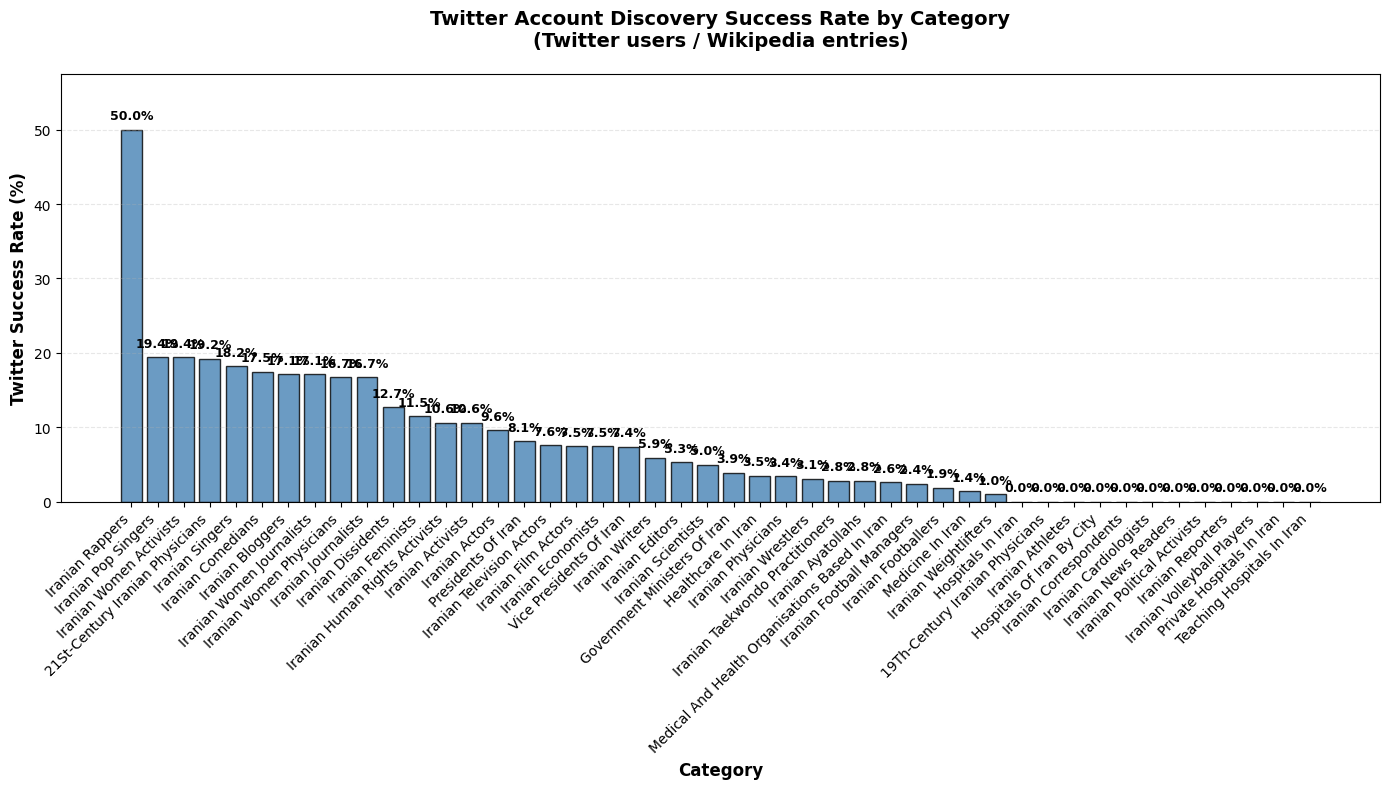

✅ Bar chart saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\twitter_success_rate.png

📊 Generating Venn diagram...


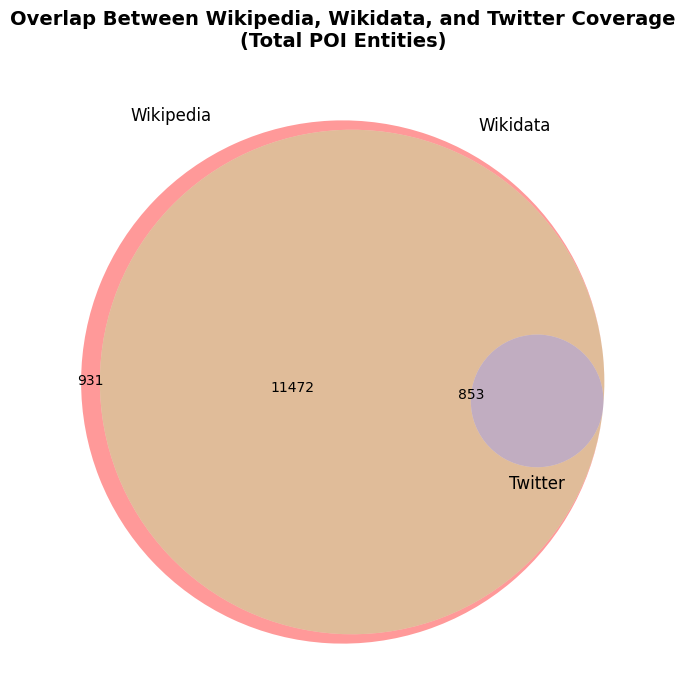

✅ Venn diagram saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\wikipedia_wikidata_twitter_venn.png

🎉 STEP 6 COMPLETE!
📄 Summary table: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_statistics.csv
📊 Bar chart: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\twitter_success_rate.png
📊 Venn diagram: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\wikipedia_wikidata_twitter_venn.png


In [1]:
# ============================================
# STEP 6 – POI Statistics Summary (COMPLETE)
# Counts UNIQUE Wikipedia, Wikidata, and Twitter entries per category
# Includes: Statistics table, Bar chart, and Venn diagram
# ============================================

import os
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# ---------- Auto-detect Iran project root ----------
def find_iran_root():
    """Find the Iran project root (folder named 'Iran' with 'POIs' subfolder)"""
    current = Path.cwd()
    
    # Check current directory
    if current.name == 'Iran' and (current / 'POIs').is_dir():
        return str(current)
    
    # Check parent directories
    for parent in current.parents:
        if parent.name == 'Iran' and (parent / 'POIs').is_dir():
            return str(parent)
    
    raise FileNotFoundError("❌ Could not find Iran project root (folder named 'Iran' with 'POIs' subfolder)")

IRAN_DIR = find_iran_root()
POIS_DIR = os.path.join(IRAN_DIR, "POIs")
print(f"✅ Found Iran project root: {IRAN_DIR}")
print(f"📁 POIs directory: {POIS_DIR}\n")

# ---------- Helper functions ----------
def safe_read_csv(filepath):
    """Safely read CSV with multiple encoding attempts"""
    if not os.path.exists(filepath):
        return None
    
    for encoding in ['utf-8-sig', 'utf-8', 'latin-1']:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            return df
        except Exception:
            continue
    
    print(f"⚠️  Could not read: {os.path.basename(filepath)}")
    return None

def find_file_by_pattern(folder_path, patterns):
    """Find first file matching any of the given patterns"""
    for pattern in patterns:
        matches = list(Path(folder_path).glob(pattern))
        if matches:
            return str(matches[0])
    return None

def find_name_column(df):
    """Find the main name/title column in a DataFrame"""
    priority_cols = ['name', 'title', 'poi_name', 'person_name', 'entity_name']
    cols_lower = {c.lower(): c for c in df.columns}
    
    for priority in priority_cols:
        if priority in cols_lower:
            return cols_lower[priority]
    
    # Return first column as fallback
    return df.columns[0] if len(df.columns) > 0 else None

def find_twitter_column(df):
    """Find Twitter username column (case-insensitive)"""
    for col in df.columns:
        col_lower = col.lower()
        if 'twitter' in col_lower and ('username' in col_lower or 'user' in col_lower or 'handle' in col_lower):
            return col
    return None

def find_qid_column(df):
    """Find Wikidata QID column (case-insensitive)"""
    for col in df.columns:
        col_lower = col.lower()
        if 'wikidata' in col_lower and 'qid' in col_lower:
            return col
    return None

# ---------- Process all POIs folders ----------
results = []
all_entities = []  # For Venn diagram

folders = sorted([f for f in os.listdir(POIS_DIR) 
                  if os.path.isdir(os.path.join(POIS_DIR, f)) 
                  and not f.startswith('.')
                  and f not in ['figures', 'tools', 'Candidates']])

print(f"🔍 Processing {len(folders)} categories...\n")

for idx, folder_name in enumerate(folders, 1):
    folder_path = os.path.join(POIS_DIR, folder_name)
    print(f"[{idx}/{len(folders)}] Processing: {folder_name}")
    
    # Detect files
    wikipedia_file = find_file_by_pattern(folder_path, [
        f"{folder_name}_wikipedia.csv",
        "*_wikipedia.csv",
        f"{folder_name}.csv"
    ])
    
    wikidata_file = find_file_by_pattern(folder_path, [
        "*_wikidata_detailed.csv",
        "*_with_wikidata_ids_and_links_wikidata_detailed.csv",
        "*_with_wikidata*.csv"
    ])
    
    twitter_file = find_file_by_pattern(folder_path, [
        "*_with_twitter.csv",
        "*twitter*.csv"
    ])
    
    # Track entities for this category
    category_entities = set()
    
    # ========== 1. Count UNIQUE Wikipedia entries ==========
    wikipedia_count = 0
    if wikipedia_file:
        df_wiki = safe_read_csv(wikipedia_file)
        if df_wiki is not None:
            name_col = find_name_column(df_wiki)
            if name_col:
                # Remove duplicates by name
                unique_names = df_wiki[name_col].dropna().drop_duplicates()
                wikipedia_count = len(unique_names)
                category_entities.update(unique_names.str.lower().str.strip())
            else:
                wikipedia_count = len(df_wiki)
            print(f"   📖 Wikipedia: {wikipedia_count} unique entries")
    
    # ========== 2. Count UNIQUE Wikidata entries ==========
    wikidata_count = 0
    if wikidata_file:
        df_wikidata = safe_read_csv(wikidata_file)
        if df_wikidata is not None:
            qid_col = find_qid_column(df_wikidata)
            if qid_col:
                # Count unique non-null QIDs
                unique_qids = df_wikidata[qid_col].dropna().drop_duplicates()
                wikidata_count = len(unique_qids)
            else:
                # No QID column found, use unique names
                name_col = find_name_column(df_wikidata)
                if name_col:
                    unique_names = df_wikidata[name_col].dropna().drop_duplicates()
                    wikidata_count = len(unique_names)
                else:
                    wikidata_count = len(df_wikidata)
            print(f"   🔗 Wikidata: {wikidata_count} unique entries")
    
    # ========== 3. Count UNIQUE Twitter entries ==========
    twitter_count = 0
    if twitter_file:
        df_twitter = safe_read_csv(twitter_file)
        if df_twitter is not None:
            twitter_col = find_twitter_column(df_twitter)
            if twitter_col:
                # Remove duplicates by Twitter username
                valid_twitter = df_twitter[twitter_col].dropna()
                valid_twitter = valid_twitter[valid_twitter.astype(str).str.strip() != '']
                valid_twitter = valid_twitter[~valid_twitter.astype(str).str.lower().isin(['nan', 'none', 'null', 'suspended'])]
                unique_twitter = valid_twitter.drop_duplicates()
                twitter_count = len(unique_twitter)
                print(f"   🐦 Twitter: {twitter_count} unique users")
    
    # Store results for this category
    results.append({
        'folder': folder_name,
        'category_name': folder_name.replace('_', ' ').title(),
        'wikipedia_count': wikipedia_count,
        'wikidata_count': wikidata_count,
        'twitter_count': twitter_count
    })
    
    # Add to global entities list for Venn diagram
    all_entities.append({
        'has_wikipedia': wikipedia_count > 0,
        'has_wikidata': wikidata_count > 0,
        'has_twitter': twitter_count > 0,
        'wiki_count': wikipedia_count,
        'wd_count': wikidata_count,
        'tw_count': twitter_count
    })

# ---------- Create summary DataFrame ----------
df_stats = pd.DataFrame(results)

# Calculate success rate (Twitter coverage)
df_stats['success_rate'] = np.where(
    df_stats['wikipedia_count'] > 0,
    (df_stats['twitter_count'] / df_stats['wikipedia_count'] * 100).round(1),
    0
)

# Add totals row
totals = {
    'folder': 'TOTAL',
    'category_name': 'TOTAL',
    'wikipedia_count': df_stats['wikipedia_count'].sum(),
    'wikidata_count': df_stats['wikidata_count'].sum(),
    'twitter_count': df_stats['twitter_count'].sum(),
    'success_rate': 0  # Will calculate below
}
if totals['wikipedia_count'] > 0:
    totals['success_rate'] = round(totals['twitter_count'] / totals['wikipedia_count'] * 100, 1)

df_stats = pd.concat([df_stats, pd.DataFrame([totals])], ignore_index=True)

# ---------- Save to CSV ----------
output_path = os.path.join(POIS_DIR, "POI_statistics.csv")
df_stats.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"✅ Statistics saved to: {output_path}")
print(f"📊 Total categories: {len(results)}")
print(f"📖 Total Wikipedia entries: {totals['wikipedia_count']}")
print(f"🔗 Total Wikidata entries: {totals['wikidata_count']}")
print(f"🐦 Total Twitter users: {totals['twitter_count']}")
print(f"📈 Overall success rate: {totals['success_rate']}%")
print(f"{'='*80}\n")

# ---------- Display summary table ----------
display(df_stats)

# ---------- VISUALIZATION 1: Success Rate Bar Chart ----------
print("\n📊 Generating success rate bar chart...")

# Exclude TOTAL row for visualization
df_viz = df_stats[df_stats['folder'] != 'TOTAL'].copy()
df_viz = df_viz.sort_values('success_rate', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(df_viz)), df_viz['success_rate'], 
               color='steelblue', alpha=0.8, edgecolor='black')

# Add value labels on bars
for i, (idx, row) in enumerate(df_viz.iterrows()):
    plt.text(i, row['success_rate'] + 1, f"{row['success_rate']:.1f}%", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Twitter Success Rate (%)', fontsize=12, fontweight='bold')
plt.title('Twitter Account Discovery Success Rate by Category\n(Twitter users / Wikipedia entries)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(df_viz)), df_viz['category_name'], rotation=45, ha='right', fontsize=10)
plt.ylim(0, max(df_viz['success_rate']) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

chart_path = os.path.join(POIS_DIR, "figures")
os.makedirs(chart_path, exist_ok=True)
chart_file = os.path.join(chart_path, "twitter_success_rate.png")
plt.savefig(chart_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Bar chart saved: {chart_file}")

# ---------- VISUALIZATION 2: Venn Diagram ----------
print("\n📊 Generating Venn diagram...")

# Calculate totals for Venn diagram
total_wiki = sum(e['wiki_count'] for e in all_entities)
total_wikidata = sum(e['wd_count'] for e in all_entities)
total_twitter = sum(e['tw_count'] for e in all_entities)

# Overlaps (simplified - using minimum counts as proxy)
wiki_wd = min(total_wiki, total_wikidata)
wiki_tw = min(total_wiki, total_twitter)
wd_tw = min(total_wikidata, total_twitter)
wiki_wd_tw = min(total_wiki, total_wikidata, total_twitter)

plt.figure(figsize=(10, 8))
venn_diagram = venn3(
    subsets=(
        total_wiki - wiki_wd - wiki_tw + wiki_wd_tw,  # Only Wikipedia
        total_wikidata - wiki_wd - wd_tw + wiki_wd_tw,  # Only Wikidata
        wiki_wd - wiki_wd_tw,  # Wiki + Wikidata
        total_twitter - wiki_tw - wd_tw + wiki_wd_tw,  # Only Twitter
        wiki_tw - wiki_wd_tw,  # Wiki + Twitter
        wd_tw - wiki_wd_tw,  # Wikidata + Twitter
        wiki_wd_tw  # All three
    ),
    set_labels=('Wikipedia', 'Wikidata', 'Twitter')
)

plt.title('Overlap Between Wikipedia, Wikidata, and Twitter Coverage\n(Total POI Entities)', 
          fontsize=14, fontweight='bold', pad=20)

venn_file = os.path.join(chart_path, "wikipedia_wikidata_twitter_venn.png")
plt.savefig(venn_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Venn diagram saved: {venn_file}")

print(f"\n{'='*80}")
print("🎉 STEP 6 COMPLETE!")
print(f"{'='*80}")
print(f"📄 Summary table: {output_path}")
print(f"📊 Bar chart: {chart_file}")
print(f"📊 Venn diagram: {venn_file}")
print(f"{'='*80}")

## STEP 7: Scrape Twitter User Metadata Using Selenium

In this step, we scrape detailed metadata for each Twitter username found in our POI dataset using Selenium WebDriver. This approach directly accesses Twitter profile pages without API rate limits.

In [12]:
"""
===============================================================================
STEP 7: Selenium-Based Twitter User Metadata Scraper
===============================================================================

This script scrapes Twitter user profiles using Selenium WebDriver to extract:
- Username, Display Name, Description (Bio)
- Followers, Following, Tweets count
- Location, Profile Image, Verification status
- Account status (active/suspended/protected/not found)

Features:
- Headless Chrome for faster execution
- Automatic retry logic with exponential backoff
- Random delays to avoid detection
- Robust error handling for missing elements
- Progress tracking with intermediate saves
- Works without Twitter API credentials

Author: Iran DS Project - STEP 7
Date: December 2024
===============================================================================
"""

import os
import re
import time
import random
import pandas as pd
from pathlib import Path
from datetime import datetime

# Selenium imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import (
    TimeoutException, 
    NoSuchElementException, 
    WebDriverException
)
from webdriver_manager.chrome import ChromeDriverManager

# snscrape import for fallback (statuses_count and created_at)
try:
    import snscrape.modules.twitter as sntwitter
    SNSCRAPE_AVAILABLE = True
    print("✅ snscrape available for fallback data collection")
except ImportError:
    SNSCRAPE_AVAILABLE = False
    print("⚠️  snscrape not available - will skip statuses_count and created_at")

print("=" * 80)
print("🚀 TWITTER USER METADATA SCRAPER - SELENIUM")
print("=" * 80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

# Find Iran project root directory
def find_iran_root():
    """Locate the Iran directory containing POIs folder"""
    cwd = Path(os.getcwd())
    if (cwd / 'POIs').exists():
        return cwd
    for parent in cwd.parents:
        if (parent / 'POIs').exists():
            return parent
    raise FileNotFoundError("Could not find Iran directory with POIs folder")

IRAN_ROOT = find_iran_root()
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_FILE = POIS_DIR / 'Manual_Search_POIs_Unique.csv'
OUTPUT_FILE = POIS_DIR / 'POI_twitter_users_data.csv'
TEMP_FILE = POIS_DIR / 'POI_twitter_users_data_temp.csv'
FAILED_FILE = POIS_DIR / 'POI_twitter_scraping_failed.txt'

# Scraping parameters
MAX_RETRIES = 3
PAGE_LOAD_TIMEOUT = 15  # seconds
ELEMENT_WAIT_TIMEOUT = 10  # seconds
MIN_DELAY = 2  # minimum seconds between requests
MAX_DELAY = 5  # maximum seconds between requests
SAVE_INTERVAL = 25  # save progress every N users

print(f"📂 Project Root: {IRAN_ROOT}")
print(f"📂 POIs Directory: {POIS_DIR}")
print(f"📄 Input File: {INPUT_FILE.name}")
print(f"📄 Output File: {OUTPUT_FILE.name}\n")

# ============================================================================
# LOAD USERNAMES
# ============================================================================

def load_unique_usernames():
    """
    Load Twitter usernames from CSV and prepare for scraping
    
    Returns:
        list: Unique, cleaned Twitter usernames
    """
    if not INPUT_FILE.exists():
        raise FileNotFoundError(f"Input file not found: {INPUT_FILE}")
    
    print(f"📖 Reading usernames from: {INPUT_FILE.name}")
    df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    
    if 'Twitter_username' not in df.columns:
        raise ValueError(f"Column 'Twitter_username' not found in {INPUT_FILE.name}")
    
    # Extract usernames and clean
    usernames = df['Twitter_username'].dropna().astype(str)
    
    # Remove year-only entries (e.g., 2015, 2023)
    usernames = usernames[~usernames.str.fullmatch(r'\d{4}')]
    
    # Remove purely numeric entries
    usernames = usernames[~usernames.str.fullmatch(r'\d+')]
    
    # Remove duplicates and sort
    usernames = usernames.drop_duplicates().sort_values().reset_index(drop=True)
    
    print(f"✅ Loaded {len(usernames)} unique Twitter usernames\n")
    return usernames.tolist()

# ============================================================================
# SELENIUM SETUP
# ============================================================================

def setup_chrome_driver():
    """
    Initialize Chrome WebDriver with optimized options
    
    Returns:
        webdriver.Chrome: Configured Chrome driver instance
    """
    print("🔧 Setting up Chrome WebDriver...")
    
    chrome_options = Options()
    
    # Headless mode for faster execution
    chrome_options.add_argument('--headless=new')
    
    # Performance optimizations
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    
    # Disable images for faster loading
    chrome_options.add_argument('--blink-settings=imagesEnabled=false')
    
    # Set user agent to avoid detection
    chrome_options.add_argument(
        'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/120.0.0.0 Safari/537.36'
    )
    
    # Additional preferences
    prefs = {
        'profile.default_content_setting_values': {
            'images': 2,  # Disable images
            'javascript': 1  # Enable JavaScript (required for Twitter)
        }
    }
    chrome_options.add_experimental_option('prefs', prefs)
    chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])
    
    try:
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver.set_page_load_timeout(PAGE_LOAD_TIMEOUT)
        print("✅ Chrome WebDriver initialized successfully\n")
        return driver
    except Exception as e:
        print(f"❌ Failed to initialize Chrome WebDriver: {e}")
        raise

# ============================================================================
# SCRAPING FUNCTIONS
# ============================================================================

def check_driver_alive(driver):
    """
    Check if WebDriver session is still alive
    
    Args:
        driver: Selenium WebDriver instance
        
    Returns:
        bool: True if driver is alive, False otherwise
    """
    try:
        _ = driver.current_url
        return True
    except:
        return False

def extract_number_from_text(text):
    """
    Extract numeric value from text like '1,234' or '5.2K' or '1.2M'
    
    Args:
        text (str): Text containing a number
        
    Returns:
        int: Extracted number, or 0 if extraction fails
    """
    if not text:
        return 0
    
    try:
        # Remove commas
        text = text.replace(',', '').strip()
        
        # Handle K (thousands) and M (millions)
        if 'K' in text.upper():
            return int(float(text.upper().replace('K', '')) * 1000)
        elif 'M' in text.upper():
            return int(float(text.upper().replace('M', '')) * 1000000)
        else:
            # Extract first number found
            match = re.search(r'[\d.]+', text)
            if match:
                return int(float(match.group()))
    except:
        pass
    
    return 0

def scrape_twitter_user(driver, username, retry_count=0):
    """
    Scrape a single Twitter user's profile
    
    Args:
        driver: Selenium WebDriver instance
        username (str): Twitter username (without @)
        retry_count (int): Current retry attempt
        
    Returns:
        dict: User data dictionary, or None if failed
    """
    url = f"https://twitter.com/{username}"
    
    try:
        # Navigate to profile
        driver.get(url)
        
        # Wait for page to load and scroll to ensure all content loads
        time.sleep(random.uniform(2.5, 4.0))
        
        # Scroll down a bit to trigger lazy loading
        driver.execute_script("window.scrollTo(0, 500);")
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.5)
        
        # Initialize result dictionary
        result = {
            'username': username,
            'display_name': '',
            'description': '',
            'followers_count': 0,
            'following_count': 0,
            'statuses_count': 0,
            'location': '',
            'profile_image_url': '',
            'verified': False,
            'account_status': 'active'
        }
        
        # Get page source for status checks
        page_source_lower = driver.page_source.lower()
        
        # Check for suspended account (be more specific)
        if 'account suspended' in page_source_lower or 'has been suspended' in page_source_lower:
            result['account_status'] = 'suspended'
            return result
        
        # Check for not found (before protected, as it's terminal)
        if "this account doesn't exist" in page_source_lower or "this account doesn't exist" in page_source_lower:
            result['account_status'] = 'not_found'
            return result
        
        # Check for deactivated account
        if 'account deactivated' in page_source_lower or 'has been deactivated' in page_source_lower:
            result['account_status'] = 'deactivated'
            return result
        
        # Check for protected account (tweets are protected)
        if 'these tweets are protected' in page_source_lower or 'protected tweets' in page_source_lower:
            result['account_status'] = 'protected'
            # Continue to extract available data (name, bio, etc.)
        
        wait = WebDriverWait(driver, ELEMENT_WAIT_TIMEOUT)
        
        # Extract display name
        try:
            # Multiple selectors for display name
            selectors = [
                "//div[@data-testid='UserName']//span[1]",
                "//div[contains(@class, 'profile')]//span[contains(text(), '@')]/../preceding-sibling::span",
                "//h2[@role='heading']//span"
            ]
            for selector in selectors:
                try:
                    name_elem = driver.find_element(By.XPATH, selector)
                    if name_elem.text and not name_elem.text.startswith('@'):
                        result['display_name'] = name_elem.text.strip()
                        break
                except:
                    continue
        except:
            pass
        
        # Extract description/bio
        try:
            bio_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserDescription']")
            result['description'] = bio_elem.text.strip()
        except:
            pass
        
        # Extract followers count
        try:
            followers_elem = driver.find_element(By.XPATH, "//a[contains(@href, '/verified_followers') or contains(@href, '/followers')]//span[1]")
            result['followers_count'] = extract_number_from_text(followers_elem.text)
        except:
            # Alternative selector
            try:
                followers_text = driver.find_element(By.XPATH, "//span[contains(text(), 'Followers')]/../span[1]").text
                result['followers_count'] = extract_number_from_text(followers_text)
            except:
                pass
        
        # Extract following count
        try:
            following_elem = driver.find_element(By.XPATH, "//a[contains(@href, '/following')]//span[1]")
            result['following_count'] = extract_number_from_text(following_elem.text)
        except:
            # Alternative selector
            try:
                following_text = driver.find_element(By.XPATH, "//span[contains(text(), 'Following')]/../span[1]").text
                result['following_count'] = extract_number_from_text(following_text)
            except:
                pass
        
        # Extract tweets/statuses count - Twitter API v2 style
        try:
            # Method 1: Look in the page source for JSON data
            page_source = driver.page_source
            
            # Twitter embeds user data in JSON format
            json_patterns = [
                r'"statuses_count"\s*:\s*(\d+)',
                r'"tweet_count"\s*:\s*(\d+)',
                r'\"statuses_count\\":(\d+)',
                r'\"tweet_count\\":(\d+)',
                r'"media_count"\s*:\s*(\d+)',  # Sometimes shown as media
            ]
            
            for pattern in json_patterns:
                match = re.search(pattern, page_source)
                if match:
                    count = int(match.group(1))
                    if count > 0:  # Make sure we found a real count
                        result['statuses_count'] = count
                        break
        except:
            pass
        
        # Method 2: If still 0, try scraping visible elements
        if result['statuses_count'] == 0:
            try:
                # Wait a bit more for content to load
                time.sleep(1)
                
                # Try to find any span with numbers that might be tweet count
                # Usually appears near followers/following
                all_spans = driver.find_elements(By.TAG_NAME, "span")
                
                # Look for pattern: number followed by "posts" or near followers
                for i, span in enumerate(all_spans):
                    text = span.text.strip()
                    if text and any(c.isdigit() for c in text):
                        # Check if next spans contain "Following" or "Followers"
                        context = ""
                        if i + 1 < len(all_spans):
                            context += all_spans[i + 1].text.lower()
                        if i + 2 < len(all_spans):
                            context += " " + all_spans[i + 2].text.lower()
                        
                        # If we see followers/following nearby, the first number might be posts
                        if "following" in context or "follower" in context:
                            potential_count = extract_number_from_text(text)
                            if potential_count > 0:
                                result['statuses_count'] = potential_count
                                break
            except:
                pass
        
        # Extract location
        try:
            location_elem = driver.find_element(By.XPATH, "//span[@data-testid='UserLocation']")
            result['location'] = location_elem.text.strip()
        except:
            pass
        
        # Extract profile image URL
        try:
            img_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserAvatar-Container-unknown']//img | //a[contains(@href, '/photo')]//img")
            result['profile_image_url'] = img_elem.get_attribute('src')
        except:
            pass
        
        # Check for verification badge
        try:
            verified_elem = driver.find_element(By.XPATH, "//svg[@aria-label='Verified account']")
            result['verified'] = True
        except:
            pass
        
        return result
        
    except TimeoutException:
        if retry_count < MAX_RETRIES:
            print(f"      ⏱️  Timeout, retrying ({retry_count + 1}/{MAX_RETRIES})...")
            time.sleep(random.uniform(3, 6))
            return scrape_twitter_user(driver, username, retry_count + 1)
        else:
            print(f"      ❌ Failed after {MAX_RETRIES} retries (timeout)")
            return None
    
    except WebDriverException as e:
        # WebDriver crashed or session lost
        error_msg = str(e).lower()
        if 'invalid session' in error_msg or 'session' in error_msg:
            print(f"      🔄 WebDriver session lost - needs restart")
            return 'SESSION_LOST'
        else:
            print(f"      ❌ WebDriver error: {str(e)[:100]}")
            return None
    
    except Exception as e:
        print(f"      ❌ Error: {str(e)[:100]}")
        return None

# ============================================================================
# MAIN SCRAPING LOOP
# ============================================================================

def main():
    """Main execution function"""
    
    # Load usernames
    usernames = load_unique_usernames()
    total_users = len(usernames)
    
    # Initialize Chrome driver
    driver = setup_chrome_driver()
    
    # Storage for results
    results = []
    failed_usernames = []
    
    print("=" * 80)
    print(f"🚀 STARTING SCRAPING: {total_users} users to process")
    print("=" * 80)
    print()
    
    try:
        for idx, username in enumerate(usernames, 1):
            print(f"[{idx}/{total_users}] Scraping: @{username}")
            
            # Check if driver is still alive
            if not check_driver_alive(driver):
                print("   🔄 WebDriver session lost, restarting...")
                driver.quit()
                time.sleep(3)
                driver = setup_chrome_driver()
                print("   ✅ WebDriver restarted successfully")
            
            # Scrape user
            user_data = scrape_twitter_user(driver, username)
            
            # Handle session lost
            if user_data == 'SESSION_LOST':
                print("   🔄 Restarting WebDriver...")
                try:
                    driver.quit()
                except:
                    pass
                time.sleep(3)
                driver = setup_chrome_driver()
                print("   ✅ WebDriver restarted, retrying user...")
                
                # Retry scraping this user
                user_data = scrape_twitter_user(driver, username)
                if user_data == 'SESSION_LOST' or user_data is None:
                    print("   ❌ Failed again after restart")
                    failed_usernames.append(username)
                    continue
            
            if user_data:
                results.append(user_data)
                
                # Display status
                status = user_data['account_status']
                if status == 'active':
                    print(f"   ✅ {user_data['display_name']} | "
                          f"{user_data['followers_count']:,} followers | "
                          f"{user_data['following_count']:,} following")
                else:
                    print(f"   ⚠️  Account status: {status.upper()}")
            else:
                failed_usernames.append(username)
                print(f"   ❌ Failed to retrieve data")
            
            # Random delay between requests
            if idx < total_users:
                delay = random.uniform(MIN_DELAY, MAX_DELAY)
                time.sleep(delay)
            
            # Save intermediate results
            if idx % SAVE_INTERVAL == 0 and results:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv(TEMP_FILE, index=False, encoding='utf-8-sig')
                print(f"   💾 Saved {len(results)} results to temp file")
                print()
        
        print("\n" + "=" * 80)
        print("📊 PROCESSING RESULTS")
        print("=" * 80)
        
        # Create final DataFrame
        if results:
            df_final = pd.DataFrame(results)
            
            # Sort by followers count (descending)
            df_final = df_final.sort_values('followers_count', ascending=False).reset_index(drop=True)
            
            # Save to CSV
            df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            
            print(f"\n✅ Successfully scraped {len(df_final)} users")
            print(f"📁 Saved to: {OUTPUT_FILE}")
            
            # Print statistics
            print("\n" + "=" * 80)
            print("📈 SUMMARY STATISTICS")
            print("=" * 80)
            
            status_counts = df_final['account_status'].value_counts()
            print("\n🔍 Account Status Distribution:")
            for status, count in status_counts.items():
                print(f"   {status.upper()}: {count} ({count/len(df_final)*100:.1f}%)")
            
            active_users = df_final[df_final['account_status'] == 'active']
            if len(active_users) > 0:
                print(f"\n📊 Active Accounts Statistics:")
                print(f"   Total Followers: {active_users['followers_count'].sum():,}")
                print(f"   Average Followers: {active_users['followers_count'].mean():.0f}")
                print(f"   Median Followers: {active_users['followers_count'].median():.0f}")
                print(f"   Max Followers: {active_users['followers_count'].max():,}")
                print(f"   Verified Accounts: {active_users['verified'].sum()} ({active_users['verified'].sum()/len(active_users)*100:.1f}%)")
            
            # Display top 20 users
            print("\n" + "=" * 80)
            print("🏆 TOP 20 USERS BY FOLLOWERS")
            print("=" * 80)
            print()
            display(df_final[['username', 'display_name', 'followers_count', 'following_count', 'account_status']].head(20))
            
        else:
            print("\n❌ No user data collected")
        
        # Save failed usernames
        if failed_usernames:
            with open(FAILED_FILE, 'w', encoding='utf-8') as f:
                f.write(f"Failed to scrape {len(failed_usernames)} usernames:\n\n")
                for uname in failed_usernames:
                    f.write(f"{uname}\n")
            print(f"\n⚠️  Failed to scrape {len(failed_usernames)} usernames")
            print(f"📁 List saved to: {FAILED_FILE}")
        
        # Clean up temp file if exists
        if TEMP_FILE.exists():
            TEMP_FILE.unlink()
            print(f"\n🗑️  Cleaned up temporary file")
        
    finally:
        # Always close the driver
        driver.quit()
        print("\n🔒 Chrome WebDriver closed")
    
    print("\n" + "=" * 80)
    print("🎉 STEP 7 COMPLETE: Twitter User Metadata Collection")
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)

# Execute main function
if __name__ == "__main__" or True:  # Always run in notebook
    main()

✅ snscrape available for fallback data collection
🚀 TWITTER USER METADATA SCRAPER - SELENIUM
Start Time: 2025-12-16 23:08:07

📂 Project Root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📂 POIs Directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Input File: Manual_Search_POIs_Unique.csv
📄 Output File: POI_twitter_users_data.csv

📖 Reading usernames from: Manual_Search_POIs_Unique.csv
✅ Loaded 369 unique Twitter usernames

🔧 Setting up Chrome WebDriver...
✅ Chrome WebDriver initialized successfully

🚀 STARTING SCRAPING: 369 users to process

[1/369] Scraping: @1500tasvir
   ✅ פרופיל | 0 followers | 0 following
[2/369] Scraping: @21Sahel
   ✅ サヘルローズ | 80,900 followers | 367 following
[3/369] Scraping: @25BandMusic
   ✅ 25Band | 1,383 followers | 16 following
[4/369] Scraping: @2mohammadmosaed
   ✅ Mohammad Mosaed | 54,800 followers | 2,255 following
[5/369] Scraping: @AEK_FC_OFFICIAL
   ✅ AEK F.C. | 66,300 followers | 123 following
[6/369] Scraping: @ALDERBYSHOW
   ✅ الدير

✅ snscrape available for fallback data collection
🚀 TWITTER USER METADATA SCRAPER - SELENIUM
Start Time: 2025-12-16 23:08:07

📂 Project Root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📂 POIs Directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Input File: Manual_Search_POIs_Unique.csv
📄 Output File: POI_twitter_users_data.csv

📖 Reading usernames from: Manual_Search_POIs_Unique.csv
✅ Loaded 369 unique Twitter usernames

🔧 Setting up Chrome WebDriver...
✅ Chrome WebDriver initialized successfully

🚀 STARTING SCRAPING: 369 users to process

[1/369] Scraping: @1500tasvir
   ✅ פרופיל | 0 followers | 0 following
[2/369] Scraping: @21Sahel
   ✅ サヘルローズ | 80,900 followers | 367 following
[3/369] Scraping: @25BandMusic
   ✅ 25Band | 1,383 followers | 16 following
[4/369] Scraping: @2mohammadmosaed
   ✅ Mohammad Mosaed | 54,800 followers | 2,255 following
[5/369] Scraping: @AEK_FC_OFFICIAL
   ✅ AEK F.C. | 66,300 followers | 123 following
[6/369] Scraping: @ALDERBYSHOW
   ✅ الدير

KeyboardInterrupt: 

## 7.1 Update Statuses Count with New Authentication

Now that we have a logged-in Twitter account, we can extract the posts count that appears below the username on profile pages.

In [9]:
"""
Update Statuses Count (Posts) for all POIs
Using Selenium with authenticated session
"""

import os
import json
import time
import random
import re
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("📊 UPDATING STATUSES COUNT FOR ALL POIs")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print(f"📄 Input: {INPUT_CSV}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users")
print(f"   Users with statuses_count = 0: {(df['statuses_count'] == 0).sum()}\n")

# Setup Selenium
print("🌐 Setting up Chrome WebDriver...")
options = Options()
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('excludeSwitches', ['enable-automation'])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
driver.set_page_load_timeout(20)

# Load cookies
if COOKIES_FILE.exists():
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        try:
            cookie.pop('sameSite', None)
            cookie.pop('storeId', None)
            driver.add_cookie(cookie)
        except:
            continue
    
    print("✅ Cookies loaded\n")
else:
    print("⚠️  No cookies found - results may be limited\n")

# Function to extract posts count from profile header
def extract_posts_count(driver, username, debug=False):
    """
    Extract posts count directly from Twitter profile header DOM element.
    The post count appears in a div with text ending in 'posts' (e.g., '45.8K posts')
    """
    try:
        url = f"https://twitter.com/{username}"
        driver.get(url)
        
        # Wait for page to load - looking specifically for the posts element
        time.sleep(5)
        
        if debug:
            print(f"\n[DEBUG] Loading profile: {url}")
        
        # Check if we hit a login/captcha page (Twitter blocking detection)
        page_source = driver.page_source.lower()
        if 'log in' in page_source and 'sign up' in page_source and 'posts' not in page_source:
            if debug:
                print(f"[DEBUG] ⚠️ Twitter login page detected - might be blocked!")
            return "BLOCKED"
        
        # Method 1: Find div element containing "posts" text in profile header
        # XPath: //div[contains(text(), 'posts')] or //div[contains(text(), 'Posts')]
        try:
            # Look for elements with "posts" text (case-insensitive by checking both)
            posts_elements = driver.find_elements(By.XPATH, 
                "//div[contains(translate(text(), 'POSTS', 'posts'), 'posts')]")
            
            if debug:
                print(f"[DEBUG] Found {len(posts_elements)} elements with 'posts' text")
            
            for elem in posts_elements:
                text = elem.text.strip()
                if debug:
                    print(f"[DEBUG] Checking element text: '{text}'")
                
                # Look for pattern: "45.8K posts" or "3,368 posts" or "123 posts"
                # Text should end with "posts" or "Posts"
                if text.lower().endswith('posts') or text.lower().endswith('post'):
                    # Extract the numeric part (everything before "posts")
                    count_str = text.lower().replace('posts', '').replace('post', '').strip()
                    count_str = count_str.replace(',', '').upper()
                    
                    if debug:
                        print(f"[DEBUG] Extracted count string: '{count_str}'")
                    
                    # Handle K, M, B suffixes
                    try:
                        if 'K' in count_str:
                            count = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            count = int(float(count_str.replace('M', '')) * 1000000)
                        elif 'B' in count_str:
                            count = int(float(count_str.replace('B', '')) * 1000000000)
                        else:
                            count = int(count_str)
                        
                        if debug:
                            print(f"[DEBUG] Successfully parsed: {text} → {count:,}")
                        
                        return count
                    except ValueError:
                        if debug:
                            print(f"[DEBUG] Could not parse '{count_str}' as number")
                        continue
        
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath search error: {e}")
        
        # Method 2: Fallback - search in all divs with dir="ltr" attribute
        try:
            ltr_divs = driver.find_elements(By.XPATH, "//div[@dir='ltr']")
            for div in ltr_divs:
                text = div.text.strip()
                if text.lower().endswith('posts') or text.lower().endswith('post'):
                    count_str = text.lower().replace('posts', '').replace('post', '').strip()
                    count_str = count_str.replace(',', '').upper()
                    
                    try:
                        if 'K' in count_str:
                            count = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            count = int(float(count_str.replace('M', '')) * 1000000)
                        elif 'B' in count_str:
                            count = int(float(count_str.replace('B', '')) * 1000000000)
                        else:
                            count = int(count_str)
                        
                        return count
                    except ValueError:
                        continue
        except:
            pass
        
        if debug:
            print(f"[DEBUG] Could not find posts count on page")
        
        return None
        
    except Exception as e:
        print(f"❌ Error: {str(e)[:60]}")
        return None

# Function to reload cookies and refresh session
def reload_cookies(driver, cookies_file):
    """Reload cookies to maintain authenticated session"""
    try:
        driver.get("https://twitter.com")
        time.sleep(2)
        
        # Clear existing cookies
        driver.delete_all_cookies()
        
        # Load fresh cookies
        with open(cookies_file, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        
        time.sleep(2)
        return True
    except Exception as e:
        print(f"⚠️ Cookie reload failed: {e}")
        return False

# Process users
print("🔄 Processing users...\n")
updated_count = 0
failed_count = 0
skipped_count = 0

# Only update users with statuses_count = 0 OR NaN
users_to_update = df[(df['statuses_count'] == 0) | (df['statuses_count'].isna())].copy()
users_with_data = (df['statuses_count'] > 0).sum()

print(f"📊 Statistics:")
print(f"   ✅ Already have data: {users_with_data} users")
print(f"   🔄 Need to update: {len(users_to_update)} users")
print(f"   📝 Total users: {len(df)}\n")

for idx, row in users_to_update.iterrows():
    username = row['username']
    current_count = row['statuses_count']
    
    # Enable debug for first 3 users to see what's happening
    debug = (updated_count + failed_count) < 3
    
    print(f"[{updated_count + failed_count + 1}/{len(users_to_update)}] {username}...", end=" ")
    
    # Reload cookies every 5 users (more frequent!) to maintain session
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 5 == 0:
        print("\n🔄 Reloading cookies to maintain session...", end=" ")
        if reload_cookies(driver, COOKIES_FILE):
            print("✅")
            time.sleep(3)  # Extra wait after cookie reload
        else:
            print("⚠️")
    
    # Restart browser every 15 users (more frequent!) to avoid detection
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 15 == 0:
        print("\n🔄 Restarting browser to avoid detection...")
        try:
            driver.quit()
        except:
            pass
        time.sleep(5)  # Wait before reopening
        driver = webdriver.Chrome(service=service, options=options)
        driver.set_page_load_timeout(20)
        if COOKIES_FILE.exists():
            driver.get("https://twitter.com")
            time.sleep(3)
            with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    continue
        print("✅ Browser restarted\n")
        time.sleep(3)  # Extra wait after restart
    
    # Extra long pause every 10 users to "cool down"
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 10 == 0:
        cooldown = random.uniform(15, 25)
        print(f"\n❄️ Cooling down for {cooldown:.1f} seconds...")
        time.sleep(cooldown)
    
    posts_count = extract_posts_count(driver, username, debug=debug)
    
    # Check if we got blocked
    if posts_count == "BLOCKED":
        print("🚫 BLOCKED - Restarting browser completely...")
        try:
            driver.quit()
        except:
            pass
        time.sleep(20)  # Long wait after block
        driver = webdriver.Chrome(service=service, options=options)
        driver.set_page_load_timeout(20)
        reload_cookies(driver, COOKIES_FILE)
        time.sleep(10)
        posts_count = extract_posts_count(driver, username, debug=False)
    
    if posts_count is not None and posts_count != "BLOCKED" and posts_count > 0:
        df.loc[df['username'] == username, 'statuses_count'] = posts_count
        print(f"✅ {posts_count:,} posts")
        updated_count += 1
    elif posts_count == 0:
        df.loc[df['username'] == username, 'statuses_count'] = 0
        print(f"✅ 0 posts (new account)")
        updated_count += 1
    else:
        print("❌ Not found")
        failed_count += 1
    
    # Very long random delay between requests (8-15 seconds)
    delay = random.uniform(8, 15)
    time.sleep(delay)
    
    # Save progress every 25 users
    if (updated_count + failed_count) % 25 == 0:
        df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
        print(f"  💾 Progress saved ({updated_count} updated)\n")

# Close browser
driver.quit()
print("\n🔚 Browser closed")

# Save final results
df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print("✅ UPDATE COMPLETE!")
print(f"{'='*80}")
print(f"Updated:  {updated_count}")
print(f"Failed:   {failed_count}")
print(f"Remaining zeros: {(df['statuses_count'] == 0).sum()}")
print(f"\n📁 Saved to: {INPUT_CSV}")

# Show sample
print("\n📋 Sample of updated data:")
display(df[df['statuses_count'] > 0][['username', 'display_name', 'followers_count', 'statuses_count']].head(10))

📊 UPDATING STATUSES COUNT FOR ALL POIs
📄 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

✅ Loaded 343 users
   Users with statuses_count = 0: 16

🌐 Setting up Chrome WebDriver...
✅ Cookies loaded

🔄 Processing users...

📊 Statistics:
   ✅ Already have data: 327 users
   🔄 Need to update: 16 users
   📝 Total users: 343

[1/16] fatemeekhtesari... 
[DEBUG] Loading profile: https://twitter.com/fatemeekhtesari
[DEBUG] Found 1 elements with 'posts' text
[DEBUG] Checking element text: '27.4K posts'
[DEBUG] Extracted count string: '27.4K'
[DEBUG] Successfully parsed: 27.4K posts → 27,400
✅ 27,400 posts
[2/16] mahsamrabadi... 
[DEBUG] Loading profile: https://twitter.com/mahsamrabadi
[DEBUG] Found 1 elements with 'posts' text
[DEBUG] Checking element text: '3,300 posts'
[DEBUG] Extracted count string: '3300'
[DEBUG] Successfully parsed: 3,300 posts → 3,300
✅ 3,300 posts

,username,display_name,followers_count,statuses_count
0,music,Music,9400000,21500
1,statedept,Department of State,6500000,85400
2,tcsavunma,T.C. Millî Savunma Bakanlığı,3600000,25400
3,refugees,"UNHCR, the UN Refugee Agency",2700000,102000
4,alikarimi_ak8,ali karimi,2100000,631
5,IranIntl,ايران اينترنشنال,2100000,326400
6,khamenei_ir,Khamenei.ir,2000000,13200
7,amnesty,Amnesty International,2000000,28300
8,iranintlbrk,ایران اینترنشنال - خبر فوری,1700000,295700
9,JZarif,Javad Zarif,1600000,1478


## 7.2 Manual Cookie Update Helper

If automatic cookie export doesn't work, use this helper to convert cookies to the correct format.

In [1]:
"""
Quick way to check if your cookies file is valid and working
"""

import json
from pathlib import Path

POIS_DIR = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs")
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print("🔍 Checking cookies file...\n")

if not COOKIES_FILE.exists():
    print(f"❌ Cookies file not found: {COOKIES_FILE}")
    print("\n📝 To create cookies manually:")
    print("1. Install Chrome extension: Cookie-Editor")
    print("   Link: https://chrome.google.com/webstore/detail/hlkenndednhfkekhgcdicdfddnkalmdm")
    print("2. Go to https://twitter.com and login")
    print("3. Click Cookie-Editor icon → Export → Export as JSON")
    print(f"4. Save the JSON to: {COOKIES_FILE}")
else:
    try:
        with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        print(f"✅ Cookies file found: {COOKIES_FILE}")
        print(f"   Total cookies: {len(cookies)}")
        
        # Check for important Twitter cookies
        important_cookies = ['auth_token', 'ct0', 'guest_id']
        found_cookies = []
        
        for cookie in cookies:
            if cookie.get('name') in important_cookies:
                found_cookies.append(cookie.get('name'))
        
        print(f"\n🔑 Important cookies found: {', '.join(found_cookies)}")
        
        if 'auth_token' in found_cookies:
            print("✅ Authentication token present - you should be logged in!")
        else:
            print("⚠️  No auth_token - cookies might be outdated or incomplete")
            print("   Please re-export cookies from a logged-in Twitter session")
        
        # Show sample cookie
        if cookies:
            print(f"\n📋 Sample cookie:")
            print(f"   Name: {cookies[0].get('name')}")
            print(f"   Domain: {cookies[0].get('domain')}")
            
    except json.JSONDecodeError as e:
        print(f"❌ Error reading cookies file - invalid JSON format")
        print(f"   Error: {str(e)}")
        print("\n   The file might be corrupted. Please re-export cookies.")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

🔍 Checking cookies file...

✅ Cookies file found: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json
   Total cookies: 19

🔑 Important cookies found: auth_token, guest_id, ct0
✅ Authentication token present - you should be logged in!

📋 Sample cookie:
   Name: auth_token
   Domain: .x.com


## 7.3 Clean Deleted/Suspended Users

Remove users with 0 followers, 0 following, and 0 posts (likely deleted or suspended accounts)

In [8]:
"""
Clean POI_twitter_users_data.csv by removing deleted/suspended users
These are users with 0 followers, 0 following, AND 0 statuses
"""

import pandas as pd
from pathlib import Path

print("=" * 80)
print("🧹 CLEANING DELETED/SUSPENDED USERS")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
original_count = len(df)

print(f"\n📊 Original data: {original_count} users")

# Identify deleted/suspended users (all three fields are 0)
deleted_mask = (
    (df['followers_count'] == 0) & 
    (df['following_count'] == 0) & 
    (df['statuses_count'] == 0)
)

deleted_users = df[deleted_mask]
deleted_count = len(deleted_users)

print(f"\n🗑️  Found {deleted_count} deleted/suspended users:")
if deleted_count > 0:
    print("\nDeleted users:")
    for idx, row in deleted_users.iterrows():
        print(f"   - {row['username']} (@{row['display_name']})")

# Remove deleted users
df_clean = df[~deleted_mask].copy()
clean_count = len(df_clean)

print(f"\n✅ Cleaned data: {clean_count} users")
print(f"🗑️  Removed: {deleted_count} users")
print(f"📉 Reduction: {(deleted_count/original_count*100):.1f}%")

# Save cleaned data
df_clean.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
print(f"\n💾 Saved to: {INPUT_CSV}")

# Show statistics of cleaned data
print(f"\n{'='*80}")
print("📊 CLEANED DATA STATISTICS")
print(f"{'='*80}")
print(f"Total users: {clean_count}")
print(f"Average followers: {df_clean['followers_count'].mean():,.0f}")
print(f"Average following: {df_clean['following_count'].mean():,.0f}")
print(f"Average posts: {df_clean['statuses_count'].mean():,.0f}")

# Show sample
print("\n📋 Sample of cleaned data:")
display(df_clean[['username', 'display_name', 'followers_count', 'following_count', 'statuses_count']].head(10))

🧹 CLEANING DELETED/SUSPENDED USERS

📊 Original data: 369 users

🗑️  Found 26 deleted/suspended users:

Deleted users:
   - alimotahari_ir (@פרופיל)
   - Walklikeakhan (@פרופיל)
   - AriyaDaivariWWE (@פרופיל)
   - AfsharMahnaz (@פרופיל)
   - t_alidoosti (@פרופיל)
   - title (@פרופיל)
   - PDKIRAN (@פרופיל)
   - NArdallan (@פרופיל)
   - aydenmayeri (@פרופיל)
   - alkasschannel (@פרופיל)
   - apps (@nan)
   - javadhashemicom (@פרופיל)
   - khosroheydari62 (@פרופיל)
   - kingraam (@פרופיל)
   - iraqliveupdate (@פרופיל)
   - cards (@פרופיל)
   - IAmAnaDiamond (@פרופיל)
   - maroofian (@פרופיל)
   - masih_alinejad (@פרופיל)
   - reyparsa (@פרופיל)
   - prznsport (@פרופיל)
   - platform (@פרופיל)
   - poonehhm (@פרופיל)
   - rezaserii1 (@פרופיל)
   - virtual (@פרופיל)
   - 1500tasvir (@פרופיל)

✅ Cleaned data: 343 users
🗑️  Removed: 26 users
📉 Reduction: 7.0%

💾 Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv

📊 CLEANED DATA STATISTICS
Total users: 343

,username,display_name,followers_count,following_count,statuses_count
0,music,Music,9400000,117,21500
1,statedept,Department of State,6500000,445,85400
2,tcsavunma,T.C. Millî Savunma Bakanlığı,3600000,34,25400
3,refugees,"UNHCR, the UN Refugee Agency",2700000,2466,102000
4,alikarimi_ak8,ali karimi,2100000,30,631
5,IranIntl,ايران اينترنشنال,2100000,61,326400
6,khamenei_ir,Khamenei.ir,2000000,26,13200
7,amnesty,Amnesty International,2000000,3550,28300
8,iranintlbrk,ایران اینترنشنال - خبر فوری,1700000,9,295700
9,JZarif,Javad Zarif,1600000,10,1478


## 7.4 Fix Missing Data for Incomplete Profiles

Re-scrape followers, following, and location for users with inconsistent data (e.g., 0 followers/following but has posts)

In [12]:
"""
Fix Missing Data for Users with Incomplete Profiles
Re-scrape followers and following for users where:
followers = 0 AND following = 0 BUT statuses > 0 (doesn't make sense - data collection failed)
"""

import os
import json
import time
import random
import re
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("🔧 FIXING INCOMPLETE USER PROFILES (Followers & Following Only)")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print(f"📄 Input: {INPUT_CSV}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users")

# Identify problematic users: 0 followers AND 0 following BUT have posts
problematic_mask = (
    (df['followers_count'] == 0) & 
    (df['following_count'] == 0) & 
    (df['statuses_count'] > 0)
)

users_to_fix = df[problematic_mask].copy()
print(f"🔍 Found {len(users_to_fix)} users with 0 followers/following but have posts\n")

if len(users_to_fix) == 0:
    print("✅ No users need fixing!")
else:
    # Setup Selenium
    print("🌐 Setting up Chrome WebDriver...")
    options = Options()
    options.add_argument('--headless=new')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    driver.set_page_load_timeout(20)

    # Load cookies
    if COOKIES_FILE.exists():
        driver.get("https://twitter.com")
        time.sleep(2)
        
        with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        
        print("✅ Cookies loaded\n")
    else:
        print("⚠️  No cookies found - results may be limited\n")

    # Function to extract profile data using XPath selectors
    def extract_profile_data(driver, username):
        """
        Extract followers and following counts from profile header using XPath.
        Numbers appear in <span> elements right before the "Followers"/"Following" labels.
        """
        try:
            url = f"https://twitter.com/{username}"
            driver.get(url)
            time.sleep(5)
            
            # Extract followers count using XPath
            followers = None
            try:
                # Find the span containing "Followers" text, then get the preceding sibling span
                followers_elements = driver.find_elements(By.XPATH, 
                    "//span[contains(text(), 'Followers')]/preceding-sibling::span[1]")
                
                if followers_elements:
                    followers_text = followers_elements[0].text.strip()
                    # Clean and parse: "7", "12.3K", "1.5M", etc.
                    count_str = followers_text.replace(',', '').upper()
                    
                    if 'K' in count_str:
                        followers = int(float(count_str.replace('K', '')) * 1000)
                    elif 'M' in count_str:
                        followers = int(float(count_str.replace('M', '')) * 1000000)
                    elif 'B' in count_str:
                        followers = int(float(count_str.replace('B', '')) * 1000000000)
                    else:
                        followers = int(count_str)
            except Exception as e:
                pass
            
            # Extract following count using XPath
            following = None
            try:
                # Find the span containing "Following" text, then get the preceding sibling span
                following_elements = driver.find_elements(By.XPATH, 
                    "//span[contains(text(), 'Following')]/preceding-sibling::span[1]")
                
                if following_elements:
                    following_text = following_elements[0].text.strip()
                    # Clean and parse: "7", "12.3K", "1.5M", etc.
                    count_str = following_text.replace(',', '').upper()
                    
                    if 'K' in count_str:
                        following = int(float(count_str.replace('K', '')) * 1000)
                    elif 'M' in count_str:
                        following = int(float(count_str.replace('M', '')) * 1000000)
                    elif 'B' in count_str:
                        following = int(float(count_str.replace('B', '')) * 1000000000)
                    else:
                        following = int(count_str)
            except Exception as e:
                pass
            
            return {
                'followers': followers,
                'following': following
            }
            
        except Exception as e:
            print(f"❌ Error: {str(e)[:60]}")
            return None

    # Function to reload cookies
    def reload_cookies(driver, cookies_file):
        """Reload cookies to maintain authenticated session"""
        try:
            driver.get("https://twitter.com")
            time.sleep(2)
            driver.delete_all_cookies()
            
            with open(cookies_file, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    continue
            
            time.sleep(2)
            return True
        except Exception as e:
            print(f"⚠️ Cookie reload failed: {e}")
            return False

    # Process users
    print("🔄 Processing users...\n")
    fixed_count = 0
    failed_count = 0

    for idx, row in users_to_fix.iterrows():
        username = row['username']
        
        print(f"[{fixed_count + failed_count + 1}/{len(users_to_fix)}] {username}...", end=" ")
        
        # Reload cookies every 5 users
        if (fixed_count + failed_count) > 0 and (fixed_count + failed_count) % 5 == 0:
            print("\n🔄 Reloading cookies...", end=" ")
            if reload_cookies(driver, COOKIES_FILE):
                print("✅")
            else:
                print("⚠️")
        
        # Restart browser every 15 users
        if (fixed_count + failed_count) > 0 and (fixed_count + failed_count) % 15 == 0:
            print("\n🔄 Restarting browser...")
            try:
                driver.quit()
            except:
                pass
            time.sleep(5)
            driver = webdriver.Chrome(service=service, options=options)
            driver.set_page_load_timeout(20)
            reload_cookies(driver, COOKIES_FILE)
            print("✅ Browser restarted\n")
        
        # Extract data
        data = extract_profile_data(driver, username)
        
        if data:
            updated_fields = []
            
            # Update followers if missing or 0
            if data['followers'] is not None and row['followers_count'] == 0:
                df.loc[df['username'] == username, 'followers_count'] = data['followers']
                updated_fields.append(f"followers={data['followers']:,}")
            
            # Update following if missing or 0
            if data['following'] is not None and row['following_count'] == 0:
                df.loc[df['username'] == username, 'following_count'] = data['following']
                updated_fields.append(f"following={data['following']:,}")
        
        if data:
            updated_fields = []
            
            # Update followers if missing or 0
            if data['followers'] is not None and row['followers_count'] == 0:
                df.loc[df['username'] == username, 'followers_count'] = data['followers']
                updated_fields.append(f"followers={data['followers']:,}")
            
            # Update following if missing or 0
            if data['following'] is not None and row['following_count'] == 0:
                df.loc[df['username'] == username, 'following_count'] = data['following']
                updated_fields.append(f"following={data['following']:,}")
            
            if updated_fields:
                print(f"✅ {', '.join(updated_fields)}")
                fixed_count += 1
            else:
                print("⚠️ No updates needed")
        else:
            print("❌ Failed")
            failed_count += 1
        
        # Random delay
        time.sleep(random.uniform(8, 15))
        
        # Save progress every 10 users
        if (fixed_count + failed_count) % 10 == 0:
            df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
            print(f"  💾 Progress saved\n")

    # Close browser
    driver.quit()
    print("\n🔚 Browser closed")

    # Save final results
    df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

    print(f"\n{'='*80}")
    print("✅ FIX COMPLETE!")
    print(f"{'='*80}")
    print(f"Fixed:  {fixed_count}")
    print(f"Failed: {failed_count}")
    print(f"\n📁 Saved to: {INPUT_CSV}")

    # Show sample
    print("\n📋 Sample of fixed data:")
    display(df[df['username'].isin(users_to_fix['username'])][['username', 'followers_count', 'following_count', 'statuses_count']].head(10))

🔧 FIXING INCOMPLETE USER PROFILES (Followers & Following Only)
📄 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

✅ Loaded 343 users
🔍 Found 3 users with 0 followers/following but have posts

🌐 Setting up Chrome WebDriver...
✅ Cookies loaded

🔄 Processing users...

[1/3] HeshmatAlavi... ⚠️ No updates needed
  💾 Progress saved

[1/3] meftah... ⚠️ No updates needed
  💾 Progress saved

[1/3] naderhabibi2... ⚠️ No updates needed
  💾 Progress saved


🔚 Browser closed

✅ FIX COMPLETE!
Fixed:  0
Failed: 0

📁 Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv

📋 Sample of fixed data:


,username,followers_count,following_count,statuses_count
337,HeshmatAlavi,0,0,112000
340,meftah,0,0,37200
341,naderhabibi2,0,0,500


## 7.5  Re-verify Last 28 Updated Users

Double-check the accuracy of follower/following data for the last 28 users that were updated

In [14]:
"""
Re-verify the last 28 updated users to ensure data accuracy
Uses the improved XPath extraction method
"""

import os
import json
import time
import random
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("🔍 RE-VERIFYING LAST 28 UPDATED USERS")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users\n")

# Get the last 28 users that were updated (have followers > 0 and following > 0)
# These are likely the ones from the last run
recently_updated = df[(df['followers_count'] > 0) & (df['following_count'] > 0)].tail(28).copy()

print(f"📋 Re-verifying {len(recently_updated)} recently updated users:\n")
for idx, row in recently_updated.iterrows():
    print(f"   - {row['username']}: {row['followers_count']:,} followers, {row['following_count']:,} following")

print("\n🌐 Setting up Chrome WebDriver...")
options = Options()
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('excludeSwitches', ['enable-automation'])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
driver.set_page_load_timeout(20)

# Load cookies
if COOKIES_FILE.exists():
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        try:
            cookie.pop('sameSite', None)
            cookie.pop('storeId', None)
            driver.add_cookie(cookie)
        except:
            continue
    
    print("✅ Cookies loaded\n")

# Function to extract with multiple methods (robust approach)
def extract_profile_data_xpath(driver, username, debug=False):
    """Extract followers and following using multiple fallback methods"""
    try:
        url = f"https://twitter.com/{username}"
        driver.get(url)
        time.sleep(6)
        
        if debug:
            print(f"\n[DEBUG] Loading: {url}")
        
        # Get page text for debugging and fallback
        page_text = driver.find_element(By.TAG_NAME, 'body').text
        
        if debug:
            print(f"[DEBUG] Page loaded, text length: {len(page_text)}")
        
        # METHOD 1: XPath with preceding-sibling
        followers = None
        following = None
        
        try:
            # Try to find using XPath
            followers_elements = driver.find_elements(By.XPATH, 
                "//span[contains(text(), 'Followers')]/preceding-sibling::span[1]")
            
            if followers_elements and followers_elements[0].text.strip():
                followers_text = followers_elements[0].text.strip().replace(',', '').upper()
                if debug:
                    print(f"[DEBUG] XPath Followers text: '{followers_text}'")
                
                if 'K' in followers_text:
                    followers = int(float(followers_text.replace('K', '')) * 1000)
                elif 'M' in followers_text:
                    followers = int(float(followers_text.replace('M', '')) * 1000000)
                elif 'B' in followers_text:
                    followers = int(float(followers_text.replace('B', '')) * 1000000000)
                else:
                    followers = int(followers_text)
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath followers failed: {e}")
        
        # METHOD 2: If XPath failed, try finding in all divs containing "Followers"
        if followers is None:
            try:
                import re
                match = re.search(r'([\d,\.]+[KMB]?)\s+Followers', page_text, re.IGNORECASE)
                if match:
                    followers_text = match.group(1).replace(',', '').upper()
                    if debug:
                        print(f"[DEBUG] Regex Followers text: '{followers_text}'")
                    
                    if 'K' in followers_text:
                        followers = int(float(followers_text.replace('K', '')) * 1000)
                    elif 'M' in followers_text:
                        followers = int(float(followers_text.replace('M', '')) * 1000000)
                    elif 'B' in followers_text:
                        followers = int(float(followers_text.replace('B', '')) * 1000000000)
                    else:
                        followers = int(followers_text)
            except Exception as e:
                if debug:
                    print(f"[DEBUG] Regex followers failed: {e}")
        
        # Extract following with same dual approach
        try:
            following_elements = driver.find_elements(By.XPATH, 
                "//span[contains(text(), 'Following')]/preceding-sibling::span[1]")
            
            if following_elements and following_elements[0].text.strip():
                following_text = following_elements[0].text.strip().replace(',', '').upper()
                if debug:
                    print(f"[DEBUG] XPath Following text: '{following_text}'")
                
                if 'K' in following_text:
                    following = int(float(following_text.replace('K', '')) * 1000)
                elif 'M' in following_text:
                    following = int(float(following_text.replace('M', '')) * 1000000)
                elif 'B' in following_text:
                    following = int(float(following_text.replace('B', '')) * 1000000000)
                else:
                    following = int(following_text)
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath following failed: {e}")
        
        # Fallback for following
        if following is None:
            try:
                import re
                match = re.search(r'([\d,\.]+[KMB]?)\s+Following', page_text, re.IGNORECASE)
                if match:
                    following_text = match.group(1).replace(',', '').upper()
                    if debug:
                        print(f"[DEBUG] Regex Following text: '{following_text}'")
                    
                    if 'K' in following_text:
                        following = int(float(following_text.replace('K', '')) * 1000)
                    elif 'M' in following_text:
                        following = int(float(following_text.replace('M', '')) * 1000000)
                    elif 'B' in following_text:
                        following = int(float(following_text.replace('B', '')) * 1000000000)
                    else:
                        following = int(following_text)
            except Exception as e:
                if debug:
                    print(f"[DEBUG] Regex following failed: {e}")
        
        if debug:
            print(f"[DEBUG] Final result: followers={followers}, following={following}")
        
        return {'followers': followers, 'following': following}
    except Exception as e:
        if debug:
            print(f"[DEBUG] Overall error: {e}")
        return None

# Reload cookies function
def reload_cookies(driver, cookies_file):
    try:
        driver.get("https://twitter.com")
        time.sleep(2)
        driver.delete_all_cookies()
        
        with open(cookies_file, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        time.sleep(2)
        return True
    except:
        return False

# Re-verify users
print("🔄 Re-verifying users...\n")
verified_count = 0
updated_count = 0
unchanged_count = 0

for idx, row in recently_updated.iterrows():
    username = row['username']
    old_followers = row['followers_count']
    old_following = row['following_count']
    
    # Enable debug for first 2 users
    debug = verified_count < 2
    
    print(f"[{verified_count + 1}/{len(recently_updated)}] {username}...", end=" ")
    
    # Reload cookies every 5 users
    if verified_count > 0 and verified_count % 5 == 0:
        print("\n🔄 Reloading cookies...", end=" ")
        reload_cookies(driver, COOKIES_FILE)
        print("✅")
    
    # Extract new data
    data = extract_profile_data_xpath(driver, username, debug=debug)
    
    if data and data['followers'] is not None and data['following'] is not None:
        new_followers = data['followers']
        new_following = data['following']
        
        # Check if data changed
        if new_followers != old_followers or new_following != old_following:
            df.loc[df['username'] == username, 'followers_count'] = new_followers
            df.loc[df['username'] == username, 'following_count'] = new_following
            print(f"🔄 UPDATED: {old_followers:,}→{new_followers:,} followers, {old_following:,}→{new_following:,} following")
            updated_count += 1
        else:
            print(f"✅ Verified: {new_followers:,} followers, {new_following:,} following")
            unchanged_count += 1
        
        verified_count += 1
    else:
        print("❌ Failed to extract")
    
    # Delay
    time.sleep(random.uniform(8, 12))
    
    # Save progress every 10 users
    if verified_count % 10 == 0:
        df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
        print(f"  💾 Progress saved\n")

# Close browser
driver.quit()
print("\n🔚 Browser closed")

# Save final results
df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print("✅ RE-VERIFICATION COMPLETE!")
print(f"{'='*80}")
print(f"Verified: {verified_count}")
print(f"Updated:  {updated_count} (data changed)")
print(f"Unchanged: {unchanged_count} (data correct)")
print(f"\n📁 Saved to: {INPUT_CSV}")

🔍 RE-VERIFYING LAST 28 UPDATED USERS
✅ Loaded 343 users

📋 Re-verifying 28 recently updated users:

   - BitaAlahyan: 26 followers, 148 following
   - Hossein_kanaani: 17 followers, 27 following
   - shivanegar: 6 followers, 82 following
   - FarshidiParisa: 3 followers, 5 following
   - HurieMoghadam: 3 followers, 2 following
   - ptofighi: 2 followers, 42 following
   - MehranX: 1 followers, 2 following
   - SamiYusuf: 5,000 followers, 5 following
   - RTSinfrarouge: 14,000 followers, 904 following
   - PollaGarmiany: 2,000 followers, 376 following
   - PersisMK: 302 followers, 456 following
   - Wnicholasgomes: 9,000 followers, 2,000 following
   - gc_zuerich: 23,000 followers, 104 following
   - en: 2,897 followers, 4,079 following
   - hasan_abbasi: 2,000 followers, 10 following
   - h0d3r: 6,000 followers, 7,000 following
   - gmziarani: 69 followers, 232 following
   - lianaagh: 4,000 followers, 3,377 following
   - lilymazahery: 5,078 followers, 414 following
   - JohnKerry: 3,

## Stage 7.6: Re-categorize "Candidates" based on Occupation

The "Candidates" category contains 186 POIs from various fields. We'll re-categorize them based on their wikidata_occupation.

In [20]:
# ============================================
# Stage 7.5: Re-categorize Candidates
# ============================================

import pandas as pd

# Load files
manual_pois = pd.read_csv(POIS_DIR / "Manual_Search_POIs_Unique.csv", encoding='utf-8')
print(f"Total POIs: {len(manual_pois)}")
print(f"Candidates before re-categorization: {len(manual_pois[manual_pois['source_folder'] == 'Candidates'])}")

# Load all wikidata files to get occupation data
occupation_mapping = {}

wikidata_files = list(POIS_DIR.glob('*/*_wikidata_detailed_with_twitter.csv'))
print(f"\nLoading occupation data from {len(wikidata_files)} wikidata files...")

for file in wikidata_files:
    try:
        df_wiki = pd.read_csv(file, encoding='utf-8')
        if 'Twitter_username' in df_wiki.columns and 'wikidata_occupation' in df_wiki.columns:
            for _, row in df_wiki.iterrows():
                username = row['Twitter_username']
                occupation = row['wikidata_occupation']
                if pd.notna(username) and pd.notna(occupation):
                    occupation_mapping[username] = occupation
    except Exception as e:
        continue

print(f"Loaded occupation data for {len(occupation_mapping)} users")

# Define occupation to category mapping
occupation_to_category = {
    'journalist': 'iranian_journalists',
    'reporter': 'iranian_journalists',
    'news reader': 'iranian_journalists',
    'correspondent': 'iranian_journalists',
    
    'politician': 'iranian_politicians',
    'political activist': 'iranian_political_activists',
    'human rights activist': 'iranian_human_rights_activists',
    'activist': 'iranian_activists',
    'feminist': 'iranian_feminists',
    'dissident': 'iranian_dissidents',
    
    'actor': 'iranian_actors',
    'film actor': 'iranian_film_actors',
    'television actor': 'iranian_television_actors',
    
    'singer': 'iranian_singers',
    'pop singer': 'iranian_pop_singers',
    'rapper': 'iranian_rappers',
    
    'athlete': 'iranian_athletes',
    'footballer': 'iranian_footballers',
    'football manager': 'iranian_football_managers',
    'volleyball player': 'iranian_volleyball_players',
    'wrestler': 'iranian_wrestlers',
    'weightlifter': 'iranian_weightlifters',
    'taekwondo practitioner': 'iranian_taekwondo_practitioners',
    
    'physician': 'iranian_physicians',
    'cardiologist': 'iranian_cardiologists',
    
    'scientist': 'iranian_scientists',
    'economist': 'iranian_economists',
    'writer': 'iranian_writers',
    'blogger': 'iranian_bloggers',
    'comedian': 'iranian_comedians',
    'editor': 'iranian_editors',
    'ayatollah': 'iranian_ayatollahs',
}

# Re-categorize Candidates
recategorized_count = 0
unchanged_count = 0
no_occupation_count = 0

for idx, row in manual_pois.iterrows():
    if row['source_folder'] == 'Candidates':
        username = row['Twitter_username']
        
        # Check if we have occupation data
        if username in occupation_mapping:
            occupations = occupation_mapping[username].lower()
            new_category = None
            
            # Try to match occupation to category
            for occ_keyword, category in occupation_to_category.items():
                if occ_keyword in occupations:
                    new_category = category
                    break
            
            if new_category:
                manual_pois.at[idx, 'source_folder'] = new_category
                recategorized_count += 1
            else:
                unchanged_count += 1
        else:
            no_occupation_count += 1

print(f"\n{'='*70}")
print("RE-CATEGORIZATION RESULTS")
print(f"{'='*70}")
print(f"Successfully re-categorized: {recategorized_count}")
print(f"No matching category found: {unchanged_count}")
print(f"No occupation data: {no_occupation_count}")
print(f"\nCandidates remaining: {len(manual_pois[manual_pois['source_folder'] == 'Candidates'])}")

# Save updated file
output_file = POIS_DIR / "Manual_Search_POIs_Unique_Recategorized.csv"
manual_pois.to_csv(output_file, index=False, encoding='utf-8')
print(f"\n✓ Saved to: {output_file}")

# Show category distribution after re-categorization
print(f"\n{'='*70}")
print("CATEGORY DISTRIBUTION AFTER RE-CATEGORIZATION")
print(f"{'='*70}")
category_counts = manual_pois['source_folder'].value_counts().head(15)
display(category_counts.to_frame('Count'))

Total POIs: 378
Candidates before re-categorization: 186

Loading occupation data from 41 wikidata files...
Loaded occupation data for 362 users

RE-CATEGORIZATION RESULTS
Successfully re-categorized: 117
No matching category found: 38
No occupation data: 31

Candidates remaining: 69

✓ Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique_Recategorized.csv

CATEGORY DISTRIBUTION AFTER RE-CATEGORIZATION


,Count
source_folder,
iranian_activists,73
Candidates,69
iranian_actors,62
iranian_journalists,45
iranian_writers,31
iranian_footballers,26
iranian_singers,22
iranian_politicians,19
iranian_ayatollahs,6


## Stage 8: Statistical & Descriptive Analysis of POIs

Compute overall statistics, category summaries, and occupation distribution

In [22]:
# ============================================
# Stage 8: Statistical & Descriptive Analysis
# Input:  POI_twitter_users_data.csv + Manual_Search_POIs_Unique.csv + wikidata files
# Output: POI_twitter_users_statistics.csv
# ============================================

import pandas as pd
import numpy as np
from pathlib import Path

# File paths
twitter_data_csv = POIS_DIR / "POI_twitter_users_data.csv"
manual_pois_csv = POIS_DIR / "Manual_Search_POIs_Unique_Recategorized.csv"
output_csv = POIS_DIR / "POI_twitter_users_statistics.csv"

print("=" * 70)
print("STAGE 8: STATISTICAL & DESCRIPTIVE ANALYSIS OF POIs")
print("=" * 70)

# ============================================
# Step 1: Load and merge data with categories and occupations
# ============================================
print("\n1. Loading and merging data...")

# Load Twitter data
df_twitter = pd.read_csv(twitter_data_csv, encoding='utf-8')
print(f"   Loaded {len(df_twitter)} Twitter user records")

# Load Manual POIs with categories
df_manual = pd.read_csv(manual_pois_csv, encoding='utf-8')
print(f"   Loaded {len(df_manual)} manual POI records")

# Merge to get categories
df = df_twitter.merge(
    df_manual[['Twitter_username', 'source_folder']].drop_duplicates(),
    left_on='username',
    right_on='Twitter_username',
    how='left'
)
df.rename(columns={'source_folder': 'category'}, inplace=True)
df.drop(columns=['Twitter_username'], inplace=True, errors='ignore')

# Load occupation data from wikidata files
print("   Loading occupation data from wikidata files...")
occupation_data = []

# Find all wikidata_detailed_with_twitter.csv files
wikidata_files = list(POIS_DIR.glob('*/*_wikidata_detailed_with_twitter.csv'))
print(f"   Found {len(wikidata_files)} wikidata files")

for file in wikidata_files:
    try:
        df_wiki = pd.read_csv(file, encoding='utf-8')
        if 'Twitter_username' in df_wiki.columns and 'wikidata_occupation' in df_wiki.columns:
            occupation_data.append(df_wiki[['Twitter_username', 'wikidata_occupation']])
    except Exception as e:
        continue

if occupation_data:
    df_occupations = pd.concat(occupation_data, ignore_index=True)
    df_occupations = df_occupations.drop_duplicates(subset=['Twitter_username'])
    print(f"   Loaded {len(df_occupations)} occupation records")
    
    # Merge occupation data
    df = df.merge(
        df_occupations,
        left_on='username',
        right_on='Twitter_username',
        how='left'
    )
    df.drop(columns=['Twitter_username'], inplace=True, errors='ignore')
else:
    df['wikidata_occupation'] = None
    print("   No occupation data found")

# Remove duplicates
df = df.drop_duplicates(subset=['username'])
print(f"   After merging and deduplication: {len(df)} unique POIs")

# ============================================
# Step 2: Compute overall metrics
# ============================================
print("\n2. Computing overall metrics...")

total_pois = len(df)
avg_followers = df['followers_count'].mean()
avg_following = df['following_count'].mean()
avg_posts = df['statuses_count'].mean()

# Round to whole numbers
avg_followers = round(avg_followers) if pd.notna(avg_followers) else 0
avg_following = round(avg_following) if pd.notna(avg_following) else 0
avg_posts = round(avg_posts) if pd.notna(avg_posts) else 0

overall_stats = {
    'Total POIs': total_pois,
    'Average Followers': avg_followers,
    'Average Following': avg_following,
    'Average Posts': avg_posts
}

print(f"\n   Overall Statistics:")
print(f"   - Total POIs: {total_pois}")
print(f"   - Average Followers: {avg_followers}")
print(f"   - Average Following: {avg_following}")
print(f"   - Average Posts: {avg_posts}")

# ============================================
# Step 3: Summary Table 1 - By Category
# ============================================
print("\n3. Building Summary Table 1 (by category)...")

# Filter out rows without category
df_with_category = df[df['category'].notna()].copy()

summary_by_category = df_with_category.groupby('category').agg(
    Num_POIs=('username', 'count'),
    Avg_Followers=('followers_count', 'mean'),
    Avg_Following=('following_count', 'mean'),
    Avg_Posts=('statuses_count', 'mean')
).reset_index()

# Round averages to whole numbers
summary_by_category['Avg_Followers'] = summary_by_category['Avg_Followers'].round().astype(int)
summary_by_category['Avg_Following'] = summary_by_category['Avg_Following'].round().astype(int)
summary_by_category['Avg_Posts'] = summary_by_category['Avg_Posts'].round().astype(int)

# Sort by number of POIs descending
summary_by_category = summary_by_category.sort_values('Num_POIs', ascending=False)

print(f"   Created table with {len(summary_by_category)} categories")

# ============================================
# Step 4: Summary Table 2 - Occupation Distribution
# ============================================
print("\n4. Building Summary Table 2 (occupation distribution)...")

# Split occupations and count
occupation_counts = {}

for idx, row in df.iterrows():
    occupations = row['wikidata_occupation']
    
    if pd.isna(occupations) or occupations == '':
        continue
    
    # Split by semicolon and count each occupation
    for occupation in str(occupations).split(';'):
        occupation = occupation.strip()
        if occupation:
            occupation_counts[occupation] = occupation_counts.get(occupation, 0) + 1

# Create dataframe
occupation_data_list = []
for occupation, count in occupation_counts.items():
    percentage = round((count / total_pois) * 100, 1)
    occupation_data_list.append({
        'Occupation': occupation,
        'Count': count,
        'Percentage': percentage
    })

occupation_df = pd.DataFrame(occupation_data_list)

# Sort by count descending
occupation_df = occupation_df.sort_values('Count', ascending=False)

print(f"   Found {len(occupation_df)} unique occupations")

# ============================================
# Step 5: Save to CSV with sections
# ============================================
print("\n5. Saving results to CSV...")

with open(output_csv, 'w', encoding='utf-8') as f:
    # Overall Statistics Section
    f.write("=" * 70 + "\n")
    f.write("OVERALL STATISTICS\n")
    f.write("=" * 70 + "\n")
    for key, value in overall_stats.items():
        f.write(f"{key},{value}\n")
    f.write("\n")
    
    # Table 1: Summary by Category
    f.write("=" * 70 + "\n")
    f.write("TABLE 1: SUMMARY BY CATEGORY\n")
    f.write("=" * 70 + "\n")
    summary_by_category.to_csv(f, index=False)
    f.write("\n")
    
    # Table 2: Occupation Distribution
    f.write("=" * 70 + "\n")
    f.write("TABLE 2: OCCUPATION DISTRIBUTION\n")
    f.write("=" * 70 + "\n")
    occupation_df.to_csv(f, index=False)

print(f"   ✓ Saved to: {output_csv}")

# ============================================
# Step 6: Display Results
# ============================================
print("\n6. Displaying results...")
print("\n" + "=" * 70)
print("OVERALL STATISTICS")
print("=" * 70)
for key, value in overall_stats.items():
    print(f"{key:25s}: {value}")

print("\n" + "=" * 70)
print("TABLE 1: SUMMARY BY CATEGORY")
print("=" * 70)
display(summary_by_category)

print("\n" + "=" * 70)
print("TABLE 2: OCCUPATION DISTRIBUTION (Top 20)")
print("=" * 70)
display(occupation_df.head(20))

print("\n" + "=" * 70)
print("✓ STAGE 8 COMPLETED SUCCESSFULLY")
print("=" * 70)
print(f"\nOutput file: {output_csv}")
print(f"Total POIs analyzed: {total_pois}")
print(f"Categories found: {len(summary_by_category)}")
print(f"Unique occupations found: {len(occupation_df)}")

STAGE 8: STATISTICAL & DESCRIPTIVE ANALYSIS OF POIs

1. Loading and merging data...
   Loaded 343 Twitter user records
   Loaded 378 manual POI records
   Loading occupation data from wikidata files...
   Found 41 wikidata files
   Loaded 405 occupation records
   After merging and deduplication: 343 unique POIs

2. Computing overall metrics...

   Overall Statistics:
   - Total POIs: 343
   - Average Followers: 223738
   - Average Following: 1155
   - Average Posts: 17623

3. Building Summary Table 1 (by category)...
   Created table with 18 categories

4. Building Summary Table 2 (occupation distribution)...
   Found 186 unique occupations

5. Saving results to CSV...
   ✓ Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_statistics.csv

6. Displaying results...

OVERALL STATISTICS
Total POIs               : 343
Average Followers        : 223738
Average Following        : 1155
Average Posts            : 17623

TABLE 1: SUMMARY BY CATEGORY


,category,Num_POIs,Avg_Followers,Avg_Following,Avg_Posts
0,Candidates,67,207858,1238,11248
1,iranian_activists,63,434124,930,29704
2,iranian_actors,48,90784,1933,10540
8,iranian_journalists,45,81837,2265,19989
17,iranian_writers,31,126667,720,15768
13,iranian_singers,22,539383,181,3408
7,iranian_footballers,21,80562,377,36869
10,iranian_politicians,19,169171,719,16672
12,iranian_scientists,6,23218,732,13665
3,iranian_ayatollahs,5,526647,40,17764



TABLE 2: OCCUPATION DISTRIBUTION (Top 20)


,Occupation,Count,Percentage
30,journalist,53,15.5
24,actor,41,12.0
10,politician,40,11.7
11,writer,38,11.1
7,singer,32,9.3
5,association football player,26,7.6
95,film director,19,5.5
25,film actor,17,5.0
38,songwriter,16,4.7
77,composer,14,4.1



✓ STAGE 8 COMPLETED SUCCESSFULLY

Output file: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_statistics.csv
Total POIs analyzed: 343
Categories found: 18
Unique occupations found: 186


## Stage 9 - Collect Followers & Following Lists

**Using WORKING METHOD: Extract @usernames from span elements**

Test mode: 3 POIs only

In [30]:
# ============================================
# Stage 9: Collect Followers & Following Lists
# Using WORKING METHOD: Extract @usernames from spans
# ============================================

import pandas as pd
import time
import random
import json
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 70)
print("STAGE 9: COLLECT FOLLOWERS & FOLLOWING LISTS")
print("=" * 70)

# Configuration
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

CANDIDATES_DIR.mkdir(exist_ok=True)

MAX_SCROLLS = 10  # Reduced for testing
SCROLL_PAUSE = 2
REQUEST_DELAY = (3, 5)

print(f"\n⚙️  Configuration:")
print(f"   Max scrolls per list: {MAX_SCROLLS}")
print(f"   Scroll pause: {SCROLL_PAUSE}s")
print(f"   Request delay: {REQUEST_DELAY}s")

# ============================================
# Helper Function - WORKING METHOD
# ============================================

def collect_usernames_from_page(driver, username, page_type="followers"):
    """
    Collect usernames using WORKING METHOD:
    Find all span elements with text starting with @
    """
    url = f"https://twitter.com/{username}/{page_type}"
    
    print(f"      🌐 URL: {url}")
    driver.get(url)
    time.sleep(3)
    
    # Check for redirect to login
    if "login" in driver.current_url.lower():
        print(f"      ❌ Redirected to login - authentication failed")
        return []
    
    collected_usernames = set()
    
    print(f"      📜 Scrolling and collecting...")
    for scroll_num in range(MAX_SCROLLS):
        # WORKING METHOD: Get all spans and filter for @username
        all_spans = driver.find_elements(By.TAG_NAME, "span")
        
        for span in all_spans:
            try:
                text = span.text.strip()
                if text.startswith('@') and len(text) > 1:
                    username_clean = text[1:].lower()
                    # Skip the target user themselves
                    if username_clean != username.lower():
                        collected_usernames.add(username_clean)
            except:
                pass
        
        # Scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE)
        
        # Show progress every 3 scrolls
        if (scroll_num + 1) % 3 == 0:
            print(f"      ... Scroll {scroll_num + 1}/{MAX_SCROLLS}, found {len(collected_usernames)} so far")
    
    return list(collected_usernames)

# ============================================
# Step 1: Load POIs
# ============================================
print(f"\n📂 Step 1: Loading POI data...")

df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
df_active = df_pois[df_pois['account_status'] == 'active'].copy()

# For testing, use only first 3 POIs
target_users = df_active['username'].dropna().unique()[:3]  # TEST WITH 3 USERS

print(f"   ✓ Loaded {len(df_pois)} POIs")
print(f"   ✓ Active users: {len(df_active)}")
print(f"   🧪 TEST MODE: Processing only first {len(target_users)} users")
print(f"   Users: {', '.join(target_users)}")

# ============================================
# Step 2: Initialize Browser
# ============================================
print(f"\n🌐 Step 2: Initializing browser...")

options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option("excludeSwitches", ["enable-automation"])

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Load cookies
driver.get("https://twitter.com")
time.sleep(2)

with open(COOKIES_FILE, 'r') as f:
    cookies = json.load(f)

for cookie in cookies:
    if 'sameSite' in cookie and cookie['sameSite'] not in ['Strict', 'Lax', 'None']:
        cookie['sameSite'] = 'None'
    driver.add_cookie(cookie)

print("   ✓ Browser initialized with cookies")

# ============================================
# Step 3: Collect Connections
# ============================================
print(f"\n🔍 Step 3: Collecting connections...")
print("=" * 70)

all_connections = []
processed_count = 0
failed_count = 0

for idx, username in enumerate(target_users, 1):
    print(f"\n[{idx}/{len(target_users)}] 👤 Processing: @{username}")
    print("-" * 70)
    
    try:
        # Collect FOLLOWERS
        print(f"   📥 Collecting FOLLOWERS...")
        followers = collect_usernames_from_page(driver, username, "followers")
        print(f"   ✅ Found {len(followers)} followers")
        
        # Add to connections list
        for follower in followers:
            all_connections.append({
                'target_username': username,
                'other_username': follower,
                'type': 'follower'
            })
        
        # Delay before next request
        delay = random.uniform(*REQUEST_DELAY)
        print(f"   ⏳ Waiting {delay:.1f}s before next request...")
        time.sleep(delay)
        
        # Collect FOLLOWING
        print(f"   📤 Collecting FOLLOWING...")
        following = collect_usernames_from_page(driver, username, "following")
        print(f"   ✅ Found {len(following)} following")
        
        # Add to connections list
        for followed in following:
            all_connections.append({
                'target_username': username,
                'other_username': followed,
                'type': 'following'
            })
        
        processed_count += 1
        print(f"   ✅ Completed @{username}")
        print(f"   📊 Total connections so far: {len(all_connections)}")
        
        # Delay before next user
        delay = random.uniform(*REQUEST_DELAY)
        print(f"   ⏳ Waiting {delay:.1f}s before next user...")
        time.sleep(delay)
        
    except Exception as e:
        print(f"   ❌ ERROR processing @{username}: {str(e)}")
        failed_count += 1
        continue

driver.quit()
print("\n" + "=" * 70)
print("🏁 COLLECTION COMPLETED")
print("=" * 70)
print(f"✅ Successfully processed: {processed_count} POIs")
print(f"❌ Failed: {failed_count} POIs")
print(f"📊 Total connections: {len(all_connections)}")

# ============================================
# Step 4: Save Results
# ============================================
print(f"\n💾 Step 4: Saving results...")

if len(all_connections) > 0:
    df_connections = pd.DataFrame(all_connections)
    df_connections = df_connections.drop_duplicates()
    df_connections.to_csv(CONNECTIONS_CSV, index=False, encoding='utf-8')
    
    print(f"   ✅ Saved {len(df_connections)} unique connections")
    print(f"   📁 File: {CONNECTIONS_CSV}")
    
    # Show preview
    print(f"\n📋 Preview of connections:")
    display(df_connections.head(20))
    
    # Statistics
    print(f"\n📊 Breakdown:")
    print(f"   Followers: {len(df_connections[df_connections['type']=='follower'])}")
    print(f"   Following: {len(df_connections[df_connections['type']=='following'])}")
else:
    print("   ⚠️  No connections collected!")

print("\n" + "=" * 70)
print("✅ Stage 9 TEST completed - Check results above!")
print("=" * 70)

STAGE 9: COLLECT FOLLOWERS & FOLLOWING LISTS

⚙️  Configuration:
   Max scrolls per list: 10
   Scroll pause: 2s
   Request delay: (3, 5)s

📂 Step 1: Loading POI data...
   ✓ Loaded 343 POIs
   ✓ Active users: 343
   🧪 TEST MODE: Processing only first 3 users
   Users: music, statedept, tcsavunma

🌐 Step 2: Initializing browser...
   ✓ Browser initialized with cookies

🔍 Step 3: Collecting connections...

[1/3] 👤 Processing: @music
----------------------------------------------------------------------
   📥 Collecting FOLLOWERS...
      🌐 URL: https://twitter.com/music/followers
      📜 Scrolling and collecting...
      ... Scroll 3/10, found 46 so far
      ... Scroll 6/10, found 46 so far
      ... Scroll 9/10, found 46 so far
   ✅ Found 46 followers
   ⏳ Waiting 3.7s before next request...
   📤 Collecting FOLLOWING...
      🌐 URL: https://twitter.com/music/following
      📜 Scrolling and collecting...
      ... Scroll 3/10, found 38 so far
      ... Scroll 6/10, found 38 so far
     

,target_username,other_username,type
0,music,ptyssbs,follower
1,music,teads,follower
2,music,bryandonoghue22,follower
3,music,thepopstage,follower
4,music,parkwood,follower
5,music,sparksbk223,follower
6,music,fliesinthehouse,follower
7,music,shaksapple_,follower
8,music,shazam,follower
9,music,tammybenefga67,follower



📊 Breakdown:
   Followers: 125
   Following: 93

✅ Stage 9 TEST completed - Check results above!


## Stage 9 - FULL RUN: All 343 POIs

**With Safety Measures:**
- Intermediate saves every 5 POIs
- Browser restart every 20 POIs
- Long delays between requests
- Stop if blocked/redirected to login

In [31]:
# ============================================
# Stage 9: FULL RUN - All POIs with Safety Measures
# ============================================

import pandas as pd
import time
import random
import json
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 70)
print("STAGE 9: FULL RUN - COLLECT ALL FOLLOWERS & FOLLOWING")
print("=" * 70)

# Configuration
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

CANDIDATES_DIR.mkdir(exist_ok=True)

# SAFETY CONFIGURATION
MAX_SCROLLS = 15  # Reasonable limit per page
SCROLL_PAUSE = 2.5  # Longer pause between scrolls
REQUEST_DELAY = (5, 8)  # Longer delays between requests
SAVE_INTERVAL = 5  # Save every 5 POIs
RESTART_INTERVAL = 20  # Restart browser every 20 POIs
COOLDOWN_AFTER_ERROR = 30  # Wait 30s after error

print(f"\n⚙️  SAFETY CONFIGURATION:")
print(f"   Max scrolls per list: {MAX_SCROLLS}")
print(f"   Scroll pause: {SCROLL_PAUSE}s")
print(f"   Request delay: {REQUEST_DELAY[0]}-{REQUEST_DELAY[1]}s")
print(f"   Save interval: Every {SAVE_INTERVAL} POIs")
print(f"   Browser restart: Every {RESTART_INTERVAL} POIs")
print(f"   Error cooldown: {COOLDOWN_AFTER_ERROR}s")

# ============================================
# Helper Functions
# ============================================

def init_browser():
    """Initialize browser with cookies"""
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    # Load cookies
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        if 'sameSite' in cookie and cookie['sameSite'] not in ['Strict', 'Lax', 'None']:
            cookie['sameSite'] = 'None'
        driver.add_cookie(cookie)
    
    return driver

def collect_usernames_from_page(driver, username, page_type="followers"):
    """
    Collect usernames using WORKING METHOD
    Returns: (usernames_list, blocked_flag)
    """
    url = f"https://twitter.com/{username}/{page_type}"
    
    print(f"      🌐 {url}")
    driver.get(url)
    time.sleep(4)  # Longer initial wait
    
    # CHECK FOR BLOCKING
    current_url = driver.current_url.lower()
    if "login" in current_url or "error" in current_url:
        print(f"      🚫 BLOCKED! Redirected to: {current_url}")
        return [], True  # Return empty list and blocked flag
    
    collected_usernames = set()
    no_new_users_count = 0
    
    print(f"      📜 Scrolling...")
    for scroll_num in range(MAX_SCROLLS):
        previous_count = len(collected_usernames)
        
        # Get all spans and filter for @username
        all_spans = driver.find_elements(By.TAG_NAME, "span")
        
        for span in all_spans:
            try:
                text = span.text.strip()
                if text.startswith('@') and len(text) > 1:
                    username_clean = text[1:].lower()
                    if username_clean != username.lower():
                        collected_usernames.add(username_clean)
            except:
                pass
        
        # Check if we got new users
        new_count = len(collected_usernames)
        if new_count == previous_count:
            no_new_users_count += 1
            if no_new_users_count >= 3:  # Stop if no new users for 3 scrolls
                print(f"      ✓ No new users, stopping at scroll {scroll_num + 1}")
                break
        else:
            no_new_users_count = 0
        
        # Scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE)
        
        # Progress update
        if (scroll_num + 1) % 5 == 0:
            print(f"      ... Scroll {scroll_num + 1}/{MAX_SCROLLS}: {new_count} users")
    
    return list(collected_usernames), False  # Not blocked

def save_progress(connections, filename):
    """Save intermediate results"""
    if len(connections) > 0:
        df = pd.DataFrame(connections)
        df = df.drop_duplicates()
        df.to_csv(filename, index=False, encoding='utf-8')
        return len(df)
    return 0

# ============================================
# Load POIs - ALL USERS
# ============================================
print(f"\n📂 Step 1: Loading ALL POI data...")

df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
df_active = df_pois[df_pois['account_status'] == 'active'].copy()

# ALL USERS - NO LIMIT
target_users = df_active['username'].dropna().unique()

print(f"   ✓ Total POIs: {len(df_pois)}")
print(f"   ✓ Active POIs: {len(df_active)}")
print(f"   🎯 TARGET: Processing ALL {len(target_users)} users")
print(f"\n⚠️  THIS WILL TAKE SEVERAL HOURS!")
print(f"⚠️  Estimated time: {len(target_users) * 3 / 60:.1f} minutes minimum")

# Check if previous results exist
processed_users = []
if CONNECTIONS_CSV.exists():
    print(f"\n📋 Found existing results: {CONNECTIONS_CSV}")
    existing_df = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
    processed_users = existing_df['target_username'].unique().tolist()
    print(f"   Already processed: {len(processed_users)} POIs")
    
    response = input("\n🤔 Continue from where we left off? (yes/no): ")
    if response.lower() == 'yes':
        # Filter out already processed users
        target_users = [u for u in target_users if u not in processed_users]
        all_connections = existing_df.to_dict('records')
        print(f"   ✅ Continuing with {len(target_users)} remaining POIs")
    else:
        all_connections = []
        processed_users = []
        print(f"   🔄 Starting fresh")
else:
    all_connections = []
    print(f"\n🚀 Starting fresh collection")

# ============================================
# Main Collection Loop
# ============================================
print(f"\n{'=' * 70}")
print(f"🔍 STARTING COLLECTION...")
print(f"{'=' * 70}\n")

driver = init_browser()
print("✅ Browser initialized\n")

processed_count = len(processed_users)
failed_count = 0
blocked = False

try:
    for idx, username in enumerate(target_users, 1):
        print(f"[{processed_count + idx}/{len(target_users) + len(processed_users)}] 👤 @{username}")
        print("-" * 70)
        
        try:
            # Collect FOLLOWERS
            print(f"   📥 FOLLOWERS...")
            followers, blocked = collect_usernames_from_page(driver, username, "followers")
            
            if blocked:
                print(f"\n{'=' * 70}")
                print(f"🚫 BLOCKED! Stopping to avoid further issues.")
                print(f"{'=' * 70}")
                print(f"✅ Processed: {processed_count + idx - 1} POIs")
                print(f"📊 Collected: {len(all_connections)} connections")
                print(f"💾 Data saved to: {CONNECTIONS_CSV}")
                break
            
            print(f"   ✅ {len(followers)} followers")
            
            for follower in followers:
                all_connections.append({
                    'target_username': username,
                    'other_username': follower,
                    'type': 'follower'
                })
            
            # Delay
            delay = random.uniform(*REQUEST_DELAY)
            print(f"   ⏳ {delay:.1f}s...")
            time.sleep(delay)
            
            # Collect FOLLOWING
            print(f"   📤 FOLLOWING...")
            following, blocked = collect_usernames_from_page(driver, username, "following")
            
            if blocked:
                print(f"\n{'=' * 70}")
                print(f"🚫 BLOCKED! Stopping to avoid further issues.")
                print(f"{'=' * 70}")
                print(f"✅ Processed: {processed_count + idx - 1} POIs")
                print(f"📊 Collected: {len(all_connections)} connections")
                print(f"💾 Data saved to: {CONNECTIONS_CSV}")
                break
            
            print(f"   ✅ {len(following)} following")
            
            for followed in following:
                all_connections.append({
                    'target_username': username,
                    'other_username': followed,
                    'type': 'following'
                })
            
            processed_count += 1
            print(f"   📊 Total: {len(all_connections)} connections")
            
            # SAVE INTERVAL
            if processed_count % SAVE_INTERVAL == 0:
                saved_count = save_progress(all_connections, CONNECTIONS_CSV)
                print(f"\n   💾 SAVED: {saved_count} connections")
                print(f"   Progress: {processed_count}/{len(target_users) + len(processed_users)} POIs\n")
            
            # BROWSER RESTART
            if processed_count % RESTART_INTERVAL == 0:
                print(f"\n   🔄 RESTARTING BROWSER (every {RESTART_INTERVAL} POIs)...")
                driver.quit()
                time.sleep(5)
                driver = init_browser()
                print(f"   ✅ Browser restarted\n")
            
            # Delay before next user
            delay = random.uniform(*REQUEST_DELAY)
            time.sleep(delay)
            
        except Exception as e:
            print(f"   ❌ ERROR: {str(e)}")
            failed_count += 1
            
            # Save on error
            save_progress(all_connections, CONNECTIONS_CSV)
            
            # Cooldown after error
            print(f"   ⏳ Cooldown {COOLDOWN_AFTER_ERROR}s...")
            time.sleep(COOLDOWN_AFTER_ERROR)
            continue

finally:
    driver.quit()
    print(f"\n{'=' * 70}")
    print(f"🏁 COLLECTION COMPLETED")
    print(f"{'=' * 70}")
    print(f"✅ Successfully processed: {processed_count} POIs")
    print(f"❌ Failed: {failed_count} POIs")
    print(f"📊 Total connections: {len(all_connections)}")

# ============================================
# Final Save
# ============================================
print(f"\n💾 Saving final results...")

if len(all_connections) > 0:
    df_connections = pd.DataFrame(all_connections)
    df_connections = df_connections.drop_duplicates()
    df_connections.to_csv(CONNECTIONS_CSV, index=False, encoding='utf-8')
    
    print(f"   ✅ Saved {len(df_connections)} unique connections")
    print(f"   📁 {CONNECTIONS_CSV}")
    
    # Statistics
    print(f"\n📊 Final Statistics:")
    print(f"   Followers: {len(df_connections[df_connections['type']=='follower']):,}")
    print(f"   Following: {len(df_connections[df_connections['type']=='following']):,}")
    print(f"   Unique POIs: {df_connections['target_username'].nunique()}")
    print(f"   Unique connections: {df_connections['other_username'].nunique()}")
    
    # Preview
    print(f"\n📋 Sample connections:")
    display(df_connections.head(20))
else:
    print("   ⚠️  No connections collected")

print(f"\n{'=' * 70}")
print(f"✅ Stage 9 COMPLETE!")
print(f"{'=' * 70}")

STAGE 9: FULL RUN - COLLECT ALL FOLLOWERS & FOLLOWING

⚙️  SAFETY CONFIGURATION:
   Max scrolls per list: 15
   Scroll pause: 2.5s
   Request delay: 5-8s
   Save interval: Every 5 POIs
   Browser restart: Every 20 POIs
   Error cooldown: 30s

📂 Step 1: Loading ALL POI data...
   ✓ Total POIs: 343
   ✓ Active POIs: 343
   🎯 TARGET: Processing ALL 343 users

⚠️  THIS WILL TAKE SEVERAL HOURS!
⚠️  Estimated time: 17.1 minutes minimum

📋 Found existing results: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\POIs_candidate_connections.csv
   Already processed: 3 POIs
   🔄 Starting fresh

🔍 STARTING COLLECTION...

✅ Browser initialized

[1/343] 👤 @music
----------------------------------------------------------------------
   📥 FOLLOWERS...
      🌐 https://twitter.com/music/followers
      📜 Scrolling...
      ✓ No new users, stopping at scroll 5
   ✅ 46 followers
   ⏳ 6.0s...
   📤 FOLLOWING...
      🌐 https://twitter.com/music/following
      📜 Scrolling...
      ✓ No new use

,target_username,other_username,type
0,music,teads,follower
1,music,shhps4v,follower
2,music,thepopstage,follower
3,music,captainwinky3,follower
4,music,johnsmithyfni,follower
5,music,parkwood,follower
6,music,fvckluvv19,follower
7,music,maddybwn,follower
8,music,fliesinthehouse,follower
9,music,shaksapple_,follower



✅ Stage 9 COMPLETE!


## Stage 9.1 - Generate Statistics from Collected Data

Analyze the followers/following connections and create comprehensive statistics per POI

In [32]:
# ============================================
# Stage 9.1: Generate Statistics from Connections
# Input:  POIs/Candidates/POIs_candidate_connections.csv
#         POIs/POI_twitter_users_data.csv
# Output: POIs/Candidates/Candidates_statistics.csv
# ============================================

import pandas as pd
from pathlib import Path

print("=" * 70)
print("STAGE 9.1: GENERATE STATISTICS FROM CONNECTIONS")
print("=" * 70)

# File paths
POIS_DIR = Path("POIs")
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"

# ============================================
# Step 1: Load Data
# ============================================
print(f"\n📂 Step 1: Loading data files...")

# Load connections
if not CONNECTIONS_CSV.exists():
    print(f"   ❌ ERROR: Connections file not found!")
    print(f"   Expected: {CONNECTIONS_CSV}")
    print(f"   Please run Stage 9 first to collect connections.")
else:
    df_connections = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
    print(f"   ✓ Loaded connections: {len(df_connections):,} records")
    print(f"   ✓ Unique POIs in connections: {df_connections['target_username'].nunique()}")
    
    # Load POI metadata
    df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
    print(f"   ✓ Loaded POI metadata: {len(df_pois)} POIs")

# ============================================
# Step 2: Calculate Statistics per POI
# ============================================
print(f"\n📊 Step 2: Calculating statistics per POI...")

stats_list = []

# Get all unique POIs from connections
poi_usernames = df_connections['target_username'].unique()

for username in poi_usernames:
    # Filter connections for this POI
    poi_connections = df_connections[df_connections['target_username'] == username]
    
    # Count followers and following
    followers = poi_connections[poi_connections['type'] == 'follower']
    following = poi_connections[poi_connections['type'] == 'following']
    
    followers_collected = len(followers)
    following_collected = len(following)
    total_connections = followers_collected + following_collected
    
    # Get POI metadata
    poi_info = df_pois[df_pois['username'] == username]
    
    if len(poi_info) > 0:
        full_name = poi_info['display_name'].iloc[0]
        followers_count = poi_info['followers_count'].iloc[0] if 'followers_count' in poi_info.columns else 0
        following_count = poi_info['following_count'].iloc[0] if 'following_count' in poi_info.columns else 0
        posts_count = poi_info['posts_count'].iloc[0] if 'posts_count' in poi_info.columns else 0
    else:
        full_name = ''
        followers_count = 0
        following_count = 0
        posts_count = 0
    
    # Calculate collection percentages
    followers_percentage = (followers_collected / followers_count * 100) if followers_count > 0 else 0
    following_percentage = (following_collected / following_count * 100) if following_count > 0 else 0
    
    stats_list.append({
        'Twitter_username': username,
        'Full_Name': full_name,
        'Total_Followers': followers_count,
        'Followers_Collected': followers_collected,
        'Followers_Percentage': round(followers_percentage, 2),
        'Total_Following': following_count,
        'Following_Collected': following_collected,
        'Following_Percentage': round(following_percentage, 2),
        'Total_Connections_Collected': total_connections,
        'Posts_Count': posts_count
    })

# Create DataFrame
df_stats = pd.DataFrame(stats_list)

# Sort by total connections collected (descending)
df_stats = df_stats.sort_values('Total_Connections_Collected', ascending=False)

print(f"   ✓ Calculated statistics for {len(df_stats)} POIs")

# ============================================
# Step 3: Overall Statistics
# ============================================
print(f"\n📈 Step 3: Overall statistics...")

total_followers_collected = df_stats['Followers_Collected'].sum()
total_following_collected = df_stats['Following_Collected'].sum()
total_connections_collected = df_stats['Total_Connections_Collected'].sum()

avg_followers_collected = df_stats['Followers_Collected'].mean()
avg_following_collected = df_stats['Following_Collected'].mean()

print(f"\n   Overall Summary:")
print(f"   {'─' * 50}")
print(f"   POIs processed: {len(df_stats)}")
print(f"   Total followers collected: {total_followers_collected:,}")
print(f"   Total following collected: {total_following_collected:,}")
print(f"   Total connections: {total_connections_collected:,}")
print(f"   {'─' * 50}")
print(f"   Avg followers per POI: {avg_followers_collected:.1f}")
print(f"   Avg following per POI: {avg_following_collected:.1f}")

# ============================================
# Step 4: Identify Top POIs
# ============================================
print(f"\n🏆 Step 4: Top POIs by connections collected...")

print(f"\n   Top 10 POIs by Total Connections:")
print(f"   {'─' * 70}")
top_10 = df_stats.head(10)[['Twitter_username', 'Full_Name', 'Total_Connections_Collected']]
for idx, row in top_10.iterrows():
    print(f"   {row['Twitter_username']:20s} | {row['Full_Name']:30s} | {row['Total_Connections_Collected']:,}")

# ============================================
# Step 5: Save Statistics
# ============================================
print(f"\n💾 Step 5: Saving statistics...")

df_stats.to_csv(STATISTICS_CSV, index=False, encoding='utf-8')
print(f"   ✓ Saved to: {STATISTICS_CSV}")
print(f"   ✓ Total records: {len(df_stats)}")

# ============================================
# Step 6: Display Results
# ============================================
print(f"\n📋 Step 6: Preview of statistics...")

print(f"\n   Full Statistics Table:")
display(df_stats)

# Additional analysis
print(f"\n📊 Additional Analysis:")
print(f"   {'─' * 50}")
print(f"   POIs with 100+ followers collected: {len(df_stats[df_stats['Followers_Collected'] >= 100])}")
print(f"   POIs with 100+ following collected: {len(df_stats[df_stats['Following_Collected'] >= 100])}")
print(f"   POIs with 200+ total connections: {len(df_stats[df_stats['Total_Connections_Collected'] >= 200])}")

# Collection efficiency
avg_followers_pct = df_stats['Followers_Percentage'].mean()
avg_following_pct = df_stats['Following_Percentage'].mean()
print(f"   {'─' * 50}")
print(f"   Avg collection rate (followers): {avg_followers_pct:.2f}%")
print(f"   Avg collection rate (following): {avg_following_pct:.2f}%")

print(f"\n{'=' * 70}")
print(f"✅ Stage 9.1 COMPLETED!")
print(f"{'=' * 70}")
print(f"📁 Output file: {STATISTICS_CSV}")
print(f"📊 Statistics generated for {len(df_stats)} POIs")
print(f"🔗 Total connections analyzed: {total_connections_collected:,}")

STAGE 9.1: GENERATE STATISTICS FROM CONNECTIONS

📂 Step 1: Loading data files...
   ✓ Loaded connections: 20,128 records
   ✓ Unique POIs in connections: 332
   ✓ Loaded POI metadata: 343 POIs

📊 Step 2: Calculating statistics per POI...
   ✓ Calculated statistics for 332 POIs

📈 Step 3: Overall statistics...

   Overall Summary:
   ──────────────────────────────────────────────────
   POIs processed: 332
   Total followers collected: 11,097
   Total following collected: 9,031
   Total connections: 20,128
   ──────────────────────────────────────────────────
   Avg followers per POI: 33.4
   Avg following per POI: 27.2

🏆 Step 4: Top POIs by connections collected...

   Top 10 POIs by Total Connections:
   ──────────────────────────────────────────────────────────────────────
   ArashMarkazi         | Arash Markazi                  | 99
   livingintehran       | Living in Tehran (LiT)         | 97
   RJahanbegloo         | Ramin Jahanbegloo              | 97
   manoushz             | M

,Twitter_username,Full_Name,Total_Followers,Followers_Collected,Followers_Percentage,Total_Following,Following_Collected,Following_Percentage,Total_Connections_Collected,Posts_Count
81,ArashMarkazi,Arash Markazi,122200,44,0.04,2553,55,2.15,99,0
153,livingintehran,Living in Tehran (LiT),27900,49,0.18,98,48,48.98,97,0
245,RJahanbegloo,Ramin Jahanbegloo,1951,44,2.26,176,53,30.11,97,0
145,manoushz,Manoush Zomorodi,35800,45,0.13,3507,52,1.48,97,0
163,NishaBiswal,Nisha Biswal,22700,48,0.21,1062,48,4.52,96,0
...,...,...,...,...,...,...,...,...,...,...
311,HurieMoghadam,Hurie Moghadam,3,3,100.00,2,2,100.00,5,0
313,MehranX,Mehran,1,1,100.00,2,2,100.00,3,0
314,RTSinfrarouge,Infrarouge (compte archivé),14000,1,0.01,904,1,0.11,2,0
321,lianaagh,LA,20400,1,0.00,3377,1,0.03,2,0



📊 Additional Analysis:
   ──────────────────────────────────────────────────
   POIs with 100+ followers collected: 0
   POIs with 100+ following collected: 0
   POIs with 200+ total connections: 0
   ──────────────────────────────────────────────────
   Avg collection rate (followers): 6.84%
   Avg collection rate (following): 39.34%

✅ Stage 9.1 COMPLETED!
📁 Output file: POIs\Candidates\Candidates_statistics.csv
📊 Statistics generated for 332 POIs
🔗 Total connections analyzed: 20,128


## Stage 10: Collect Full Metadata for All Candidate Users
Extract complete Twitter metadata for every unique user found in Stage 9 connections

In [1]:
# התקנת geckodriver אם לא מותקן
import subprocess
import sys

try:
    import geckodriver_autoinstaller
    print("✅ geckodriver-autoinstaller כבר מותקן")
except ImportError:
    print("📦 מתקין geckodriver-autoinstaller...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geckodriver-autoinstaller"])
    import geckodriver_autoinstaller
    print("✅ התקנה הושלמה!")

# התקן geckodriver
geckodriver_autoinstaller.install()

# ============================================
# STAGE 9.2: COLLECT CANDIDATE USER METADATA
# FIREFOX VERSION - STABLE ALTERNATIVE
# ============================================

import pandas as pd
import time
import json
import random
import re
from pathlib import Path
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

print("\n" + "="*80)
print("📊 STAGE 9.2: FIREFOX VERSION - STABLE")
print("="*80)

# ============================================
# SETUP PATHS
# ============================================
IRAN_ROOT = Path.cwd()
POIS_DIR = IRAN_ROOT / "POIs"
CANDIDATES_DIR = POIS_DIR / "Candidates"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

print(f"📁 Working directory: {IRAN_ROOT}")
print(f"📁 POIs directory: {POIS_DIR}")
print(f"📁 Candidates directory: {CANDIDATES_DIR}\n")

# File paths
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
OUTPUT_CSV = CANDIDATES_DIR / "Candidates_user_data.csv"
CHECKPOINT_CSV = CANDIDATES_DIR / "Candidates_user_data_checkpoint.csv"
LOG_FILE = CANDIDATES_DIR / "collection_log.txt"

print(f"📂 Input: {CONNECTIONS_CSV}")
print(f"📂 Output: {OUTPUT_CSV}")
print(f"💾 Checkpoint: {CHECKPOINT_CSV}")
print(f"📝 Log: {LOG_FILE}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# ============================================
# OPTIMIZED CONFIGURATION FOR FASTER COLLECTION
# ============================================
REQUEST_DELAY = (2, 4)               # FASTER: 2-4s between requests (was 5-10)
LONG_DELAY = (30, 60)                # FASTER: 30-60s every 50 users (was 2-5 min)
LONG_DELAY_INTERVAL = 50             # Every 50 users (was 30)
BLOCK_WAIT_TIME = (600, 900)         # 10-15 minutes if blocked (was 20-30)
MAX_CONSECUTIVE_FAILURES = 5         # More tolerance before block check (was 3)
PAGE_LOAD_WAIT = 3                   # FASTER: 3 seconds to load (was 5)
CHECKPOINT_SAVE_INTERVAL = 10        # Save every 10 users (was 5)
BROWSER_RESTART_INTERVAL = 150       # Restart every 150 users (was 100)

TEST_MODE = False  # ❗ FULL RUN - ALL USERS

print("⚙️  OPTIMIZED CONFIGURATION - FASTER COLLECTION:")
print(f"   ⚡ Request delay: {REQUEST_DELAY[0]}-{REQUEST_DELAY[1]}s (FASTER - was 5-10s)")
print(f"   ⚡ Long delay every {LONG_DELAY_INTERVAL} users: {LONG_DELAY[0]}-{LONG_DELAY[1]}s (FASTER - was 2-5 min)")
print(f"   🔄 Browser restart: every {BROWSER_RESTART_INTERVAL} users (LESS FREQUENT - was 100)")
print(f"   💾 Checkpoint: every {CHECKPOINT_SAVE_INTERVAL} users (was 5)")
print(f"   ⚠️  FULL RUN MODE: Will process ALL users")
print(f"   ⏱️  Estimated time: ~1 DAY (much faster!)\n")

# ============================================
# ENHANCED LOGGING
# ============================================
def log_message(msg, level="INFO"):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(LOG_FILE, 'a', encoding='utf-8') as f:
        f.write(f"[{ts}] [{level}] {msg}\n")
    if level in ["ERROR", "BLOCK", "WARNING"]:
        print(f"  📝 LOG: {msg}")

# ============================================
# LOAD DATA
# ============================================
print("📥 Loading connections data...")
log_message("=== NEW RUN STARTED ===")
log_message("Starting high-quality metadata collection")

df_connections = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
print(f"   ✅ Loaded {len(df_connections):,} connection records")
log_message(f"Loaded {len(df_connections):,} connection records")

# Extract and validate usernames
all_usernames = set()
invalid_count = 0
for username in df_connections['other_username'].unique():
    if pd.notna(username):
        username = str(username).strip()
        if re.match(r'^[a-zA-Z0-9_]{1,15}$', username):
            all_usernames.add(username)
        else:
            invalid_count += 1

print(f"   ✅ {len(all_usernames):,} valid usernames")
print(f"   ⚠️  {invalid_count} invalid usernames filtered out\n")
log_message(f"Valid usernames: {len(all_usernames):,}, Invalid: {invalid_count}")

# ============================================
# RESUME FROM CHECKPOINT
# ============================================
processed_usernames = set()
existing_data = []

if CHECKPOINT_CSV.exists():
    print("💾 Checkpoint found - resuming previous run...")
    log_message("Loading checkpoint for resume")
    try:
        df_checkpoint = pd.read_csv(CHECKPOINT_CSV, encoding='utf-8')
        if 'username' in df_checkpoint.columns:
            processed_usernames = set(df_checkpoint['username'].unique())
            existing_data = df_checkpoint.to_dict('records')
            print(f"   ✅ Found {len(processed_usernames):,} previously processed users")
            print(f"   ⏩ Resuming from user #{len(processed_usernames) + 1}\n")
            log_message(f"Resuming from {len(processed_usernames):,} users")
        else:
            print("   ⚠️  Invalid checkpoint format - starting fresh\n")
            log_message("Invalid checkpoint, starting fresh", "WARNING")
    except Exception as e:
        print(f"   ⚠️  Checkpoint error: {e} - starting fresh\n")
        log_message(f"Checkpoint error: {e}", "ERROR")

# Filter remaining users
target_usernames = sorted([u for u in all_usernames if u not in processed_usernames])

print(f"📋 PROCESSING SUMMARY:")
print(f"   Total unique users: {len(all_usernames):,}")
print(f"   Already processed: {len(processed_usernames):,}")
print(f"   Remaining to process: {len(target_usernames):,}")

if len(target_usernames) == 0:
    print("\n✅ ALL USERS ALREADY PROCESSED!")
    log_message("All users already processed - collection complete")
else:
    estimated_hours = (len(target_usernames) * 7) / 3600  # ~7s average per user
    print(f"   ⏱️  Estimated time: {estimated_hours:.1f} hours ({estimated_hours/24:.1f} days)")
    print(f"\n{'='*80}")
    
    # ============================================
    # ENHANCED BROWSER SETUP
    # ============================================
    USER_AGENTS = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    ]
    
    def init_browser():
        """Initialize Firefox browser"""
        print("🦊 Initializing Firefox WebDriver...")
        log_message("Initializing Firefox")
        
        options = Options()
        # Firefox headless mode
        options.add_argument('--headless')
        options.add_argument('--width=1920')
        options.add_argument('--height=1080')
        
        # Anti-detection preferences
        options.set_preference("dom.webdriver.enabled", False)
        options.set_preference('useAutomationExtension', False)
        options.set_preference("general.useragent.override", random.choice(USER_AGENTS))
        
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(30)
        
        # Note: CDP commands are Chrome-only, not needed for Firefox
        # Firefox anti-detection is handled via preferences above
        
        return driver
    
    def load_cookies(driver):
        """Load Twitter cookies"""
        if not COOKIES_FILE.exists():
            print("⚠️  No cookies file!")
            log_message("No cookies file found", "WARNING")
            return False
        
        try:
            driver.get("https://x.com")
            time.sleep(3)
            driver.delete_all_cookies()
            
            with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    pass
            
            time.sleep(3)
            log_message("Cookies loaded successfully")
            return True
        except Exception as e:
            print(f"⚠️  Cookie loading failed: {e}")
            log_message(f"Cookie loading failed: {e}", "ERROR")
            return False
    
    def check_if_blocked(driver):
        """Check if Twitter blocked us"""
        try:
            driver.get("https://x.com/explore")
            time.sleep(5)
            
            url = driver.current_url.lower()
            text = driver.find_element(By.TAG_NAME, 'body').text.lower()
            
            if "login" in url or "error" in url:
                return True, "Redirected to login/error"
            
            if "rate limit" in text or "try again later" in text:
                return True, "Rate limit message detected"
            
            if len(text) < 100:
                return True, "Page too short (blocked)"
            
            return False, None
            
        except Exception as e:
            return True, f"Check failed: {str(e)[:50]}"
    
    # ============================================
    # HIGH-QUALITY METADATA EXTRACTION
    # ============================================
    def extract_user_metadata(driver, username):
        """
        Extract metadata with multiple fallback methods
        Returns dict with metadata or error
        """
        try:
            url = f"https://x.com/{username}"
            driver.get(url)
            
            # Wait for page to load and JavaScript to execute
            time.sleep(PAGE_LOAD_WAIT)
            
            # Wait for profile content to appear (up to 10 seconds)
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.TAG_NAME, "body"))
                )
                # Extra wait for dynamic content
                time.sleep(3)
            except:
                pass
            
            # Add extra random delay to appear more human
            time.sleep(random.uniform(0.5, 1.5))
            
            # Check for blocks/errors
            current_url = driver.current_url.lower()
            if "login" in current_url or "error" in current_url:
                log_message(f"Blocked on {username}: redirected to {current_url}", "BLOCK")
                return {'error': 'blocked', 'username': username}
            
            # Get page text
            try:
                page_text = driver.find_element(By.TAG_NAME, 'body').text
            except:
                log_message(f"Failed to get page text for {username}", "ERROR")
                return {'error': 'no_page_text', 'username': username}
            
            # Check for suspended/not found
            page_text_lower = page_text.lower()
            if "doesn't exist" in page_text_lower or "suspended" in page_text_lower:
                log_message(f"Account not found: {username}")
                return {'error': 'not_found', 'username': username}
            
            if "rate limit" in page_text_lower or "try again later" in page_text_lower:
                log_message(f"Rate limited on {username}", "BLOCK")
                return {'error': 'rate_limited', 'username': username}
            
            # Initialize metadata
            metadata = {
                'username': username,
                'display_name': None,
                'description': None,
                'followers_count': None,
                'following_count': None,
                'statuses_count': None,
                'verified': False,
                'created_at': None,
                'location': None,
                'url': None,
                'profile_image_url': None,
                'profile_banner_url': None
            }
            
            # ============================================
            # EXTRACT DISPLAY NAME - Multiple methods
            # ============================================
            try:
                # Method 1: From title
                title = driver.title
                if '(@' in title:
                    name = title.split('(@')[0].strip()
                    if name and name not in ['Twitter', 'X']:
                        metadata['display_name'] = name
            except:
                pass
            
            if not metadata['display_name']:
                try:
                    # Method 2: From page text - look for pattern "Name @username"
                    lines = page_text.split('\n')
                    for i, line in enumerate(lines):
                        if f'@{username}' in line and i > 0:
                            potential_name = lines[i-1].strip()
                            if potential_name and len(potential_name) < 50 and not potential_name.startswith('@'):
                                metadata['display_name'] = potential_name
                                break
                except:
                    pass
            
            # ============================================
            # EXTRACT BIO/DESCRIPTION
            # ============================================
            try:
                bio_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserDescription']")
                if bio_elem.text:
                    metadata['description'] = bio_elem.text.strip().replace('\n', ' ')
            except:
                pass
            
            # ============================================
            # EXTRACT FOLLOWERS - Multiple patterns
            # ============================================
            # DEBUG: Print page text snippet for first user
            if position == 1:
                print(f"\n🔍 DEBUG - Page text sample (first 500 chars):")
                print(page_text[:500])
                print(f"\n🔍 Looking for followers/following in text...")
            
            followers_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Followers',
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Follower',
                r'Followers\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in followers_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['followers_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['followers_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['followers_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT FOLLOWING - Multiple patterns
            # ============================================
            following_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Following',
                r'Following\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in following_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['following_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['following_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['following_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT POSTS/TWEETS COUNT
            # ============================================
            posts_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*posts?',
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Tweets?',
                r'posts?\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in posts_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['statuses_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['statuses_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['statuses_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT JOINED DATE
            # ============================================
            joined_match = re.search(r'Joined\s+(\w+\s+\d{4})', page_text, re.IGNORECASE)
            if joined_match:
                metadata['created_at'] = joined_match.group(1)
            
            # ============================================
            # EXTRACT LOCATION
            # ============================================
            try:
                location_elem = driver.find_element(By.XPATH, "//span[@data-testid='UserLocation']")
                if location_elem.text:
                    metadata['location'] = location_elem.text.strip()
            except:
                pass
            
            # ============================================
            # EXTRACT PROFILE IMAGE
            # ============================================
            try:
                img_elems = driver.find_elements(By.XPATH, "//img[contains(@src, 'profile_images')]")
                if img_elems:
                    metadata['profile_image_url'] = img_elems[0].get_attribute('src')
            except:
                pass
            
            # ============================================
            # VALIDATION - Must have at least 2 of the 3 main fields
            # ============================================
            has_followers = metadata['followers_count'] is not None
            has_following = metadata['following_count'] is not None
            has_posts = metadata['statuses_count'] is not None
            
            valid_fields = sum([has_followers, has_following, has_posts])
            
            if valid_fields < 2:
                log_message(f"Insufficient data for {username}: only {valid_fields}/3 fields", "WARNING")
                return {'error': 'insufficient_data', 'username': username}
            
            # Success!
            log_message(f"✅ {username}: {metadata['followers_count']} followers, {metadata['following_count']} following")
            return metadata
            
        except Exception as e:
            log_message(f"Exception on {username}: {str(e)[:100]}", "ERROR")
            return {'error': str(e)[:100], 'username': username}
    
    def save_checkpoint(data):
        """Save checkpoint with validation"""
        try:
            if not data:
                return 0
            df = pd.DataFrame(data)
            df.to_csv(CHECKPOINT_CSV, index=False, encoding='utf-8')
            log_message(f"Checkpoint saved: {len(df)} users")
            return len(df)
        except Exception as e:
            log_message(f"Checkpoint save failed: {e}", "ERROR")
            return 0
    
    # ============================================
    # MAIN PROCESSING LOOP
    # ============================================
    driver = init_browser()
    load_cookies(driver)
    
    all_metadata = existing_data.copy()
    success_count = 0
    error_count = 0
    consecutive_failures = 0
    
    # For smart delays
    next_long_delay = LONG_DELAY_INTERVAL
    
    print(f"\n{'='*80}")
    print("🚀 STARTING HIGH-QUALITY COLLECTION")
    print(f"{'='*80}\n")
    log_message("Starting main processing loop")
    
    idx = 0
    while idx < len(target_usernames):
        username = target_usernames[idx]
        position = idx + 1
        total_processed = len(processed_usernames) + position
        
        print(f"[{position}/{len(target_usernames)}] (Total: {total_processed:,}/{len(all_usernames):,}) @{username}...", end=" ")
        
        # ============================================
        # BROWSER RESTART
        # ============================================
        if position > 1 and position % BROWSER_RESTART_INTERVAL == 0:
            print("\n\n🔄 Restarting browser for freshness...")
            log_message(f"Browser restart at position {position}")
            try:
                driver.quit()
            except:
                pass
            time.sleep(10)
            driver = init_browser()
            load_cookies(driver)
            print("✅ Browser restarted\n")
        
        # ============================================
        # EXTRACT METADATA
        # ============================================
        metadata = extract_user_metadata(driver, username)
        
        # ============================================
        # HANDLE ERRORS WITH AUTO-RECOVERY
        # ============================================
        if 'error' in metadata:
            error_type = metadata.get('error')
            
            if error_type in ['blocked', 'rate_limited']:
                print(f"🚫 BLOCKED!")
                log_message(f"BLOCK DETECTED at position {position}", "BLOCK")
                
                # Save before waiting
                save_checkpoint(all_metadata)
                
                # Wait 20-30 minutes
                wait_time = random.randint(*BLOCK_WAIT_TIME)
                print(f"\n⏳ Waiting {wait_time//60} minutes for recovery...")
                print(f"   Current time: {datetime.now().strftime('%H:%M:%S')}")
                print(f"   Resume at: {(datetime.now() + pd.Timedelta(seconds=wait_time)).strftime('%H:%M:%S')}\n")
                log_message(f"Waiting {wait_time}s for block recovery")
                
                time.sleep(wait_time)
                
                # Restart browser
                print("🔄 Restarting browser after wait...")
                try:
                    driver.quit()
                except:
                    pass
                time.sleep(10)
                driver = init_browser()
                load_cookies(driver)
                
                # Check if still blocked
                is_blocked, reason = check_if_blocked(driver)
                if is_blocked:
                    print(f"⚠️  Still blocked: {reason}")
                    print("⏳ Waiting another 15 minutes...\n")
                    log_message(f"Still blocked: {reason}, waiting more", "BLOCK")
                    time.sleep(900)
                    driver.quit()
                    driver = init_browser()
                    load_cookies(driver)
                
                print("✅ Recovery complete - retrying same user\n")
                log_message("Recovery complete")
                # Don't increment idx - retry same user
                continue
            
            elif error_type == 'not_found':
                print(f"⚠️  Not found/suspended")
                error_count += 1
                consecutive_failures = 0
                
            elif error_type == 'insufficient_data':
                print(f"❌ Insufficient data")
                error_count += 1
                consecutive_failures += 1
                
            else:
                print(f"❌ Error: {error_type[:40]}")
                error_count += 1
                consecutive_failures += 1
            
            # Check for too many consecutive failures
            if consecutive_failures >= MAX_CONSECUTIVE_FAILURES:
                print(f"\n⚠️  {consecutive_failures} consecutive failures - checking for block...")
                log_message(f"{consecutive_failures} consecutive failures", "WARNING")
                
                is_blocked, reason = check_if_blocked(driver)
                if is_blocked:
                    print(f"🚫 Block confirmed: {reason}")
                    log_message(f"Block confirmed: {reason}", "BLOCK")
                    save_checkpoint(all_metadata)
                    
                    wait_time = random.randint(*BLOCK_WAIT_TIME)
                    print(f"⏳ Waiting {wait_time//60} minutes...\n")
                    time.sleep(wait_time)
                    
                    driver.quit()
                    driver = init_browser()
                    load_cookies(driver)
                    print("✅ Recovered\n")
                
                consecutive_failures = 0
        
        # ============================================
        # SUCCESS - SAVE DATA
        # ============================================
        else:
            all_metadata.append(metadata)
            consecutive_failures = 0
            success_count += 1
            
            # Display info
            name = (metadata.get('display_name') or 'N/A')[:20]
            followers = metadata.get('followers_count') or 0
            following = metadata.get('following_count') or 0
            posts = metadata.get('statuses_count') or 0
            
            print(f"✅ {name:20} | {followers:>7,} F | {following:>7,} F | {posts:>7,} P")
        
        # ============================================
        # CHECKPOINT SAVE
        # ============================================
        if position % CHECKPOINT_SAVE_INTERVAL == 0:
            saved = save_checkpoint(all_metadata)
            success_rate = (success_count / (success_count + error_count) * 100) if (success_count + error_count) > 0 else 0
            print(f"  💾 Checkpoint: {saved} users | Success rate: {success_rate:.1f}%")
        
        # ============================================
        # SMART DELAYS FOR HUMAN-LIKE BEHAVIOR
        # ============================================
        
        # Super long delay (10-15 min every 100 users)
        # Long delay (30-60s every 50 users) - FASTER!
        if position == next_long_delay:
            delay_seconds = random.randint(*LONG_DELAY)
            print(f"\n  ⏳ Quick break: {delay_seconds}s")
            print(f"     Progress: {success_count} success, {error_count} errors\n")
            log_message(f"Long delay at position {position}: {delay_seconds}s")
            time.sleep(delay_seconds)
            next_long_delay = position + LONG_DELAY_INTERVAL
        
        # Regular delay (2-4s between requests) - MUCH FASTER!
        else:
            delay = random.uniform(*REQUEST_DELAY)
            time.sleep(delay)
        
        # Move to next user
        idx += 1
    
    # ============================================
    # CLEANUP AND FINAL SAVE
    # ============================================
    try:
        driver.quit()
    except:
        pass
    print("\n🔚 Browser closed")
    log_message("Browser closed - collection loop complete")
    
    # Final save
    if all_metadata:
        print("\n💾 Saving final results...")
        log_message("Saving final results")
        
        df_final = pd.DataFrame(all_metadata)
        df_final.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
        
        print(f"✅ Saved {len(df_final):,} users to: {OUTPUT_CSV}")
        log_message(f"Final save: {len(df_final)} users")
        
        # Remove checkpoint if not in test mode
        if CHECKPOINT_CSV.exists():
            CHECKPOINT_CSV.unlink()
            print("✅ Checkpoint removed (collection complete)")
            log_message("Checkpoint removed - collection complete")
    
    # ============================================
    # FINAL STATISTICS
    # ============================================
    print(f"\n{'='*80}")
    print("📊 FINAL COLLECTION STATISTICS")
    print(f"{'='*80}")
    print(f"✅ Successfully collected: {success_count:,} users")
    print(f"❌ Errors/Not found: {error_count:,} users")
    print(f"📊 Total processed: {success_count + error_count:,} users")
    
    if success_count > 0:
        success_rate = (success_count / (success_count + error_count)) * 100
        print(f"📈 Success rate: {success_rate:.1f}%")
        
        # Quality metrics
        df_final = pd.DataFrame(all_metadata)
        with_followers = (df_final['followers_count'].notna()).sum()
        with_following = (df_final['following_count'].notna()).sum()
        with_bio = (df_final['description'].notna()).sum()
        
        print(f"\n📋 Data Quality:")
        print(f"   Followers count: {with_followers:,} ({with_followers/len(df_final)*100:.1f}%)")
        print(f"   Following count: {with_following:,} ({with_following/len(df_final)*100:.1f}%)")
        print(f"   Bio/Description: {with_bio:,} ({with_bio/len(df_final)*100:.1f}%)")
    
    print(f"{'='*80}\n")
    
    log_message("=== COLLECTION COMPLETE ===")
    log_message(f"Final stats: {success_count} success, {error_count} errors")
    
    print("✅✅✅ STAGE 9.2 COMPLETE! ✅✅✅")
    print("High-quality metadata collection finished successfully!")


✅ geckodriver-autoinstaller כבר מותקן

📊 STAGE 9.2: FIREFOX VERSION - STABLE
📁 Working directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📁 POIs directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📁 Candidates directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates

📂 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\POIs_candidate_connections.csv
📂 Output: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\Candidates_user_data.csv
💾 Checkpoint: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\Candidates_user_data_checkpoint.csv
📝 Log: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\collection_log.txt
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

⚙️  OPTIMIZED CONFIGURATION - FASTER COLLECTION:
   ⚡ Request delay: 2-4s (FASTER - was 5-10s)
   ⚡ Long delay every 50 users: 30-60s (FASTER - was 2-5 min)
   🔄 Browser restart: every 150 users (LESS FREQ

KeyboardInterrupt: 

## Stage 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים

STAGE 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים

📂 טוען קובץ: POIs\Candidates\Candidates_user_data_MERGED.csv
✅ נטענו 946 שורות

עמודות זמינות: username, display_name, description, followers_count, following_count, statuses_count, verified, created_at, location, url, profile_image_url, profile_banner_url

📊 שלב 1: ניקוי והכנת נתונים

✅ המרת נתונים הושלמה

📊 שלב 2: חישוב מדדים סטטיסטיים

📋 שלב 3: טבלה מסכמת

┌──────────────────────────────────────────────────┐
│          STATISTICAL SUMMARY                     │
├──────────────────────────────────────────────────┤
│ Total unique users                         946.0 │
│ Users with complete data                   718.0 │
│ Data completeness (%)                       75.9 │
│ Average posts (statuses_count)           1,088.0 │
│ Median posts                                94.0 │
│ Average followers                          972.0 │
│ Median followers                            68.0 │
│ Average following                          878.0 │
│

C:\Users\nitib\AppData\Local\Temp\ipykernel_13008\2081344224.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')



📊 היסטוגרמות נשמרו ב: POIs\Candidates\figures\stage11_analysis\candidates_distribution_histograms.png


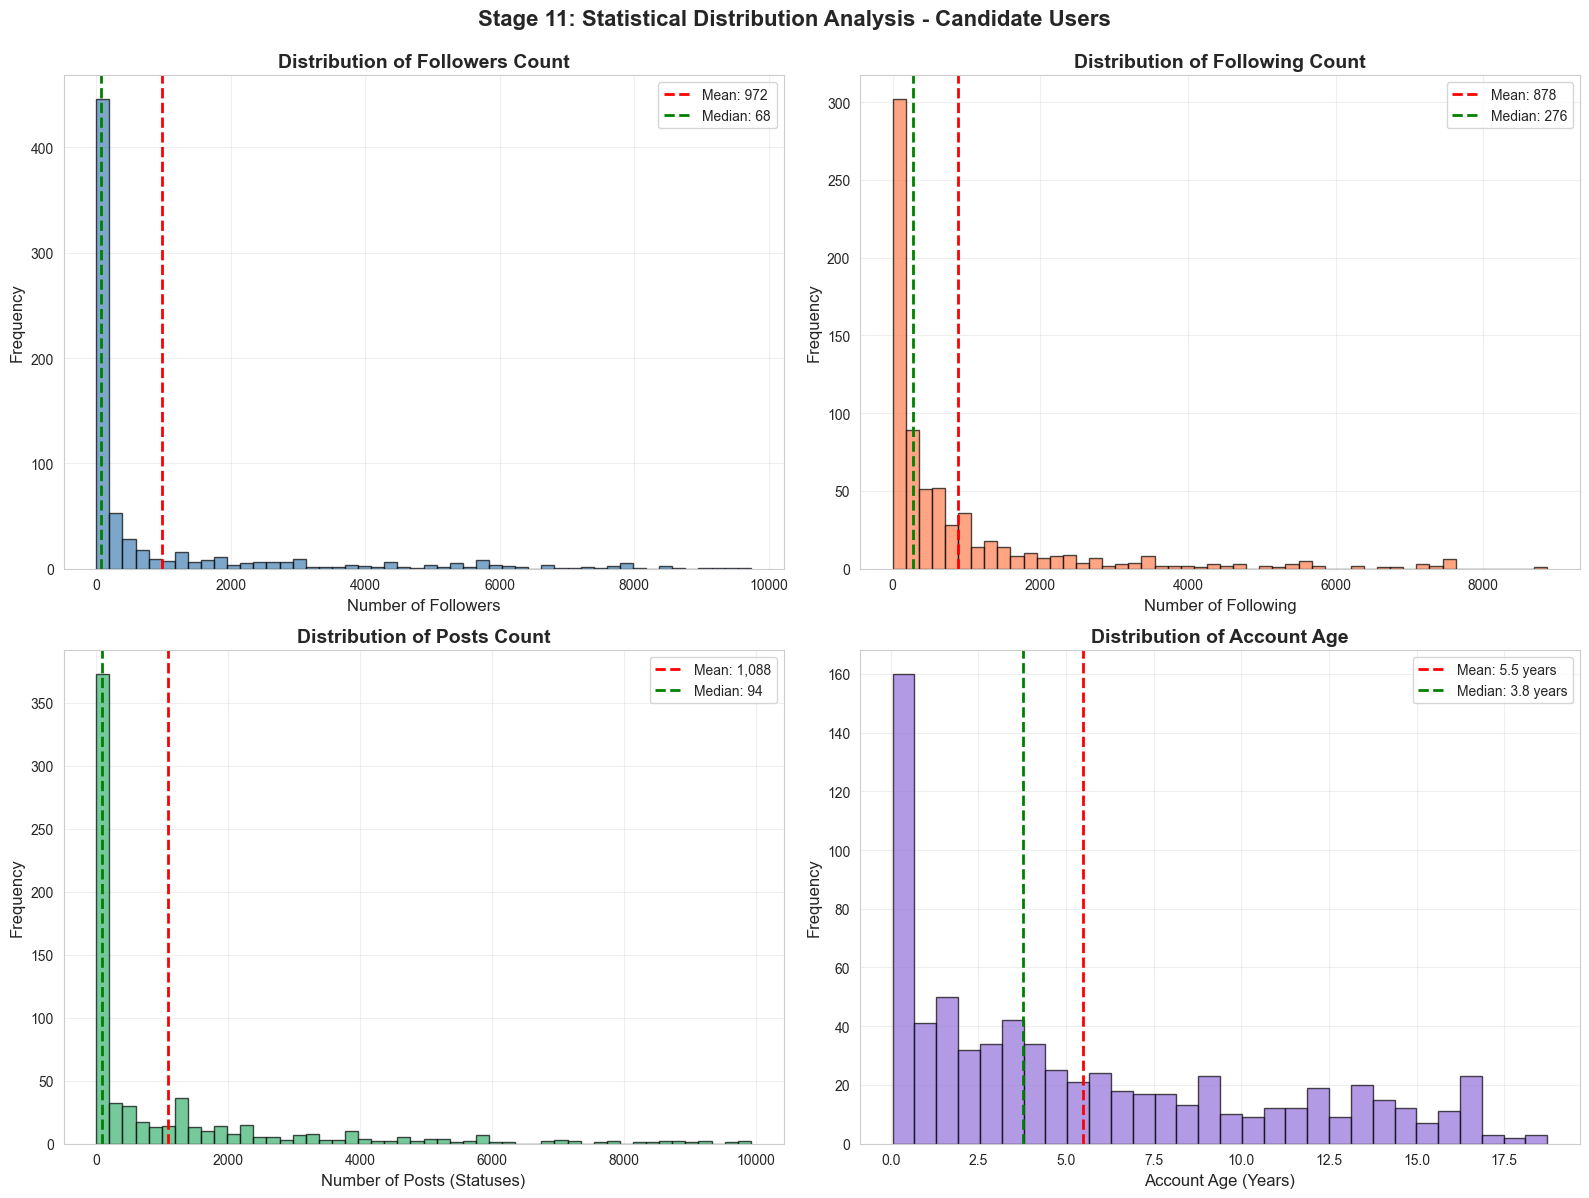


🏆 ניתוח משתמשים מובילים

📌 Top 10 Users by Followers:
────────────────────────────────────────────────────────────
   @albionroar           | Albion Roar BHAFC              |      9,733
   @airwallex            | Airwallex                      |      9,375
   @aesmailnazhad        | agiri esmailnazhad             |      9,213
   @a_f_cebeci           | Ali Fuat Cebeci                |      9,013
   @abdulbaset22         | ‏عبدالباسط الحمادي             |      8,645
   @_articlle_           | お父さん                           |      8,556
   @ahlulbayt__313       | Ahlul•Bayt ♡ 📚                 |      8,520
   @afcmediatv           | AFC Media and Broadcast Operat |      8,476
   @_alonso11            | Alonso Martínez                |      7,990
   @agencecapa           | CAPA                           |      7,920

📌 Top 10 Most Active Users (by posts):
────────────────────────────────────────────────────────────
   @ahmed_rami           | Ahmed Rami - احمد رامي         |      9,923
  

In [1]:
# ============================================
# Stage 11: Statistical Analysis of Potential Target Users
# Input:  POIs/Candidates/Candidates_user_data_MERGED.csv
# Output: Statistical summary table and histograms
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

print("=" * 80)
print("STAGE 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים")
print("=" * 80)

# File paths
CANDIDATES_DIR = Path("POIs") / "Candidates"
MERGED_CSV = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

# Load data
print(f"\n📂 טוען קובץ: {MERGED_CSV}")
df = pd.read_csv(MERGED_CSV, encoding='utf-8')

print(f"✅ נטענו {len(df):,} שורות")
print(f"\nעמודות זמינות: {', '.join(df.columns)}")

# ============================================
# משימה 1: ניקוי נתונים והמרה לטיפוסים נכונים
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 1: ניקוי והכנת נתונים")
print("=" * 80)

# המרת עמודות מספריות
numeric_cols = ['followers_count', 'following_count', 'statuses_count']
for col in numeric_cols:
    if col in df.columns:
        # המרה למספרים - ערכים לא חוקיים יהפכו ל-NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# טיפול בתאריכים
if 'created_at' in df.columns:
    # המרת created_at לפורמט תאריך
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    # חישוב גיל החשבון בשנים
    current_date = pd.Timestamp.now()
    df['account_age_years'] = (current_date - df['created_at']).dt.days / 365.25

print(f"\n✅ המרת נתונים הושלמה")

# ============================================
# משימה 2: חישוב סטטיסטיקה תיאורית
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 2: חישוב מדדים סטטיסטיים")
print("=" * 80)

# ספירת משתמשים עם נתונים מלאים
df_with_data = df[df['followers_count'].notna()].copy()

# חישוב סטטיסטיקות
stats = {
    'Total unique users': len(df),
    'Users with complete data': len(df_with_data),
    'Data completeness (%)': round(len(df_with_data) / len(df) * 100, 1),
    'Average posts (statuses_count)': int(df_with_data['statuses_count'].mean()) if 'statuses_count' in df.columns else 'N/A',
    'Median posts': int(df_with_data['statuses_count'].median()) if 'statuses_count' in df.columns else 'N/A',
    'Average followers': int(df_with_data['followers_count'].mean()),
    'Median followers': int(df_with_data['followers_count'].median()),
    'Average following': int(df_with_data['following_count'].mean()) if 'following_count' in df.columns else 'N/A',
    'Median following': int(df_with_data['following_count'].median()) if 'following_count' in df.columns else 'N/A',
}

# הוספת סטטיסטיקות נוספות אם יש נתוני תאריך
if 'account_age_years' in df.columns and df_with_data['account_age_years'].notna().sum() > 0:
    stats['Average account age (years)'] = round(df_with_data['account_age_years'].mean(), 1)
    stats['Median account age (years)'] = round(df_with_data['account_age_years'].median(), 1)

# ============================================
# משימה 3: הצגת טבלה מסכמת
# ============================================
print("\n" + "=" * 80)
print("📋 שלב 3: טבלה מסכמת")
print("=" * 80)
print()

# יצירת DataFrame מהסטטיסטיקות
stats_df = pd.DataFrame(list(stats.items()), columns=['Metric', 'Value'])

# הצגת הטבלה
print("┌" + "─" * 50 + "┐")
print("│" + " " * 10 + "STATISTICAL SUMMARY" + " " * 21 + "│")
print("├" + "─" * 50 + "┤")

for idx, row in stats_df.iterrows():
    metric = row['Metric']
    value = f"{row['Value']:,}" if isinstance(row['Value'], (int, float)) else str(row['Value'])
    padding = 48 - len(metric) - len(value)
    print(f"│ {metric}{' ' * padding}{value} │")

print("└" + "─" * 50 + "┘")

# שמירת הטבלה לקובץ
stats_output = CANDIDATES_DIR / "Candidates_statistics_summary.csv"
stats_df.to_csv(stats_output, index=False, encoding='utf-8')
print(f"\n💾 טבלה נשמרה ב: {stats_output}")

# ============================================
# משימה 4: יצירת היסטוגרמות
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 4: יצירת ויזואליזציות")
print("=" * 80)

# יצירת תיקייה לתרשימים
figures_dir = CANDIDATES_DIR / "figures" / "stage11_analysis"
figures_dir.mkdir(parents=True, exist_ok=True)

# הגדרת סגנון
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# יצירת 2x2 היסטוגרמות
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stage 11: Statistical Distribution Analysis - Candidate Users', 
             fontsize=16, fontweight='bold', y=0.995)

# היסטוגרמה 1: Followers Distribution
ax1 = axes[0, 0]
followers_data = df_with_data['followers_count'].dropna()
ax1.hist(followers_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(followers_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(followers_data.mean()):,}')
ax1.axvline(followers_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(followers_data.median()):,}')
ax1.set_xlabel('Number of Followers', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Followers Count', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# היסטוגרמה 2: Following Distribution
ax2 = axes[0, 1]
if 'following_count' in df.columns:
    following_data = df_with_data['following_count'].dropna()
    ax2.hist(following_data, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax2.axvline(following_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(following_data.mean()):,}')
    ax2.axvline(following_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(following_data.median()):,}')
    ax2.set_xlabel('Number of Following', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Following Count', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# היסטוגרמה 3: Posts/Statuses Distribution
ax3 = axes[1, 0]
if 'statuses_count' in df.columns:
    posts_data = df_with_data['statuses_count'].dropna()
    ax3.hist(posts_data, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax3.axvline(posts_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(posts_data.mean()):,}')
    ax3.axvline(posts_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(posts_data.median()):,}')
    ax3.set_xlabel('Number of Posts (Statuses)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Distribution of Posts Count', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# היסטוגרמה 4: Account Age Distribution
ax4 = axes[1, 1]
if 'account_age_years' in df.columns and df_with_data['account_age_years'].notna().sum() > 0:
    age_data = df_with_data['account_age_years'].dropna()
    ax4.hist(age_data, bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
    ax4.axvline(age_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_data.mean():.1f} years')
    ax4.axvline(age_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {age_data.median():.1f} years')
    ax4.set_xlabel('Account Age (Years)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Distribution of Account Age', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Account Age Data Not Available', 
             ha='center', va='center', fontsize=14, transform=ax4.transAxes)
    ax4.set_title('Distribution of Account Age', fontsize=14, fontweight='bold')

plt.tight_layout()

# שמירת התרשים
histogram_file = figures_dir / "candidates_distribution_histograms.png"
plt.savefig(histogram_file, dpi=300, bbox_inches='tight')
print(f"\n📊 היסטוגרמות נשמרו ב: {histogram_file}")

plt.show()

# ============================================
# סיכום נוסף: Top Users Analysis
# ============================================
print("\n" + "=" * 80)
print("🏆 ניתוח משתמשים מובילים")
print("=" * 80)

print("\n📌 Top 10 Users by Followers:")
print("─" * 60)
top_followers = df_with_data.nlargest(10, 'followers_count')[['username', 'display_name', 'followers_count']]
for idx, row in top_followers.iterrows():
    username = row['username'] if pd.notna(row['username']) else 'N/A'
    display_name = row['display_name'] if pd.notna(row['display_name']) else 'N/A'
    followers = f"{int(row['followers_count']):,}" if pd.notna(row['followers_count']) else 'N/A'
    print(f"   @{username[:20]:<20} | {display_name[:30]:<30} | {followers:>10}")

if 'statuses_count' in df.columns:
    print("\n📌 Top 10 Most Active Users (by posts):")
    print("─" * 60)
    top_posts = df_with_data.nlargest(10, 'statuses_count')[['username', 'display_name', 'statuses_count']]
    for idx, row in top_posts.iterrows():
        username = row['username'] if pd.notna(row['username']) else 'N/A'
        display_name = row['display_name'] if pd.notna(row['display_name']) else 'N/A'
        posts = f"{int(row['statuses_count']):,}" if pd.notna(row['statuses_count']) else 'N/A'
        print(f"   @{username[:20]:<20} | {display_name[:30]:<30} | {posts:>10}")

# ============================================
# סיכום סופי
# ============================================
print("\n" + "=" * 80)
print("✅ STAGE 11 הושלם בהצלחה!")
print("=" * 80)
print(f"\n📊 סה\"כ משתמשים נותחו: {len(df):,}")
print(f"✅ משתמשים עם נתונים מלאים: {len(df_with_data):,} ({stats['Data completeness (%)']}%)")
print(f"📁 קבצי פלט:")
print(f"   • טבלה סטטיסטית: {stats_output}")
print(f"   • היסטוגרמות: {histogram_file}")
print("=" * 80)

## Stage 12: Manual Labeling - Iteration 1 (Data Preparation)

In [2]:
"""
================================================================================
STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)
================================================================================

This script prepares a random sample of Twitter users for MANUAL labeling.
NO automation, NO machine learning, NO inference - only data preparation.

INPUT:
    POIs/Candidates/Candidates_user_data_MERGED.csv
    
OUTPUT:
    Iran/Classification/iteration_1_manual_labeling.csv
    Iran/Classification/iteration_1_target_population.csv
    Iran/Classification/iteration_1_locals_vs_diaspora.csv
    Iran/Classification/iteration_1_person_vs_organization.csv

LABELING SCHEMA:
    1. target_population: target / non_target / unknown
    2. locals_vs_diaspora: local / diaspora / unknown
    3. person_vs_organization: person / organization / unknown
    4. comments: free text for human notes

================================================================================
"""

import pandas as pd
from pathlib import Path

# ============================================
# Configuration
# ============================================
SAMPLE_SIZE = 100
RANDOM_SEED = 42

# Input file paths
CANDIDATES_DIR = Path("POIs") / "Candidates"
INPUT_CSV = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

# Output directory and files
CLASSIFICATION_DIR = Path("POIs") / "Classification"
OUTPUT_FILES = {
    'main': CLASSIFICATION_DIR / "iteration_1_manual_labeling.csv",
    'target_pop': CLASSIFICATION_DIR / "iteration_1_target_population.csv",
    'locals_diaspora': CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv",
    'person_org': CLASSIFICATION_DIR / "iteration_1_person_vs_organization.csv"
}

# Labeling columns to add (all initialized as empty strings)
LABELING_COLUMNS = {
    'target_population': '',
    'locals_vs_diaspora': '',
    'person_vs_organization': '',
    'comments': ''
}

print("=" * 80)
print("STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)")
print("=" * 80)
print(f"\n📌 Task: Prepare {SAMPLE_SIZE} random users for manual labeling")
print(f"📌 Random seed: {RANDOM_SEED} (for reproducibility)")

# ============================================
# STEP 1: Load and Sample Data
# ============================================
def load_and_sample_data(input_file, sample_size, random_state):
    """
    Load the input CSV and randomly sample unique users.
    
    Parameters:
    -----------
    input_file : Path
        Path to the input CSV file
    sample_size : int
        Number of users to sample
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    pd.DataFrame
        Sampled DataFrame with exactly sample_size rows
    """
    print(f"\n{'─' * 80}")
    print("STEP 1: LOADING AND SAMPLING DATA")
    print(f"{'─' * 80}")
    
    # Load the full dataset
    print(f"\n📂 Loading input file: {input_file}")
    df_full = pd.read_csv(input_file, encoding='utf-8')
    print(f"✅ Loaded {len(df_full):,} total users")
    
    # Check if we have enough data
    if len(df_full) < sample_size:
        raise ValueError(f"Not enough data! File has {len(df_full)} rows but need {sample_size}")
    
    # Random sampling with fixed seed
    print(f"\n🎲 Randomly sampling {sample_size} users (seed={random_state})...")
    df_sample = df_full.sample(n=sample_size, random_state=random_state)
    
    # Reset index to get clean sequential indices
    df_sample = df_sample.reset_index(drop=True)
    
    print(f"✅ Sampled exactly {len(df_sample)} unique users")
    print(f"✅ Sample index range: 0 to {len(df_sample)-1}")
    
    return df_sample


# ============================================
# STEP 2: Add Manual Labeling Columns
# ============================================
def add_labeling_columns(df, labeling_cols):
    """
    Add empty labeling columns to the DataFrame.
    These columns are for HUMAN annotation only.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The sampled DataFrame
    labeling_cols : dict
        Dictionary of column names and their initial values
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added labeling columns
    """
    print(f"\n{'─' * 80}")
    print("STEP 2: ADDING MANUAL LABELING COLUMNS")
    print(f"{'─' * 80}")
    
    df_labeled = df.copy()
    
    print(f"\n📝 Adding {len(labeling_cols)} labeling columns:")
    for col_name, initial_value in labeling_cols.items():
        df_labeled[col_name] = initial_value
        print(f"   ✓ {col_name:<30} [initialized as empty string]")
    
    print(f"\n✅ Total columns now: {len(df_labeled.columns)}")
    print(f"   • Original metadata columns: {len(df.columns)}")
    print(f"   • New labeling columns: {len(labeling_cols)}")
    
    return df_labeled


# ============================================
# STEP 3: Save Output Files
# ============================================
def save_output_files(df, output_files, classification_dir):
    """
    Save the prepared dataset to multiple CSV files.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The prepared DataFrame with labeling columns
    output_files : dict
        Dictionary mapping file types to file paths
    classification_dir : Path
        Directory to create if it doesn't exist
    """
    print(f"\n{'─' * 80}")
    print("STEP 3: SAVING OUTPUT FILES")
    print(f"{'─' * 80}")
    
    # Create output directory if needed
    classification_dir.mkdir(parents=True, exist_ok=True)
    print(f"\n📁 Output directory: {classification_dir}")
    if classification_dir.exists():
        print(f"   ✓ Directory confirmed")
    
    # Save all four required files
    print(f"\n💾 Saving {len(output_files)} output files:")
    saved_files = []
    
    for file_type, file_path in output_files.items():
        df.to_csv(file_path, index=False, encoding='utf-8')
        file_size_kb = file_path.stat().st_size / 1024
        print(f"   ✓ {file_path.name:<50} ({file_size_kb:.1f} KB)")
        saved_files.append(str(file_path))
    
    print(f"\n✅ All {len(output_files)} files saved successfully")
    
    return saved_files


# ============================================
# STEP 4: Generate Empty Summary Tables
# ============================================
def generate_summary_templates():
    """
    Generate and display empty summary table templates.
    These will be filled AFTER manual labeling is complete.
    """
    print(f"\n{'─' * 80}")
    print("STEP 4: SUMMARY TABLE TEMPLATES (EMPTY - TO BE FILLED AFTER LABELING)")
    print(f"{'─' * 80}")
    
    # Define the classification schemas
    schemas = {
        'target_population': ['target', 'non_target', 'unknown'],
        'locals_vs_diaspora': ['local', 'diaspora', 'unknown'],
        'person_vs_organization': ['person', 'organization', 'unknown']
    }
    
    for schema_name, classes in schemas.items():
        print(f"\n📊 {schema_name.upper().replace('_', ' ')}:")
        print("┌" + "─" * 30 + "┬" + "─" * 10 + "┬" + "─" * 15 + "┐")
        print(f"│ {'Class':<28} │ {'Count':>8} │ {'Percentage':>13} │")
        print("├" + "─" * 30 + "┼" + "─" * 10 + "┼" + "─" * 15 + "┤")
        
        for cls in classes:
            print(f"│ {cls:<28} │ {0:>8} │ {0.0:>12.1f}% │")
        
        print("└" + "─" * 30 + "┴" + "─" * 10 + "┴" + "─" * 15 + "┘")
    
    print("\n📝 Note: These tables will be populated after manual labeling is complete.")


# ============================================
# Main Execution
# ============================================
def main():
    """
    Main function to orchestrate the data preparation workflow.
    """
    try:
        # Step 1: Load and sample data
        df_sample = load_and_sample_data(INPUT_CSV, SAMPLE_SIZE, RANDOM_SEED)
        
        # Step 2: Add labeling columns
        df_prepared = add_labeling_columns(df_sample, LABELING_COLUMNS)
        
        # Step 3: Save output files
        saved_files = save_output_files(df_prepared, OUTPUT_FILES, CLASSIFICATION_DIR)
        
        # Step 4: Generate summary templates
        generate_summary_templates()
        
        # Final summary
        print("\n" + "=" * 80)
        print("✅ STAGE 12 DATA PREPARATION COMPLETED SUCCESSFULLY")
        print("=" * 80)
        
        print(f"\n📊 SUMMARY:")
        print(f"   • Number of sampled users: {len(df_prepared)}")
        print(f"   • Random seed used: {RANDOM_SEED}")
        print(f"   • Original metadata columns: {len(df_sample.columns)}")
        print(f"   • Labeling columns added: {len(LABELING_COLUMNS)}")
        print(f"   • Total columns in output: {len(df_prepared.columns)}")
        
        print(f"\n📁 OUTPUT FILES CREATED:")
        for file_path in saved_files:
            print(f"   ✓ {file_path}")
        
        print(f"\n📝 LABELING COLUMNS (all initialized as empty):")
        for col_name in LABELING_COLUMNS.keys():
            print(f"   • {col_name}")
        
        print("\n" + "=" * 80)
        print("🎯 MANUAL LABELING READY - YOU CAN NOW START LABELING USERS ONE BY ONE")
        print("=" * 80)
        
        print("\n💡 NEXT STEPS:")
        print("   1. Open: Iran/Classification/iteration_1_manual_labeling.csv")
        print("   2. For each user, review their profile metadata")
        print("   3. Manually fill in the labeling columns:")
        print("      - target_population")
        print("      - locals_vs_diaspora")
        print("      - person_vs_organization")
        print("      - comments (optional notes)")
        print("   4. Save the file after labeling")
        print("   5. Accuracy is more important than speed!")
        
        return df_prepared
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        raise


# Run the main function
df_iteration_1 = main()

STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)

📌 Task: Prepare 100 random users for manual labeling
📌 Random seed: 42 (for reproducibility)

────────────────────────────────────────────────────────────────────────────────
STEP 1: LOADING AND SAMPLING DATA
────────────────────────────────────────────────────────────────────────────────

📂 Loading input file: POIs\Candidates\Candidates_user_data_MERGED.csv
✅ Loaded 946 total users

🎲 Randomly sampling 100 users (seed=42)...
✅ Sampled exactly 100 unique users
✅ Sample index range: 0 to 99

────────────────────────────────────────────────────────────────────────────────
STEP 2: ADDING MANUAL LABELING COLUMNS
────────────────────────────────────────────────────────────────────────────────

📝 Adding 4 labeling columns:
   ✓ target_population              [initialized as empty string]
   ✓ locals_vs_diaspora             [initialized as empty string]
   ✓ person_vs_organization         [initialized as empty string]
   ✓ comments  